In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None) 

In [8]:
df = pd.read_csv('Google - Trafico Humano.csv')

In [9]:
df.head()

yearRegister  gender majorityStatus  isForcedLabour  isSexualExploit  \
0          NaN  Female          Adult             1.0              NaN   
1          NaN  Female          Adult             1.0              NaN   
2          NaN  Female          Adult             1.0              NaN   
3          NaN  Female          Adult             1.0              NaN   
4          NaN  Female          Adult             1.0              NaN   

  UN_COO_Region UN_COE_Region  IP_Exploiter    IP_Gender IP_ageBroad  \
0        Europe        Europe           1.0  Female;Male         NaN   
1        Europe        Europe           1.0  Female;Male         NaN   
2        Europe        Europe           1.0  Female;Male         NaN   
3        Europe        Europe           1.0  Female;Male         NaN   
4        Europe        Europe           1.0  Female;Male         NaN   

  IP_citizen_UNRegion           IP_Relation IP_PayMoney  IP_RecruiterBroker  \
0              Europe  StrangerUnknownOther      No;Yes                 1.0   
1              Europe  StrangerUnknownOther      No;Yes                 1.0   
2              Europe  StrangerUnknownOther      No;Yes                 1.0   
3              Europe  StrangerUnknownOther      No;Yes                 1.0   
4              Europe  StrangerUnknownOther      No;Yes                 1.0   

   IP_TransactionProcess  IP_ControlAbuseKidnap  
0                    1.0                    1.0  
1                    1.0                    1.0  
2                    1.0                    1.0  
3                    1.0                    1.0  
4                    1.0                    1.0

In [10]:
df.isnull().sum()

yearRegister              3655
gender                    3611
majorityStatus            3604
isForcedLabour            8947
isSexualExploit          18420
UN_COO_Region             3610
UN_COE_Region             3999
IP_Exploiter             11737
IP_Gender                 5408
IP_ageBroad              17993
IP_citizen_UNRegion       6946
IP_Relation               6623
IP_PayMoney               6040
IP_RecruiterBroker        9330
IP_TransactionProcess    13851
IP_ControlAbuseKidnap    19117
dtype: int64

In [13]:
df.shape

(21195, 16)

In [11]:
df = df.fillna(0)

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr, spearmanr, kendalltau
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Configurações para visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# =====================================================
# 1. ANÁLISES UNIVARIADAS
# =====================================================

def analise_univariada_completa(df):
    """Análise univariada completa do dataset"""
    
    print("=" * 60)
    print("ANÁLISE UNIVARIADA COMPLETA")
    print("=" * 60)
    
    # 1.1 Análise de valores ausentes
    print("\n1.1 ANÁLISE DE VALORES AUSENTES")
    print("-" * 40)
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Valores_Ausentes': missing_data,
        'Percentual': missing_percent
    }).sort_values('Percentual', ascending=False)
    
    print(missing_df)
    
    # Visualização de dados ausentes
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    missing_df['Percentual'].plot(kind='barh')
    plt.title('Percentual de Dados Ausentes por Variável')
    plt.xlabel('Percentual (%)')
    
    # 1.2 Análise de variáveis categóricas
    print("\n1.2 ANÁLISE DE VARIÁVEIS CATEGÓRICAS")
    print("-" * 40)
    
    categorical_vars = df.select_dtypes(include=['object']).columns
    
    for var in categorical_vars:
        print(f"\n>>> {var}")
        value_counts = df[var].value_counts()
        print(f"Valores únicos: {df[var].nunique()}")
        print(f"Valores mais frequentes:")
        print(value_counts.head())
        
        # Visualização
        if df[var].nunique() <= 15:  # Só plotar se tiver poucos valores únicos
            plt.figure(figsize=(10, 6))
            df[var].value_counts().head(10).plot(kind='bar')
            plt.title(f'Distribuição de {var}')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
    
    # 1.3 Análise de variáveis numéricas
    print("\n1.3 ANÁLISE DE VARIÁVEIS NUMÉRICAS")
    print("-" * 40)
    
    numerical_vars = df.select_dtypes(include=['float64', 'int64']).columns
    
    for var in numerical_vars:
        print(f"\n>>> {var}")
        print(f"Estatísticas descritivas:")
        print(df[var].describe())
        
        # Teste de normalidade
        if df[var].dropna().shape[0] > 3:
            _, p_value = stats.shapiro(df[var].dropna()[:5000])  # Limite para shapiro
            print(f"Teste de Normalidade (Shapiro-Wilk): p-value = {p_value:.4f}")
            print(f"Distribuição {'Normal' if p_value > 0.05 else 'Não-Normal'}")
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Histograma com seaborn
        sns.histplot(df[var].dropna(), bins=30, kde=True, ax=axes[0], color='skyblue')
        axes[0].set_title(f'Histograma - {var}')
        
        # Boxplot com seaborn
        sns.boxplot(y=df[var].dropna(), ax=axes[1], color='lightgreen')
        axes[1].set_title(f'Boxplot - {var}')
        
        # Q-Q Plot (mantém com scipy)
        stats.probplot(df[var].dropna(), dist="norm", plot=axes[2])
        axes[2].set_title(f'Q-Q Plot - {var}')
        
        plt.tight_layout()
        plt.show()

def analise_temporal(df):
    """Análise temporal da variável yearRegister"""
    
    print("\n" + "="*60)
    print("ANÁLISE TEMPORAL")
    print("="*60)
    
    if 'yearRegister' in df.columns:
        # Converter para datetime se necessário
        df_temp = df.copy()
        df_temp['yearRegister'] = pd.to_datetime(df_temp['yearRegister'], errors='coerce')
        
        # Análise por ano
        yearly_counts = df_temp['yearRegister'].dt.year.value_counts().sort_values(ascending=False)
        print("Registros por ano:")
        print(yearly_counts)
        
        # Visualização
        plt.figure(figsize=(12, 6))
        yearly_counts.plot(kind='line', marker='o')
        plt.title('Evolução Temporal dos Registros')
        plt.xlabel('Ano')
        plt.ylabel('Número de Registros')
        plt.grid(True)
        plt.show()

# =====================================================
# 2. ANÁLISES BIVARIADAS
# =====================================================

def analise_bivariada_completa(df):
    """Análise bivariada completa"""
    
    print("\n" + "="*60)
    print("ANÁLISE BIVARIADA COMPLETA")
    print("="*60)
    
    # 2.1 Correlações entre variáveis numéricas
    print("\n2.1 MATRIZ DE CORRELAÇÃO - VARIÁVEIS NUMÉRICAS")
    print("-" * 50)
    
    numerical_vars = df.select_dtypes(include=['float64', 'int64']).columns
    
    if len(numerical_vars) > 1:
        corr_matrix = df[numerical_vars].corr()
        print(corr_matrix)
        
        # Heatmap de correlação
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                    square=True, fmt='.3f')
        plt.title('Matriz de Correlação - Variáveis Numéricas')
        plt.tight_layout()
        plt.show()
        
        # Correlações mais fortes
        print("\nCorrelações mais fortes (|r| > 0.3):")
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_val = corr_matrix.iloc[i, j]
                if abs(corr_val) > 0.3:
                    print(f"{corr_matrix.columns[i]} x {corr_matrix.columns[j]}: {corr_val:.3f}")
    
    # 2.2 Análise categórica vs categórica (Teste Qui-quadrado)
    print("\n2.2 ANÁLISE CATEGÓRICA vs CATEGÓRICA")
    print("-" * 50)
    
    categorical_vars = df.select_dtypes(include=['object']).columns
    
    for i, var1 in enumerate(categorical_vars):
        for var2 in categorical_vars[i+1:]:
            # Criar tabela de contingência
            contingency_table = pd.crosstab(df[var1], df[var2])
            
            if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
                # Teste qui-quadrado
                chi2, p_value, dof, expected = chi2_contingency(contingency_table)
                
                print(f"\n>>> {var1} x {var2}")
                print(f"Chi-quadrado: {chi2:.4f}")
                print(f"p-value: {p_value:.4f}")
                print(f"Associação {'Significativa' if p_value < 0.05 else 'Não Significativa'}")
                
                # Coeficiente de Cramér's V
                n = contingency_table.sum().sum()
                cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
                print(f"Cramér's V: {cramers_v:.4f}")
                
                # Visualização (apenas para algumas combinações importantes)
                if p_value < 0.05 and contingency_table.shape[0] <= 10 and contingency_table.shape[1] <= 10:
                    plt.figure(figsize=(10, 6))
                    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
                    plt.title(f'Tabela de Contingência: {var1} x {var2}')
                    plt.tight_layout()
                    plt.show()

def analise_categorica_numerica(df):
    """Análise entre variáveis categóricas e numéricas"""
    
    print("\n2.3 ANÁLISE CATEGÓRICA vs NUMÉRICA")
    print("-" * 50)
    
    categorical_vars = df.select_dtypes(include=['object']).columns
    numerical_vars = df.select_dtypes(include=['float64', 'int64']).columns
    
    for cat_var in categorical_vars:
        for num_var in numerical_vars:
            # Remover valores nulos
            data_clean = df[[cat_var, num_var]].dropna()
            
            if len(data_clean) > 10:
                groups = data_clean.groupby(cat_var)[num_var].apply(list)
                
                if len(groups) >= 2:
                    print(f"\n>>> {cat_var} x {num_var}")
                    
                    # Estatísticas por grupo
                    stats_by_group = data_clean.groupby(cat_var)[num_var].describe()
                    print(stats_by_group)
                    
                    # Teste ANOVA (se mais de 2 grupos) ou t-test (se 2 grupos)
                    if len(groups) == 2:
                        group_values = [group for group in groups.values]
                        t_stat, p_value = stats.ttest_ind(group_values[0], group_values[1])
                        print(f"Teste t: t = {t_stat:.4f}, p-value = {p_value:.4f}")
                    else:
                        group_values = [group for group in groups.values if len(group) > 1]
                        if len(group_values) >= 2:
                            f_stat, p_value = stats.f_oneway(*group_values)
                            print(f"ANOVA: F = {f_stat:.4f}, p-value = {p_value:.4f}")
                    
                    # Visualização boxplot
                    if data_clean[cat_var].nunique() <= 10:
                        plt.figure(figsize=(10, 6))
                        sns.boxplot(data=data_clean, x=cat_var, y=num_var)
                        plt.title(f'{num_var} por {cat_var}')
                        plt.xticks(rotation=45)
                        plt.tight_layout()
                        plt.show()

# =====================================================
# 3. ANÁLISES MULTIVARIADAS
# =====================================================

def analise_multivariada_completa(df):
    """Análise multivariada completa"""
    
    print("\n" + "="*60)
    print("ANÁLISE MULTIVARIADA COMPLETA")
    print("="*60)
    
    # 3.1 Análise de Componentes Principais (PCA)
    print("\n3.1 ANÁLISE DE COMPONENTES PRINCIPAIS (PCA)")
    print("-" * 50)
    
    # Preparar dados para PCA (apenas variáveis numéricas)
    numerical_vars = df.select_dtypes(include=['float64', 'int64']).columns
    df_numeric = df[numerical_vars].dropna()
    
    if len(df_numeric) > 10 and len(numerical_vars) > 1:
        print(f"Analisando {len(numerical_vars)} variáveis numéricas com {len(df_numeric)} observações válidas.")
        
        # Padronizar os dados
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df_numeric)
        
        # Aplicar PCA
        n_components = min(len(numerical_vars), len(df_numeric))
        pca = PCA(n_components=n_components)
        pca_result = pca.fit_transform(df_scaled)
        
        # Variância explicada
        explained_variance = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)
        
        print("Variância explicada por componente:")
        for i, var in enumerate(explained_variance):
            print(f"PC{i+1}: {var:.4f} ({var*100:.2f}%)")
        
        # Mostrar variância acumulada baseada no número de componentes disponíveis
        if len(cumulative_variance) >= 3:
            print(f"\nVariância acumulada até PC3: {cumulative_variance[2]:.4f} ({cumulative_variance[2]*100:.2f}%)")
        elif len(cumulative_variance) >= 2:
            print(f"\nVariância acumulada até PC2: {cumulative_variance[1]:.4f} ({cumulative_variance[1]*100:.2f}%)")
        else:
            print(f"\nVariância acumulada PC1: {cumulative_variance[0]:.4f} ({cumulative_variance[0]*100:.2f}%)")
        
        # Visualização
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(explained_variance)+1), explained_variance, 'bo-')
        plt.xlabel('Componente Principal')
        plt.ylabel('Variância Explicada')
        plt.title('Scree Plot')
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'ro-')
        plt.xlabel('Componente Principal')
        plt.ylabel('Variância Acumulada')
        plt.title('Variância Acumulada')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Biplot dos primeiros dois componentes (apenas se tiver pelo menos 2 componentes)
        if len(numerical_vars) >= 2 and len(explained_variance) >= 2:
            plt.figure(figsize=(10, 8))
            plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
            
            # Adicionar vetores das variáveis
            for i, var in enumerate(numerical_vars):
                plt.arrow(0, 0, pca.components_[0, i]*3, pca.components_[1, i]*3, 
                         head_width=0.1, head_length=0.1, fc='red', ec='red')
                plt.text(pca.components_[0, i]*3.2, pca.components_[1, i]*3.2, var, 
                        fontsize=10, ha='center', va='center')
            
            plt.xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)')
            plt.ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)')
            plt.title('PCA Biplot')
            plt.grid(True)
            plt.show()
        else:
            print("PCA Biplot não disponível: necessário pelo menos 2 variáveis numéricas com dados suficientes.")

def analise_clustering(df):
    """Análise de clustering"""
    
    print("\n3.2 ANÁLISE DE CLUSTERING")
    print("-" * 50)
    
    # Preparar dados
    numerical_vars = df.select_dtypes(include=['float64', 'int64']).columns
    df_numeric = df[numerical_vars].dropna()
    
    if len(df_numeric) > 10 and len(numerical_vars) > 1:
        # Padronizar os dados
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df_numeric)
        
        # Método do cotovelo para encontrar número ótimo de clusters
        inertias = []
        K_range = range(2, min(11, len(df_numeric)//10))
        
        for k in K_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(df_scaled)
            inertias.append(kmeans.inertia_)
        
        # Visualizar método do cotovelo
        plt.figure(figsize=(10, 6))
        plt.plot(K_range, inertias, 'bo-')
        plt.xlabel('Número de Clusters (k)')
        plt.ylabel('Inércia')
        plt.title('Método do Cotovelo para Determinação do Número de Clusters')
        plt.grid(True)
        plt.show()
        
        # Aplicar K-means com k=3 (ou número sugerido)
        optimal_k = 3 if len(K_range) >= 2 else 2
        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(df_scaled)
        
        print(f"Aplicando K-means com {optimal_k} clusters")
        print(f"Distribuição dos clusters:")
        unique, counts = np.unique(clusters, return_counts=True)
        for cluster, count in zip(unique, counts):
            print(f"Cluster {cluster}: {count} observações ({count/len(clusters)*100:.1f}%)")
        
        # Visualização dos clusters (usando PCA para redução dimensional)
        if len(numerical_vars) >= 2 and len(df_scaled) > 0:
            pca = PCA(n_components=min(2, len(numerical_vars)))
            pca_result = pca.fit_transform(df_scaled)
            
            plt.figure(figsize=(10, 8))
            if pca_result.shape[1] >= 2:
                scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', alpha=0.7)
                plt.colorbar(scatter)
                plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
                plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
                plt.title('Clusters Visualizados no Espaço PCA')
                plt.show()
            else:
                # Se só há 1 dimensão, fazer histograma
                plt.hist([pca_result[clusters == i, 0] for i in range(optimal_k)], 
                        bins=20, alpha=0.7, label=[f'Cluster {i}' for i in range(optimal_k)])
                plt.xlabel('PC1')
                plt.ylabel('Frequência')
                plt.title('Distribuição dos Clusters')
                plt.legend()
                plt.show()
        else:
            print("Visualização de clusters não disponível: dados insuficientes.")

def analise_correlacoes_avancadas(df):
    """Análises de correlação avançadas"""
    
    print("\n3.3 ANÁLISES DE CORRELAÇÃO AVANÇADAS")
    print("-" * 50)
    
    numerical_vars = df.select_dtypes(include=['float64', 'int64']).columns
    
    if len(numerical_vars) >= 2:
        print("Comparação de diferentes tipos de correlação:")
        print("-" * 40)
        
        for i, var1 in enumerate(numerical_vars):
            for var2 in numerical_vars[i+1:]:
                # Remover valores nulos
                data_clean = df[[var1, var2]].dropna()
                
                if len(data_clean) > 10:
                    x, y = data_clean[var1], data_clean[var2]
                    
                    # Correlação de Pearson
                    pearson_r, pearson_p = pearsonr(x, y)
                    
                    # Correlação de Spearman
                    spearman_r, spearman_p = spearmanr(x, y)
                    
                    # Correlação de Kendall
                    kendall_r, kendall_p = kendalltau(x, y)
                    
                    print(f"\n>>> {var1} x {var2}")
                    print(f"Pearson:  r = {pearson_r:.4f}, p = {pearson_p:.4f}")
                    print(f"Spearman: ρ = {spearman_r:.4f}, p = {spearman_p:.4f}")
                    print(f"Kendall:  τ = {kendall_r:.4f}, p = {kendall_p:.4f}")
                    
                    # Se houver correlação significativa, plotar
                    if abs(pearson_r) > 0.3 or pearson_p < 0.05:
                        plt.figure(figsize=(10, 6))
                        plt.scatter(x, y, alpha=0.6)
                        
                        # Linha de tendência
                        z = np.polyfit(x, y, 1)
                        p = np.poly1d(z)
                        plt.plot(x, p(x), "r--", alpha=0.8)
                        
                        plt.xlabel(var1)
                        plt.ylabel(var2)
                        plt.title(f'Scatter Plot: {var1} x {var2}\n'
                                f'Pearson r = {pearson_r:.3f}')
                        plt.grid(True, alpha=0.3)
                        plt.show()

# =====================================================
# 4. TESTES ESTATÍSTICOS AVANÇADOS
# =====================================================

def testes_estatisticos_avancados(df):
    """Testes estatísticos avançados"""
    
    print("\n" + "="*60)
    print("TESTES ESTATÍSTICOS AVANÇADOS")
    print("="*60)
    
    # 4.1 Testes de independência
    print("\n4.1 TESTES DE INDEPENDÊNCIA")
    print("-" * 40)
    
    # Exemplo: Testar independência entre gênero e tipo de exploração
    if 'gender' in df.columns and 'isForcedLabour' in df.columns:
        # Criar tabela de contingência
        contingency = pd.crosstab(df['gender'], df['isForcedLabour'])
        
        if contingency.shape[0] > 1 and contingency.shape[1] > 1:
            chi2, p_value, dof, expected = chi2_contingency(contingency)
            
            print("Teste de Independência: Gênero x Trabalho Forçado")
            print(f"Chi-quadrado: {chi2:.4f}")
            print(f"p-value: {p_value:.4f}")
            print(f"Graus de liberdade: {dof}")
            print(f"Conclusão: {'Variáveis dependentes' if p_value < 0.05 else 'Variáveis independentes'}")
    
    # 4.2 Testes de normalidade mais robustos
    print("\n4.2 TESTES DE NORMALIDADE ROBUSTOS")
    print("-" * 40)
    
    numerical_vars = df.select_dtypes(include=['float64', 'int64']).columns
    
    for var in numerical_vars:
        data = df[var].dropna()
        
        if len(data) > 8:
            # Teste de Kolmogorov-Smirnov
            ks_stat, ks_p = stats.kstest(data, 'norm', args=(data.mean(), data.std()))
            
            # Teste de Anderson-Darling
            ad_stat, ad_critical, ad_significance = stats.anderson(data, dist='norm')
            
            print(f"\n>>> {var}")
            print(f"Kolmogorov-Smirnov: estatística = {ks_stat:.4f}, p-value = {ks_p:.4f}")
            print(f"Anderson-Darling: estatística = {ad_stat:.4f}")
            print(f"Distribuição {'Normal' if ks_p > 0.05 else 'Não-Normal'} (α = 0.05)")

# =====================================================
# 5. FUNÇÃO PRINCIPAL PARA EXECUTAR TODAS AS ANÁLISES
# =====================================================

def executar_todas_analises(df):
    """Executa todas as análises estatísticas"""
    
    print("INICIANDO ANÁLISES ESTATÍSTICAS COMPLETAS")
    print("="*80)
    
    # Análises Univariadas
    analise_univariada_completa(df)
    analise_temporal(df)
    
    # Análises Bivariadas
    analise_bivariada_completa(df)
    analise_categorica_numerica(df)
    
    # Análises Multivariadas
    analise_multivariada_completa(df)
    analise_clustering(df)
    analise_correlacoes_avancadas(df)
    
    # Testes Estatísticos Avançados
    testes_estatisticos_avancados(df)
    
    print("\n" + "="*80)
    print("ANÁLISES CONCLUÍDAS!")
    print("="*80)

# =====================================================
# EXEMPLO DE USO
# =====================================================

"""
Para usar essas funções com seu DataFrame:

# Executar todas as análises
executar_todas_analises(df)

# Ou executar análises específicas
analise_univariada_completa(df)
analise_bivariada_completa(df)
analise_multivariada_completa(df)
"""

'\nPara usar essas funções com seu DataFrame:\n\n# Executar todas as análises\nexecutar_todas_analises(df)\n\n# Ou executar análises específicas\nanalise_univariada_completa(df)\nanalise_bivariada_completa(df)\nanalise_multivariada_completa(df)\n'

### Analise Univariada

ANÁLISE UNIVARIADA COMPLETA

1.1 ANÁLISE DE VALORES AUSENTES
----------------------------------------
                       Valores_Ausentes  Percentual
yearRegister                          0         0.0
gender                                0         0.0
majorityStatus                        0         0.0
isForcedLabour                        0         0.0
isSexualExploit                       0         0.0
UN_COO_Region                         0         0.0
UN_COE_Region                         0         0.0
IP_Exploiter                          0         0.0
IP_Gender                             0         0.0
IP_ageBroad                           0         0.0
IP_citizen_UNRegion                   0         0.0
IP_Relation                           0         0.0
IP_PayMoney                           0         0.0
IP_RecruiterBroker                    0         0.0
IP_TransactionProcess                 0         0.0
IP_ControlAbuseKidnap                 0         0.0

1.2 ANÁLISE D

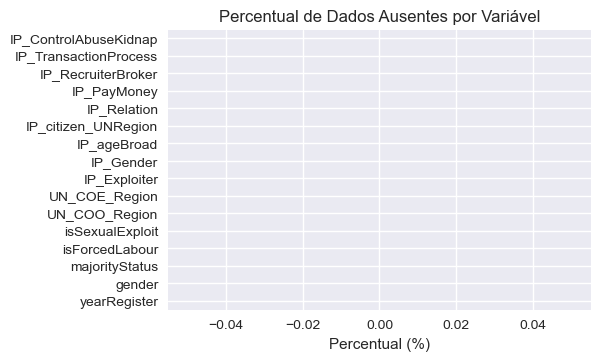

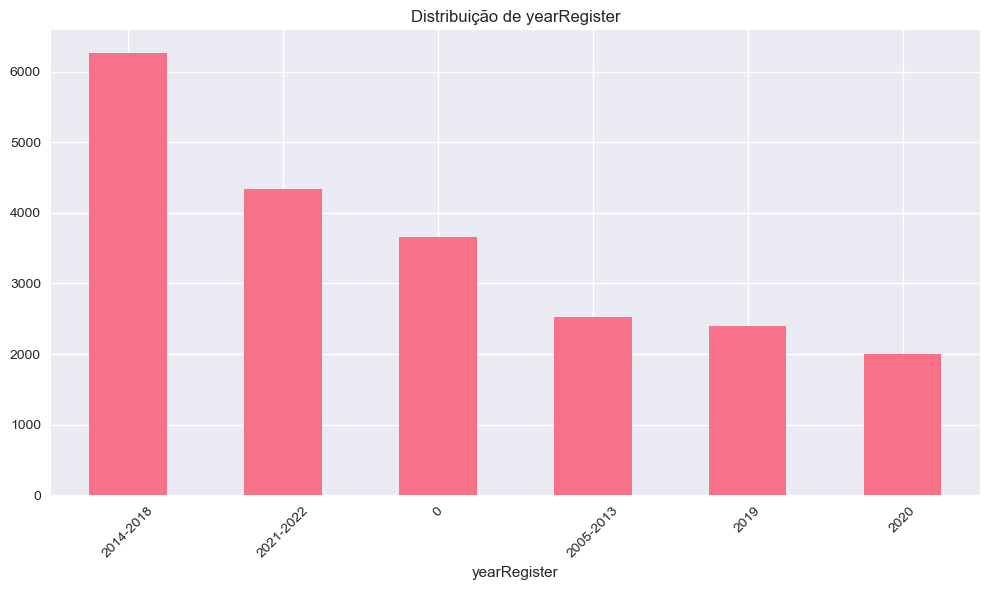


>>> gender
Valores únicos: 3
Valores mais frequentes:
gender
Female    9589
Male      7995
0         3611
Name: count, dtype: int64


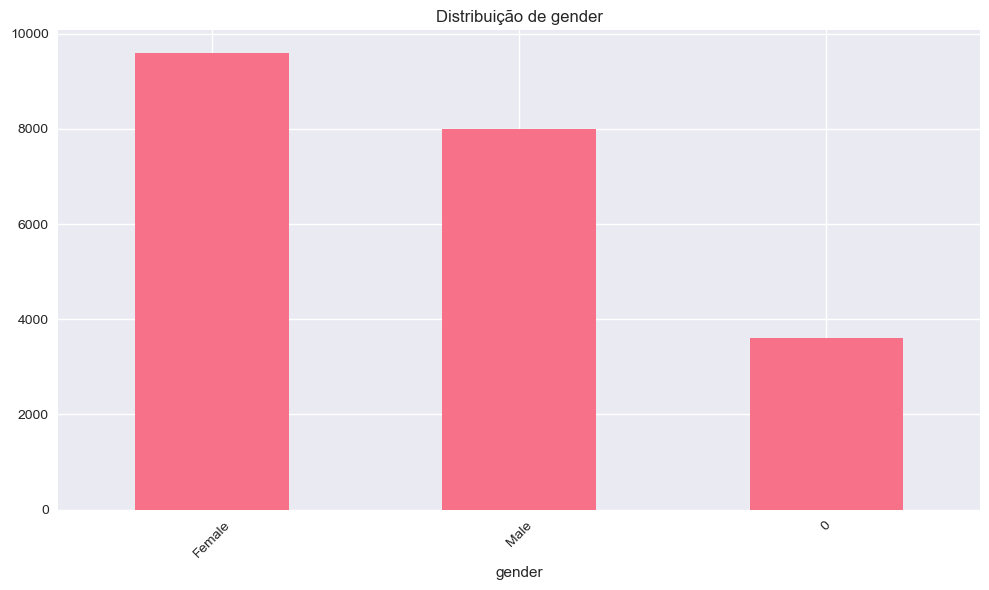


>>> majorityStatus
Valores únicos: 3
Valores mais frequentes:
majorityStatus
Adult    16379
0         3604
Minor     1212
Name: count, dtype: int64


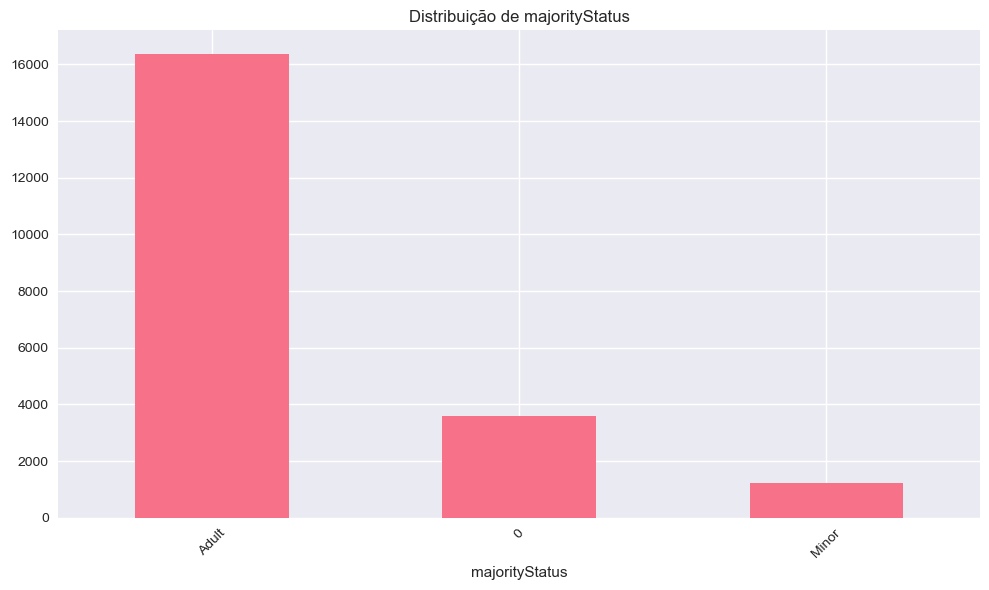


>>> UN_COO_Region
Valores únicos: 5
Valores mais frequentes:
UN_COO_Region
Asia                6139
Europe              5887
Africa              5282
0                   3610
Americas/Oceania     277
Name: count, dtype: int64


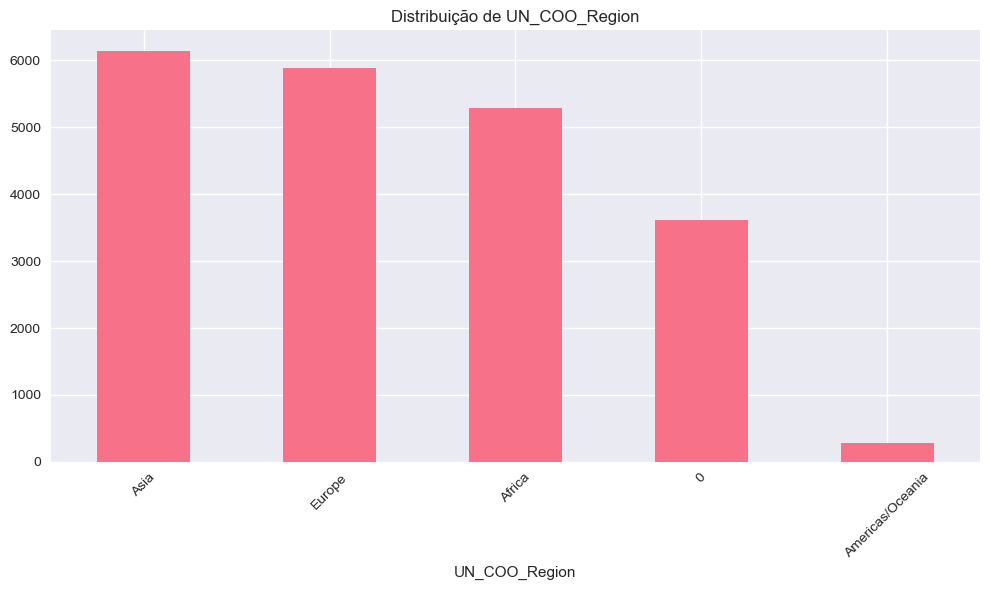


>>> UN_COE_Region
Valores únicos: 5
Valores mais frequentes:
UN_COE_Region
Europe              6432
Asia                6281
Africa              4271
0                   3999
Americas/Oceania     212
Name: count, dtype: int64


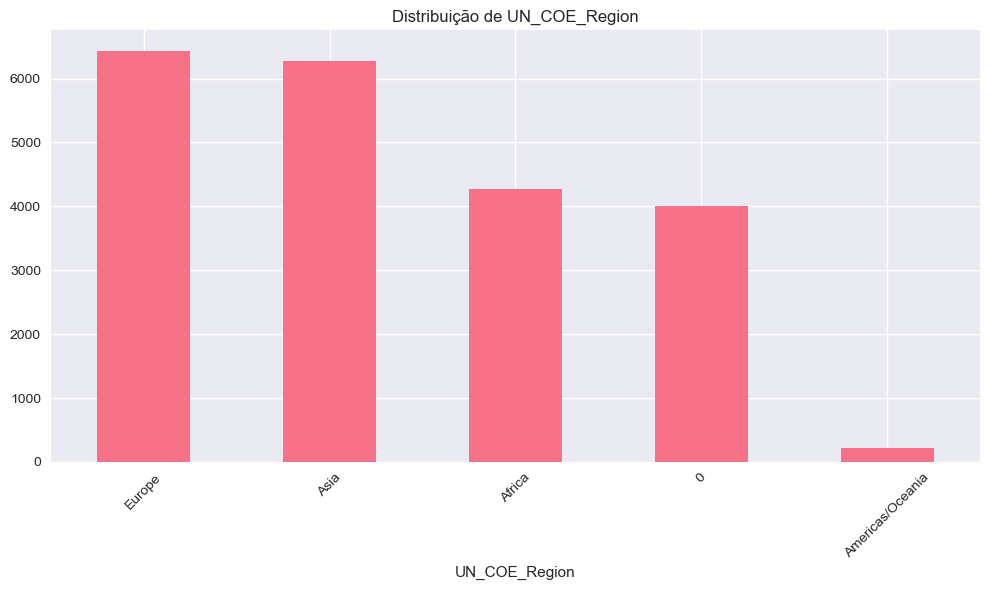


>>> IP_Gender
Valores únicos: 4
Valores mais frequentes:
IP_Gender
Male           9820
0              5408
Female         3515
Female;Male    2452
Name: count, dtype: int64


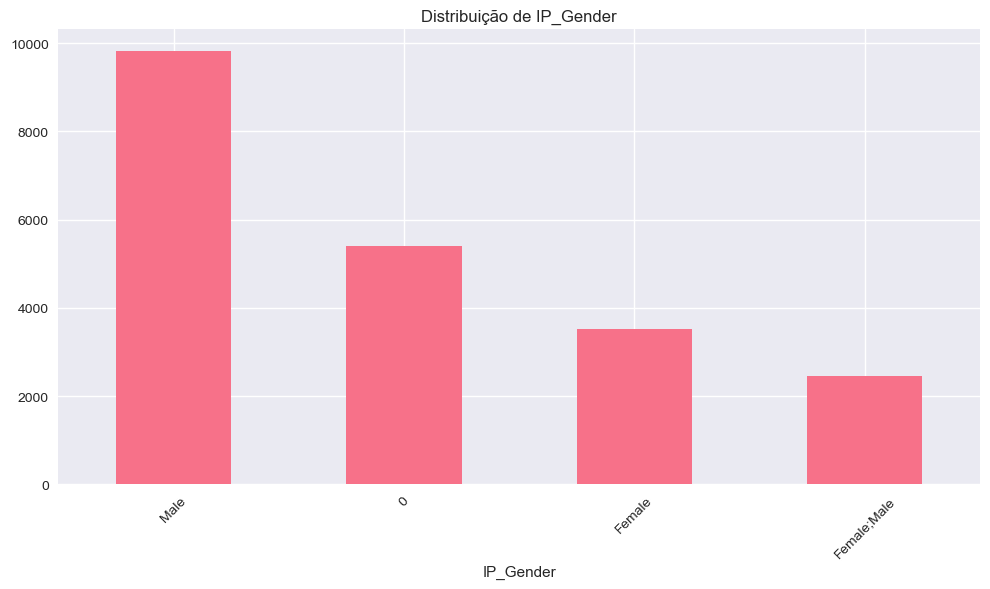


>>> IP_ageBroad
Valores únicos: 10
Valores mais frequentes:
IP_ageBroad
0         17993
39--47     1293
30--38     1196
48+         356
0--29       306
Name: count, dtype: int64


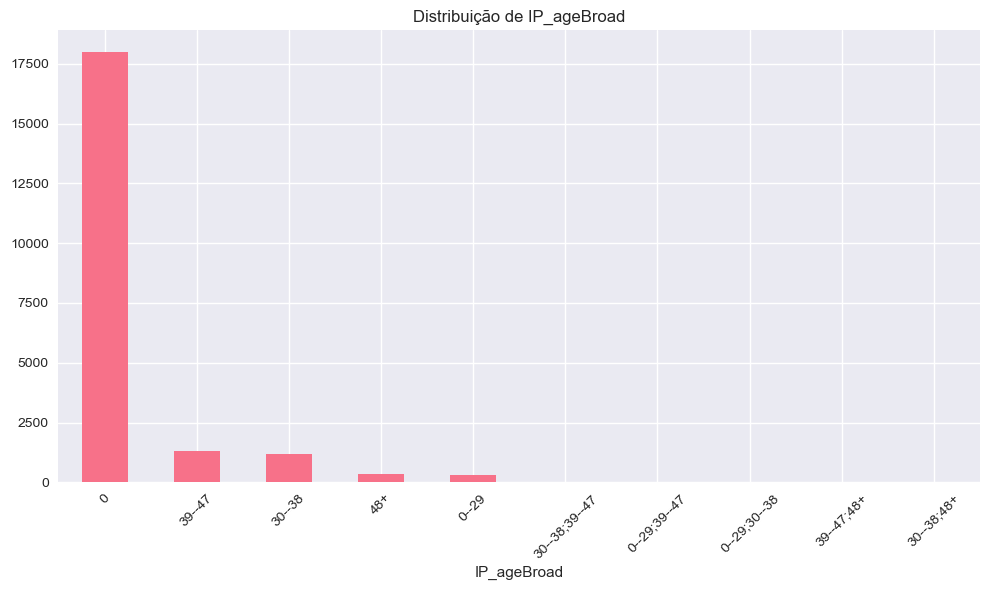


>>> IP_citizen_UNRegion
Valores únicos: 10
Valores mais frequentes:
IP_citizen_UNRegion
0              6946
Asia           5069
Europe         4368
Africa         3799
Africa;Asia     420
Name: count, dtype: int64


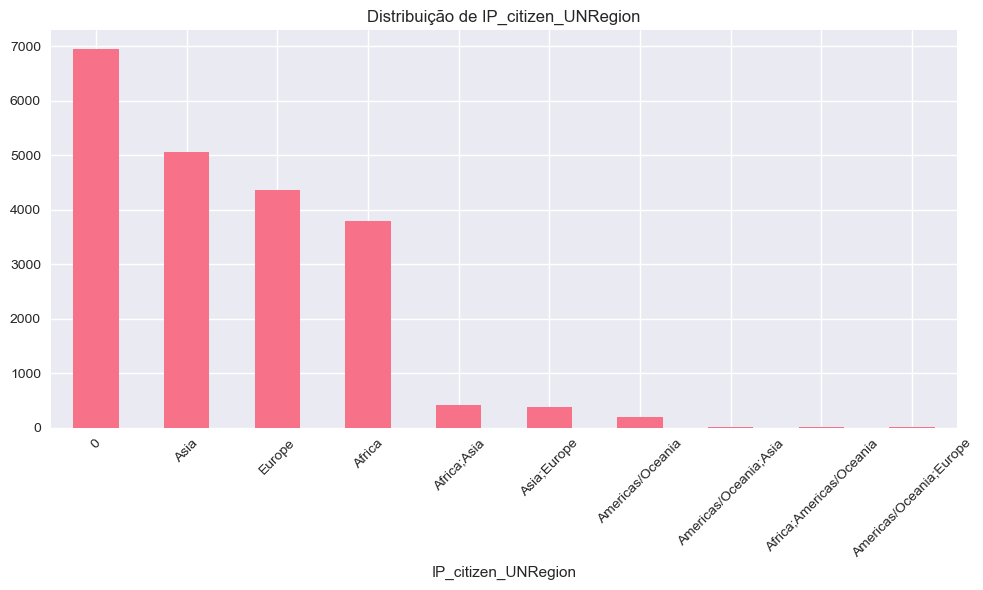


>>> IP_Relation
Valores únicos: 7
Valores mais frequentes:
IP_Relation
StrangerUnknownOther                       8321
0                                          6623
FriendAcquaintance                         4617
FamilyIntimatePartner                       967
FriendAcquaintance;StrangerUnknownOther     588
Name: count, dtype: int64


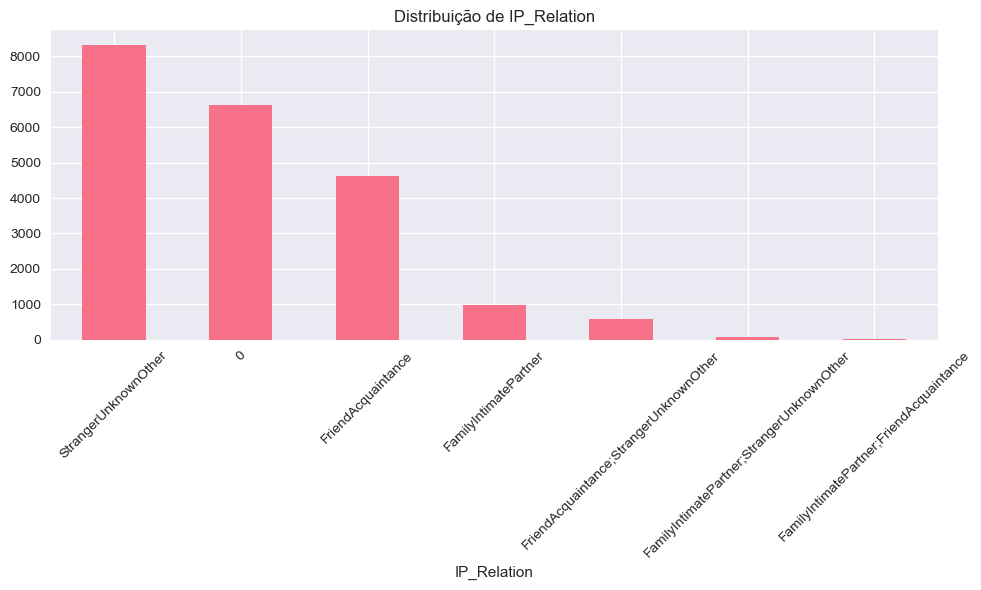


>>> IP_PayMoney
Valores únicos: 4
Valores mais frequentes:
IP_PayMoney
No        11075
0          6040
Yes        3136
No;Yes      944
Name: count, dtype: int64


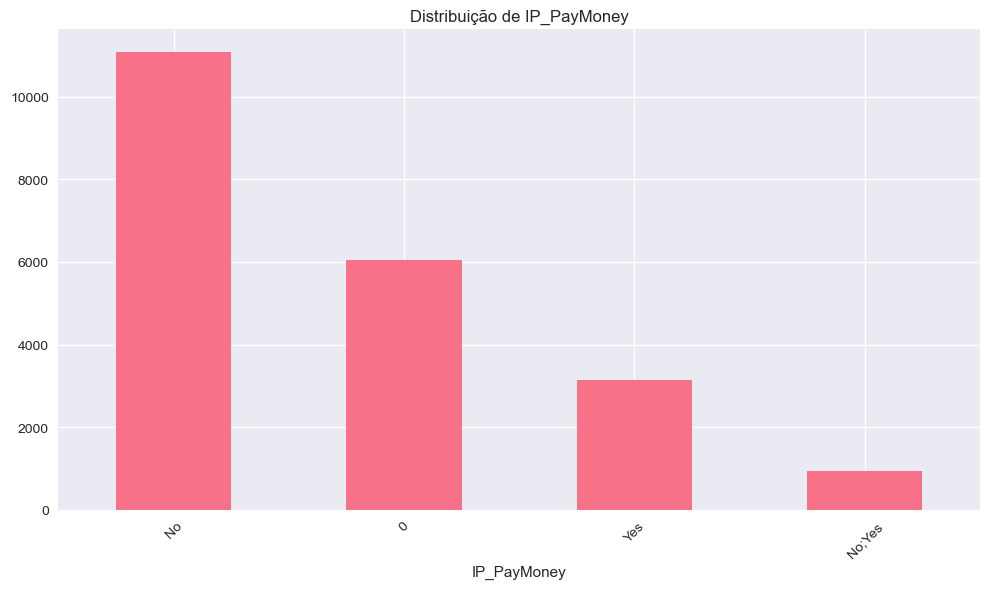


1.3 ANÁLISE DE VARIÁVEIS NUMÉRICAS
----------------------------------------

>>> isForcedLabour
Estatísticas descritivas:
count    21195.000000
mean         0.577872
std          0.493910
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: isForcedLabour, dtype: float64
Teste de Normalidade (Shapiro-Wilk): p-value = 0.0000
Distribuição Não-Normal


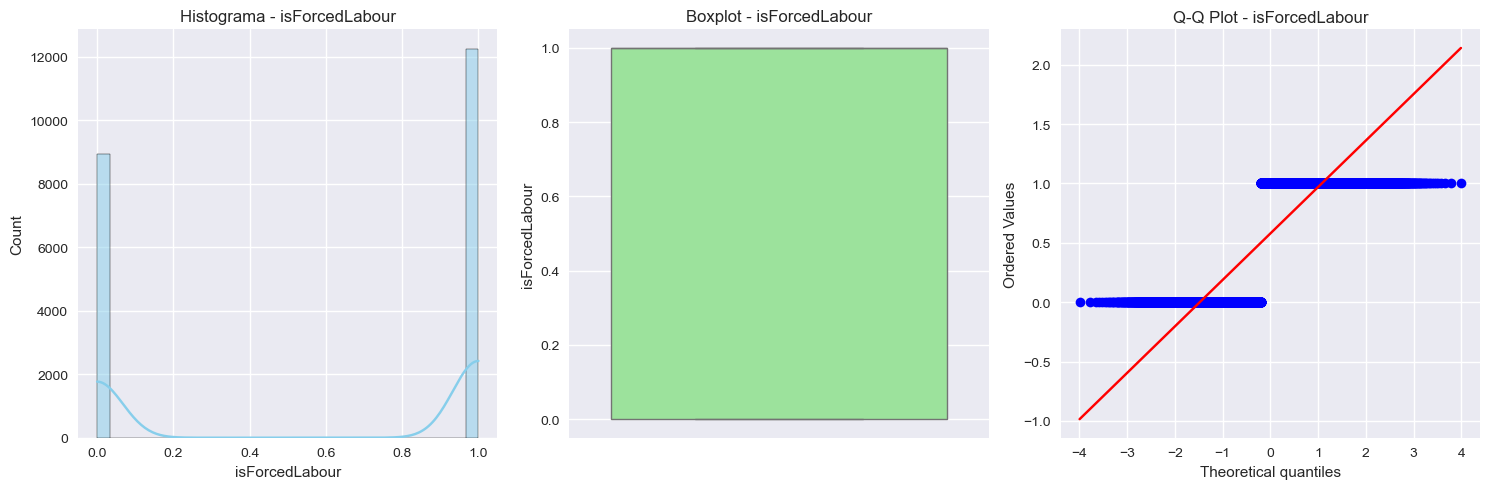


>>> isSexualExploit
Estatísticas descritivas:
count    21195.000000
mean         0.130927
std          0.337329
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: isSexualExploit, dtype: float64
Teste de Normalidade (Shapiro-Wilk): p-value = 0.0000
Distribuição Não-Normal


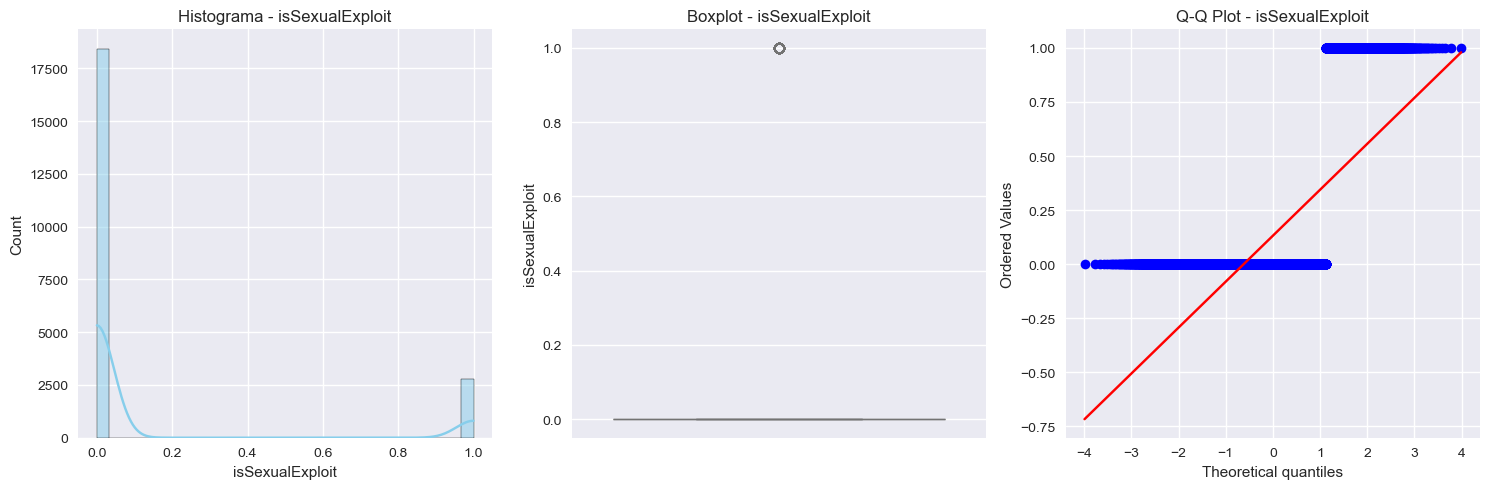


>>> IP_Exploiter
Estatísticas descritivas:
count    21195.000000
mean         0.446237
std          0.497113
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: IP_Exploiter, dtype: float64
Teste de Normalidade (Shapiro-Wilk): p-value = 0.0000
Distribuição Não-Normal


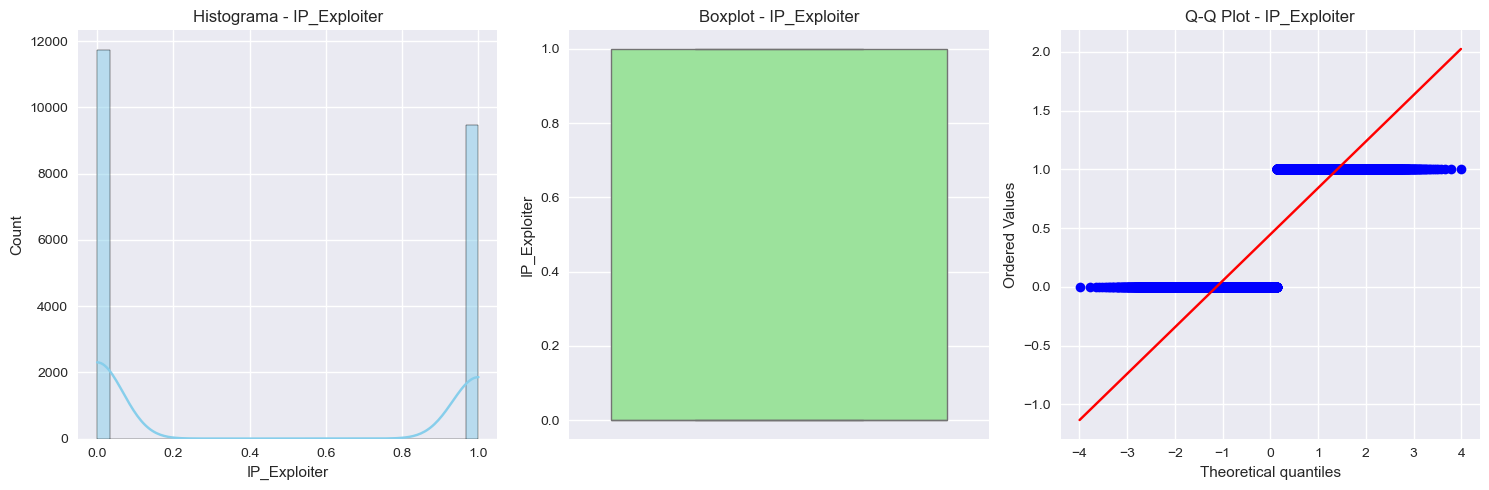


>>> IP_RecruiterBroker
Estatísticas descritivas:
count    21195.000000
mean         0.559802
std          0.496423
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: IP_RecruiterBroker, dtype: float64
Teste de Normalidade (Shapiro-Wilk): p-value = 0.0000
Distribuição Não-Normal


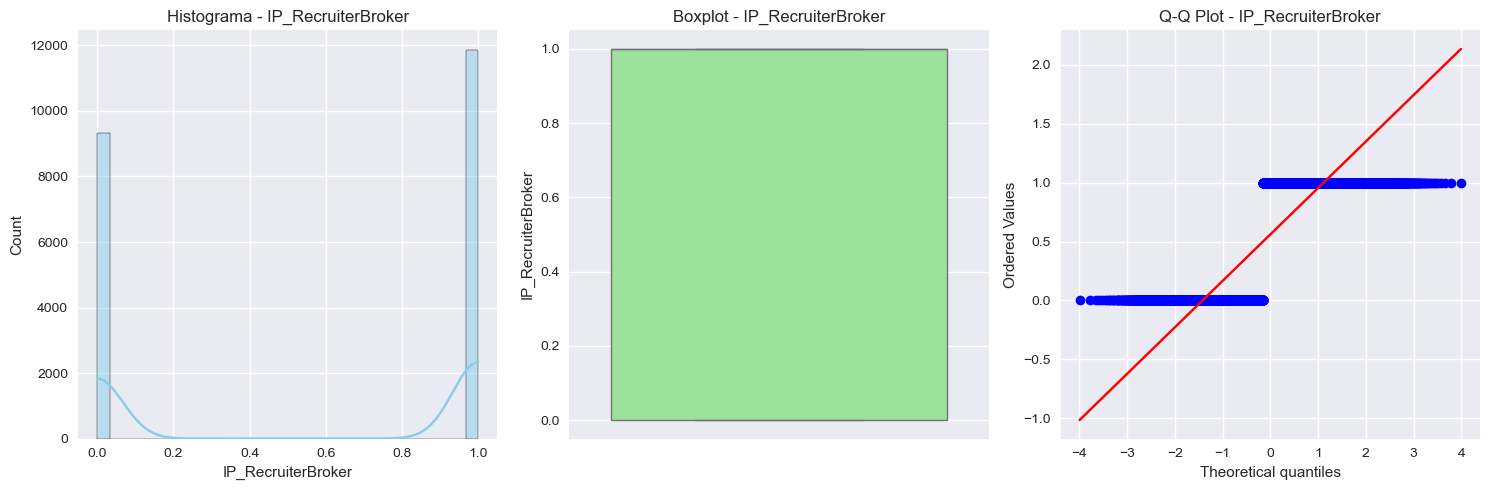


>>> IP_TransactionProcess
Estatísticas descritivas:
count    21195.000000
mean         0.346497
std          0.475865
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: IP_TransactionProcess, dtype: float64
Teste de Normalidade (Shapiro-Wilk): p-value = 0.0000
Distribuição Não-Normal


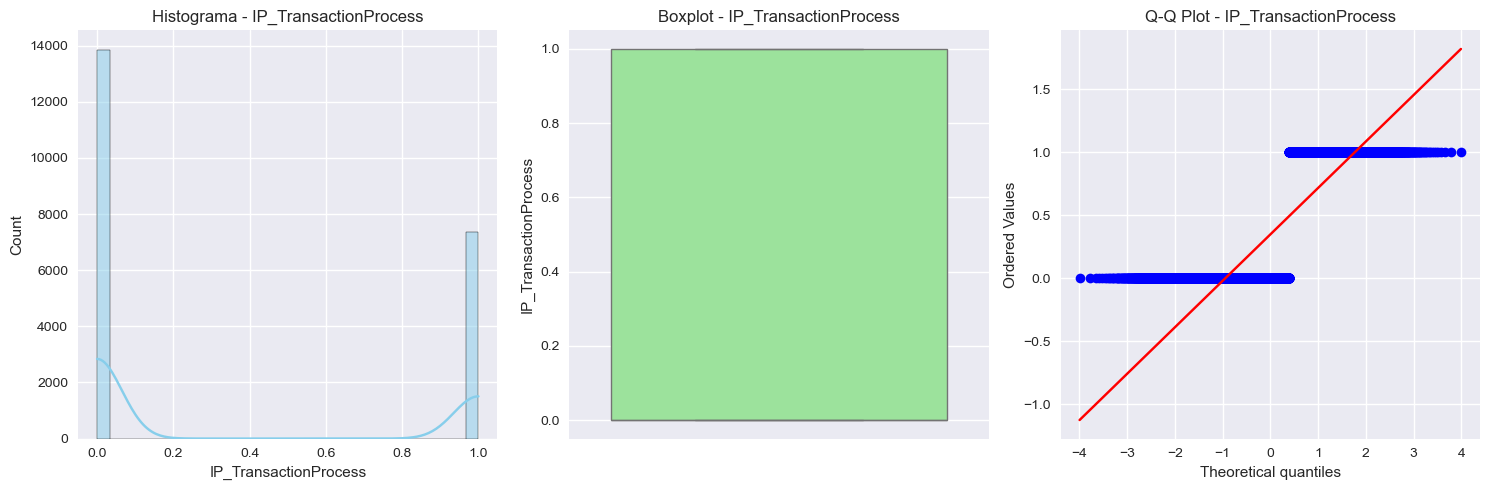


>>> IP_ControlAbuseKidnap
Estatísticas descritivas:
count    21195.000000
mean         0.098042
std          0.297378
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: IP_ControlAbuseKidnap, dtype: float64
Teste de Normalidade (Shapiro-Wilk): p-value = 0.0000
Distribuição Não-Normal


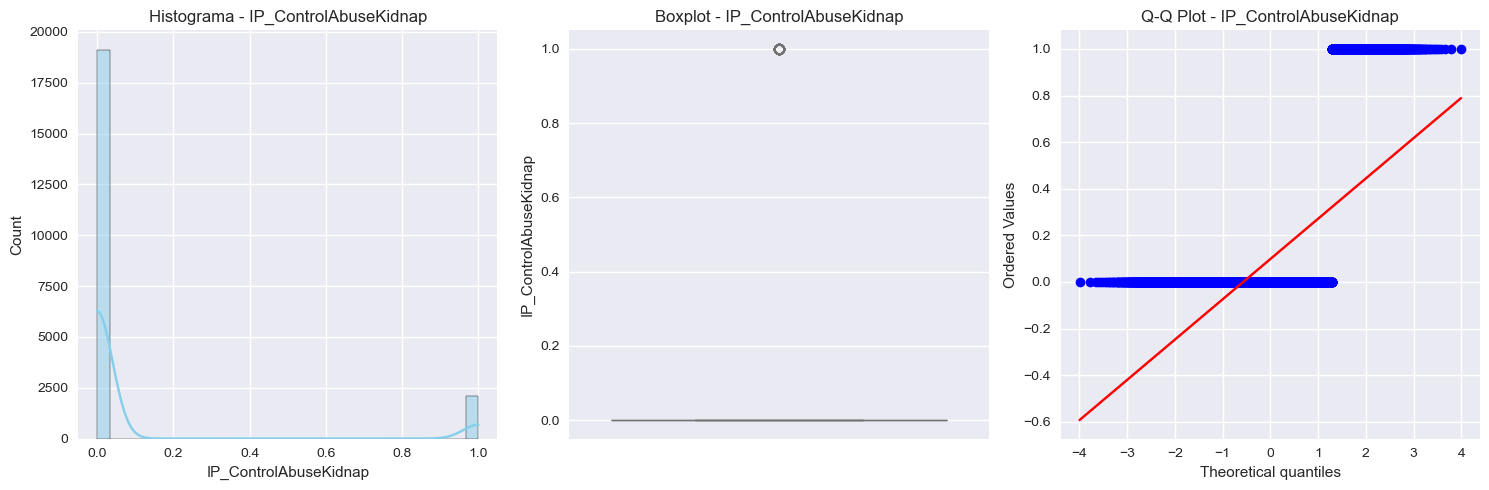

In [19]:
analise_univariada_completa(df=df)


ANÁLISE TEMPORAL
Registros por ano:
yearRegister
1970.0    3655
2019.0    2398
2020.0    2002
Name: count, dtype: int64


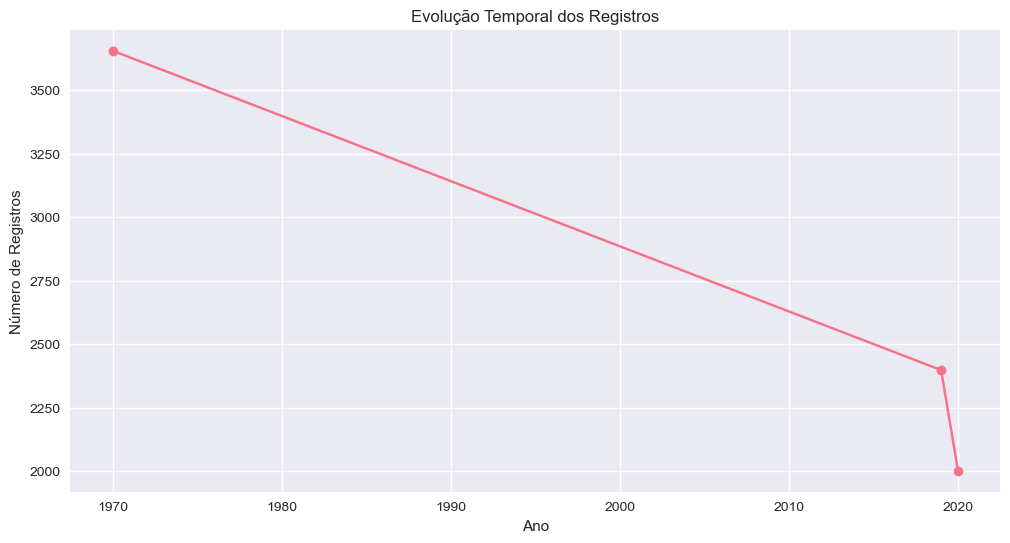

In [15]:
analise_temporal(df=df)


ANÁLISE TEMPORAL
Registros por ano:
yearRegister
1970.0    3655
2019.0    2398
2020.0    2002
Name: count, dtype: int64


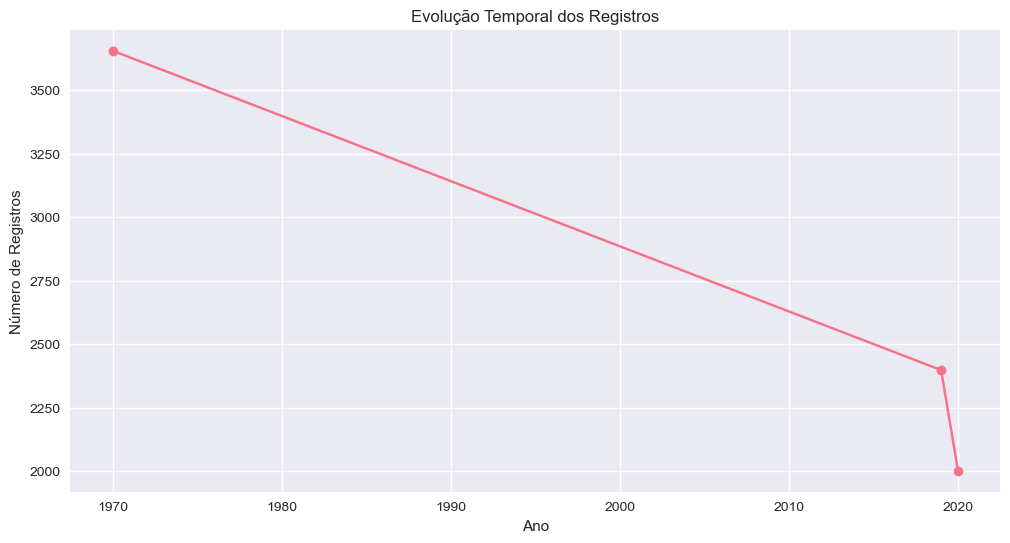

In [18]:
analise_temporal(df=df)

### Analise Bivariada


ANÁLISE BIVARIADA COMPLETA

2.1 MATRIZ DE CORRELAÇÃO - VARIÁVEIS NUMÉRICAS
--------------------------------------------------
                       isForcedLabour  isSexualExploit  IP_Exploiter  \
isForcedLabour               1.000000        -0.355862      0.217245   
isSexualExploit             -0.355862         1.000000      0.023548   
IP_Exploiter                 0.217245         0.023548      1.000000   
IP_RecruiterBroker           0.342257        -0.029712      0.327978   
IP_TransactionProcess        0.082530         0.032471      0.052424   
IP_ControlAbuseKidnap       -0.065153        -0.024490      0.103321   

                       IP_RecruiterBroker  IP_TransactionProcess  \
isForcedLabour                   0.342257               0.082530   
isSexualExploit                 -0.029712               0.032471   
IP_Exploiter                     0.327978               0.052424   
IP_RecruiterBroker               1.000000              -0.014817   
IP_TransactionProcess       

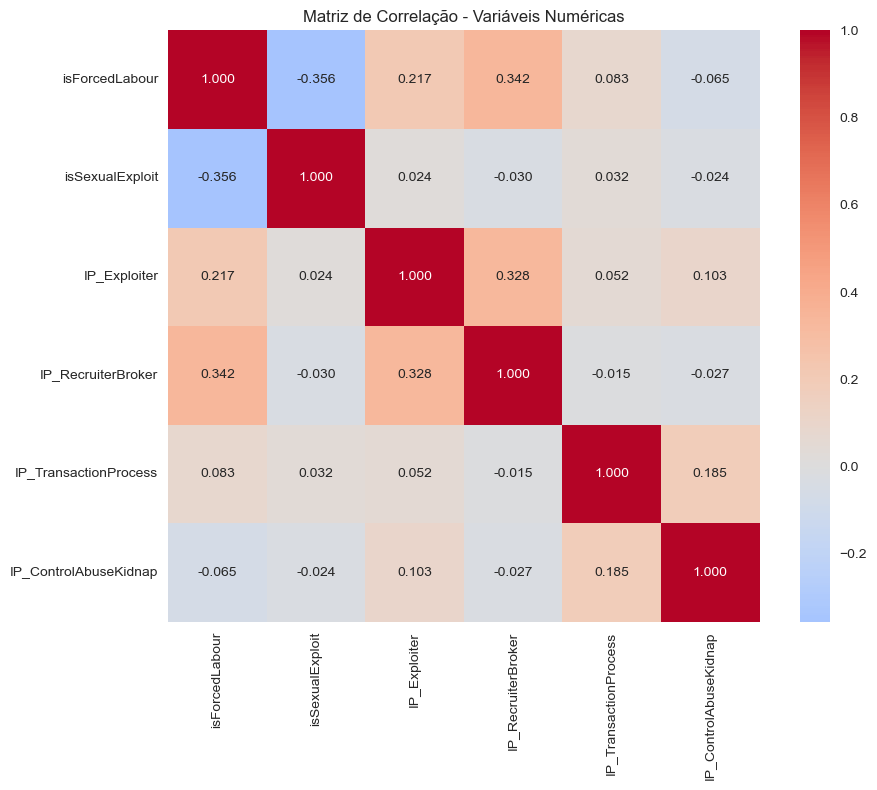


Correlações mais fortes (|r| > 0.3):
isForcedLabour x isSexualExploit: -0.356
isForcedLabour x IP_RecruiterBroker: 0.342
IP_Exploiter x IP_RecruiterBroker: 0.328

2.2 ANÁLISE CATEGÓRICA vs CATEGÓRICA
--------------------------------------------------

>>> yearRegister x gender
Chi-quadrado: 466.2718
p-value: 0.0000
Associação Significativa
Cramér's V: 0.1049


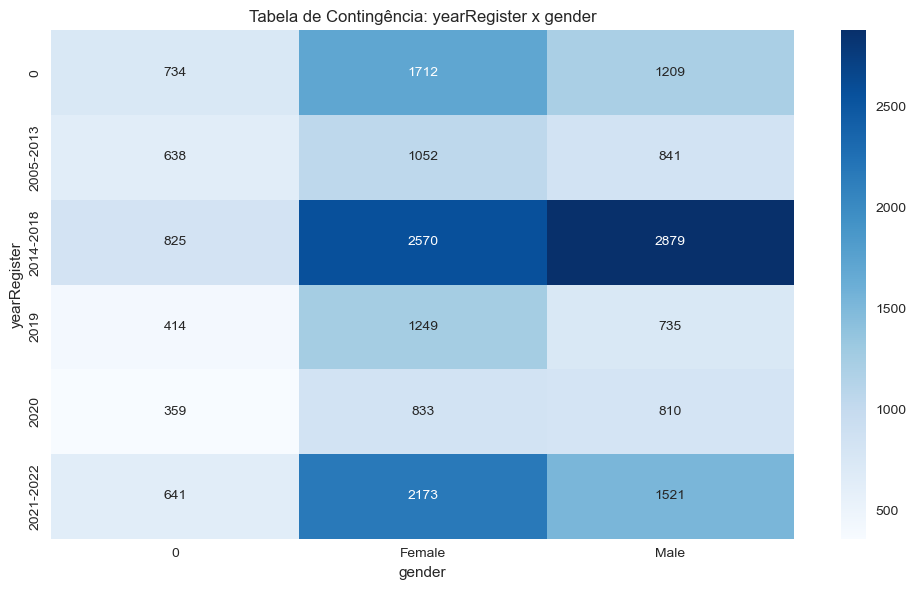


>>> yearRegister x majorityStatus
Chi-quadrado: 461.7616
p-value: 0.0000
Associação Significativa
Cramér's V: 0.1044


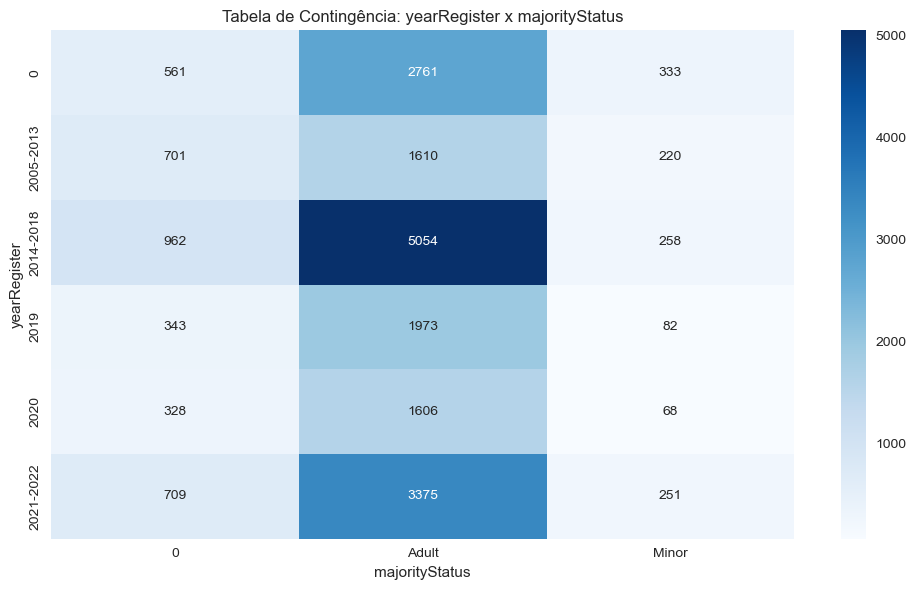


>>> yearRegister x UN_COO_Region
Chi-quadrado: 4657.5178
p-value: 0.0000
Associação Significativa
Cramér's V: 0.2344


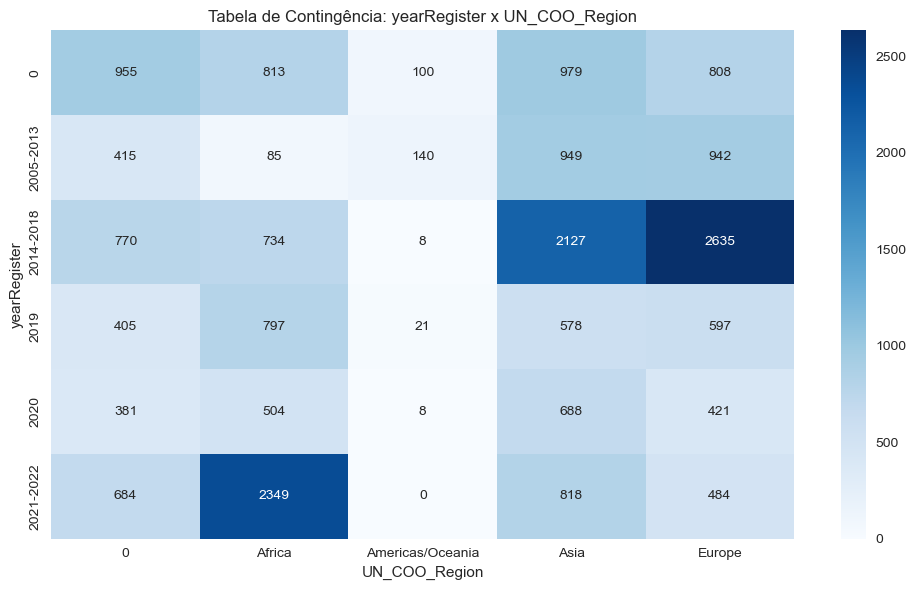


>>> yearRegister x UN_COE_Region
Chi-quadrado: 3713.7000
p-value: 0.0000
Associação Significativa
Cramér's V: 0.2093


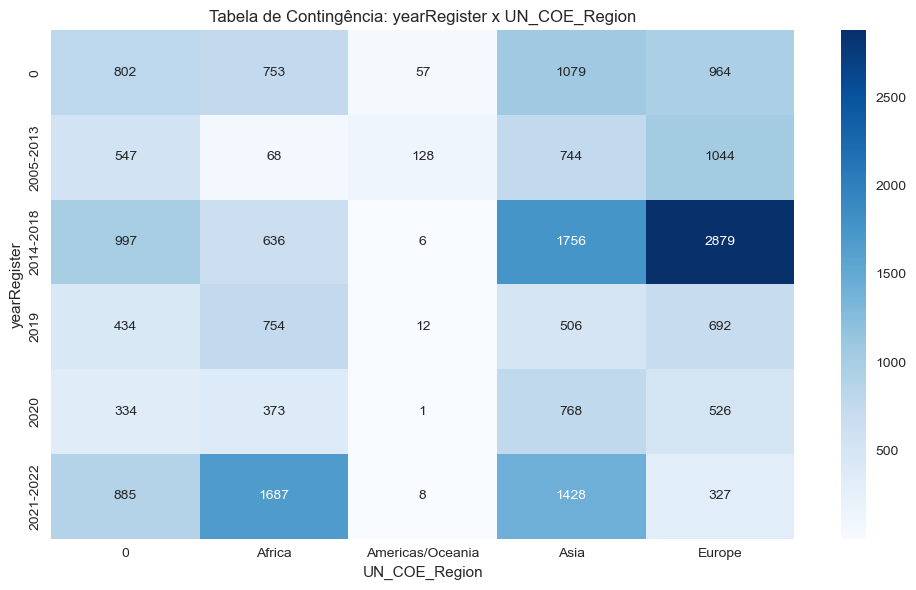


>>> yearRegister x IP_Gender
Chi-quadrado: 1210.8818
p-value: 0.0000
Associação Significativa
Cramér's V: 0.1380


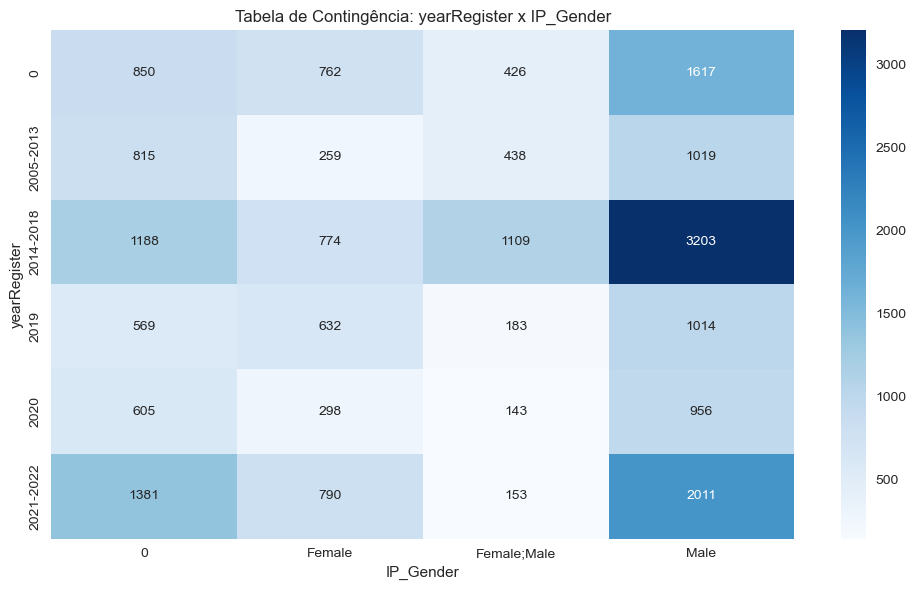


>>> yearRegister x IP_ageBroad
Chi-quadrado: 2175.1382
p-value: 0.0000
Associação Significativa
Cramér's V: 0.1433


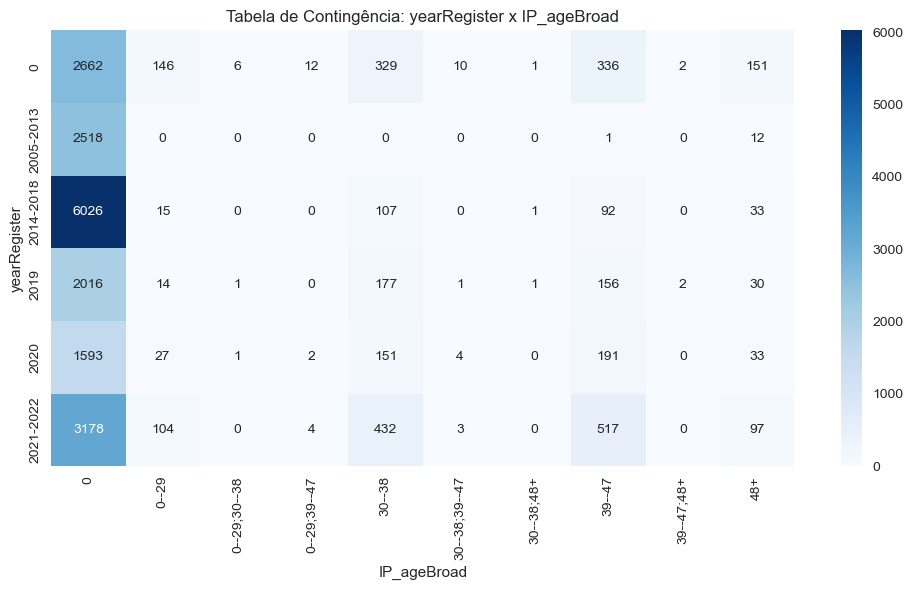


>>> yearRegister x IP_citizen_UNRegion
Chi-quadrado: 3844.5876
p-value: 0.0000
Associação Significativa
Cramér's V: 0.1905


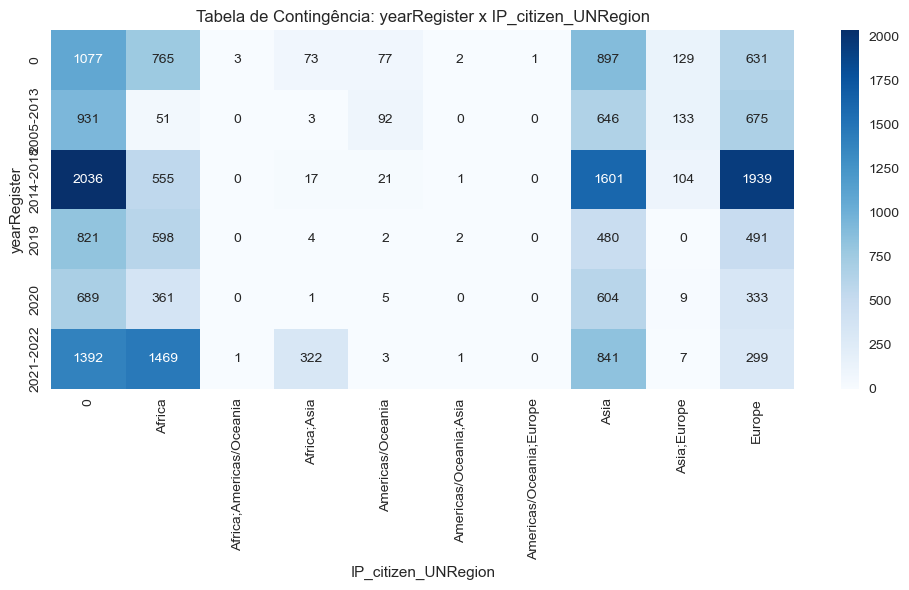


>>> yearRegister x IP_Relation
Chi-quadrado: 3551.0909
p-value: 0.0000
Associação Significativa
Cramér's V: 0.1831


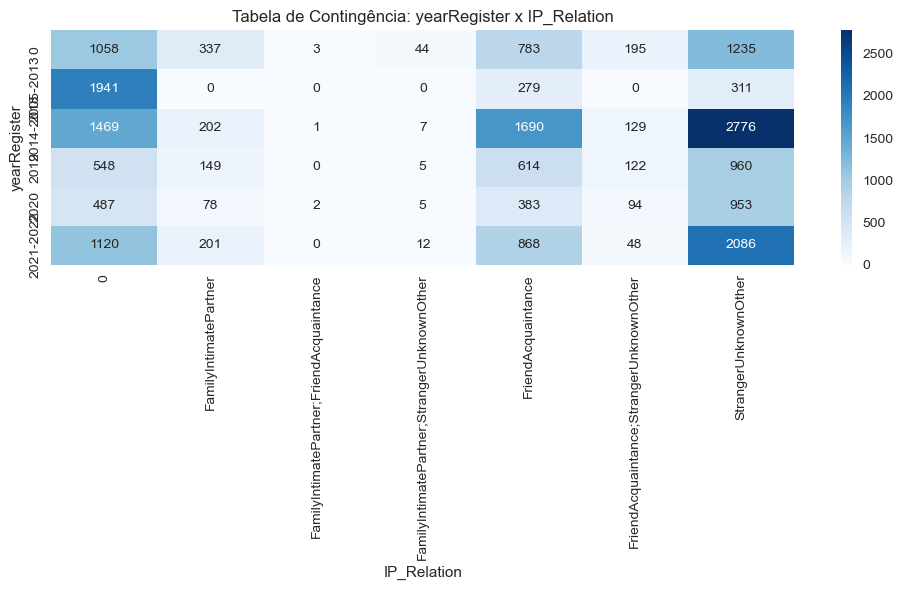


>>> yearRegister x IP_PayMoney
Chi-quadrado: 3090.6211
p-value: 0.0000
Associação Significativa
Cramér's V: 0.2205


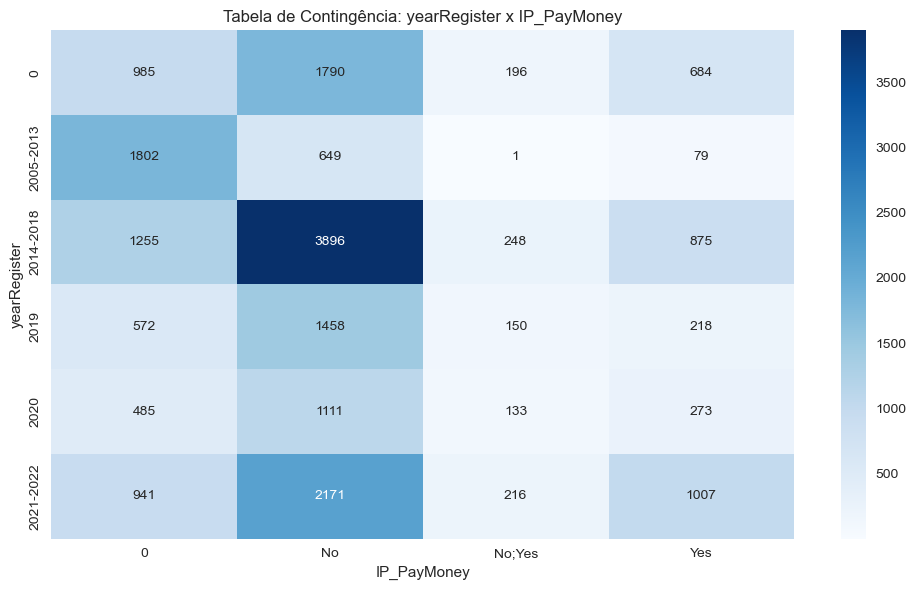


>>> gender x majorityStatus
Chi-quadrado: 3138.3885
p-value: 0.0000
Associação Significativa
Cramér's V: 0.2721


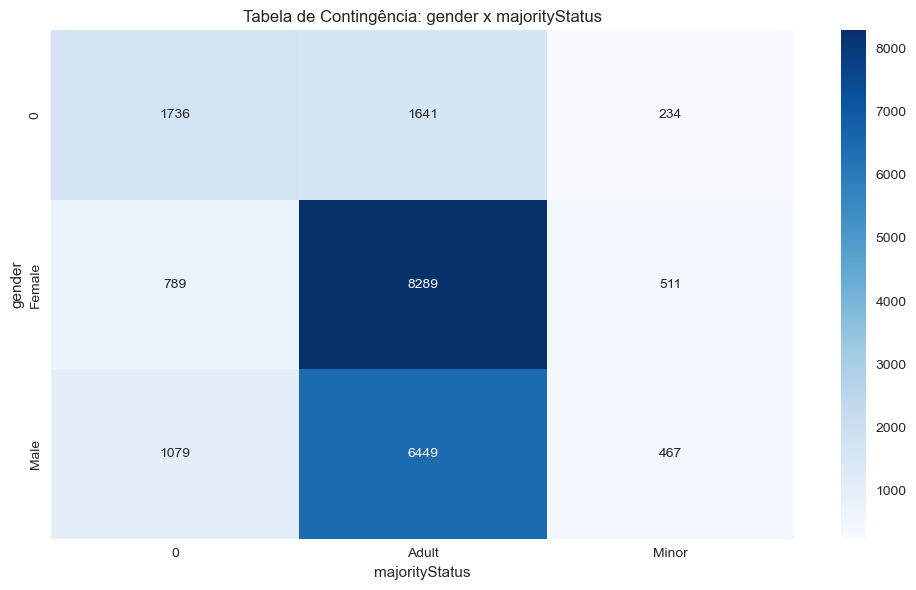


>>> gender x UN_COO_Region
Chi-quadrado: 1782.2072
p-value: 0.0000
Associação Significativa
Cramér's V: 0.2050


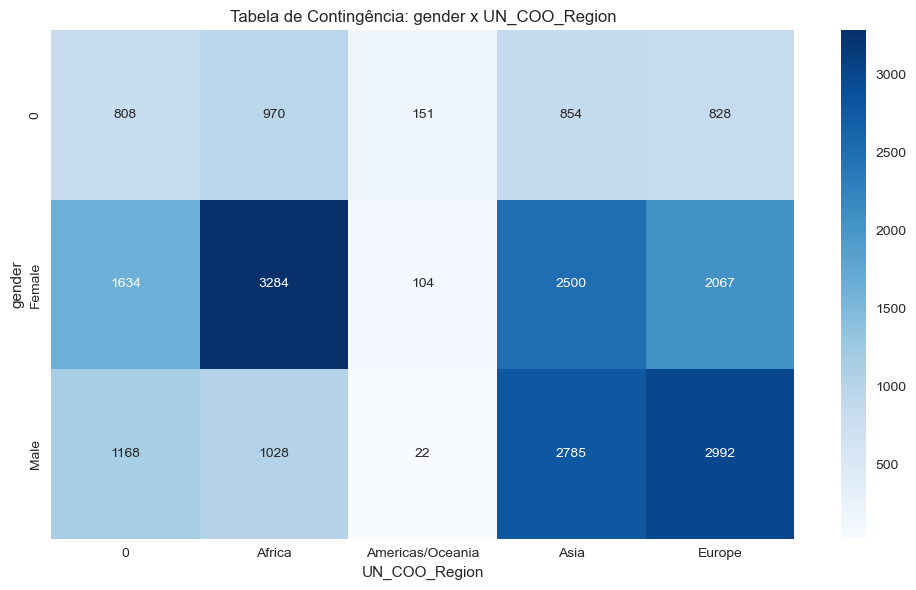


>>> gender x UN_COE_Region
Chi-quadrado: 1675.0321
p-value: 0.0000
Associação Significativa
Cramér's V: 0.1988


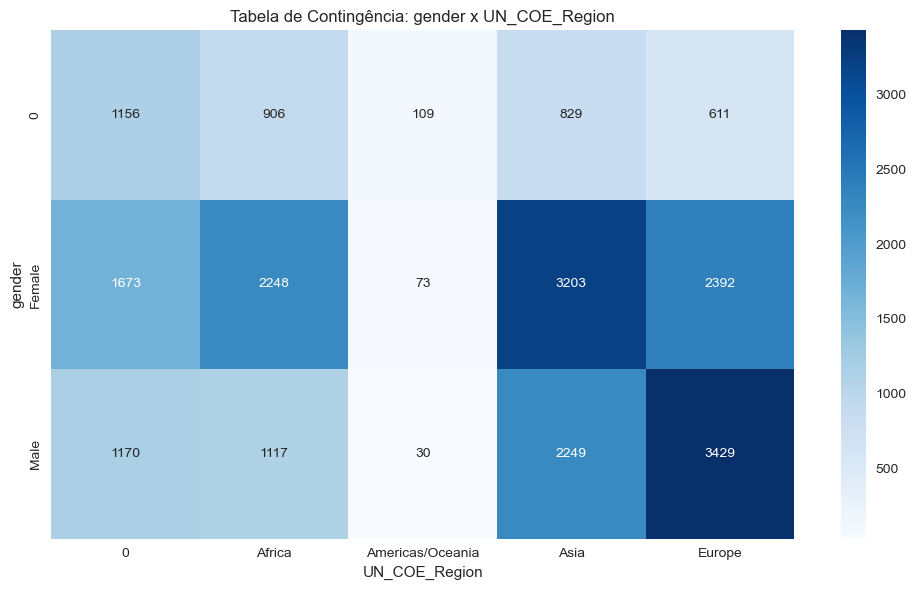


>>> gender x IP_Gender
Chi-quadrado: 5108.6716
p-value: 0.0000
Associação Significativa
Cramér's V: 0.3472


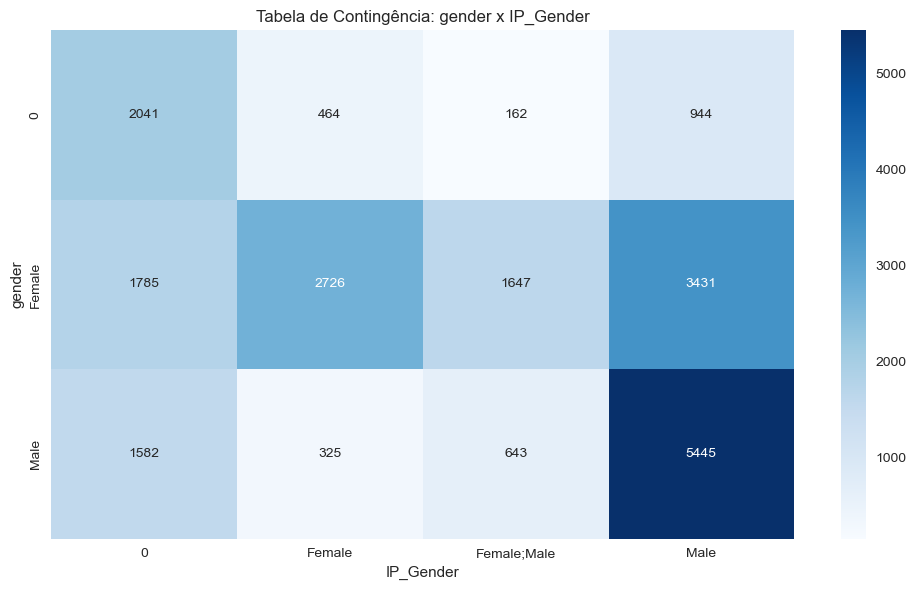


>>> gender x IP_ageBroad
Chi-quadrado: 399.0435
p-value: 0.0000
Associação Significativa
Cramér's V: 0.0970


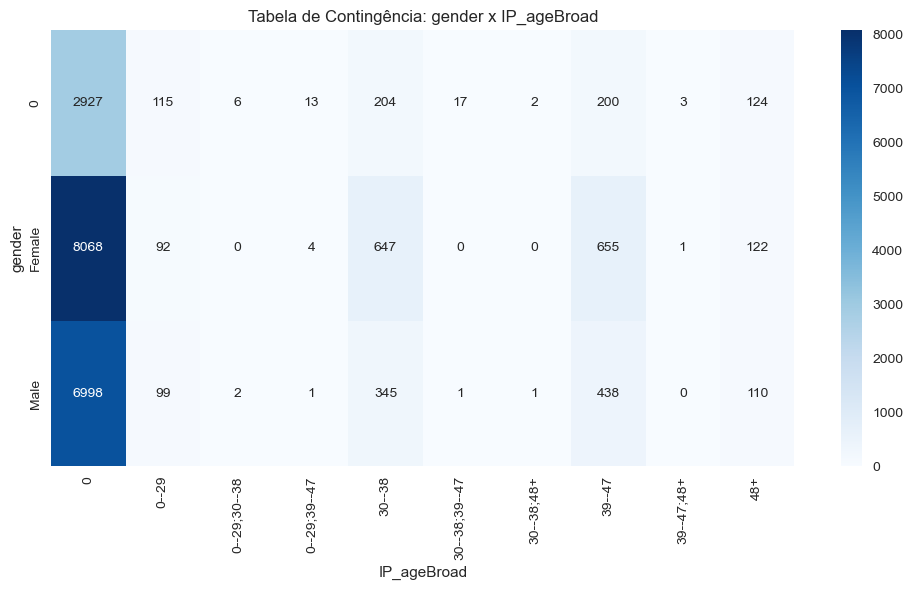


>>> gender x IP_citizen_UNRegion
Chi-quadrado: 2963.8538
p-value: 0.0000
Associação Significativa
Cramér's V: 0.2644


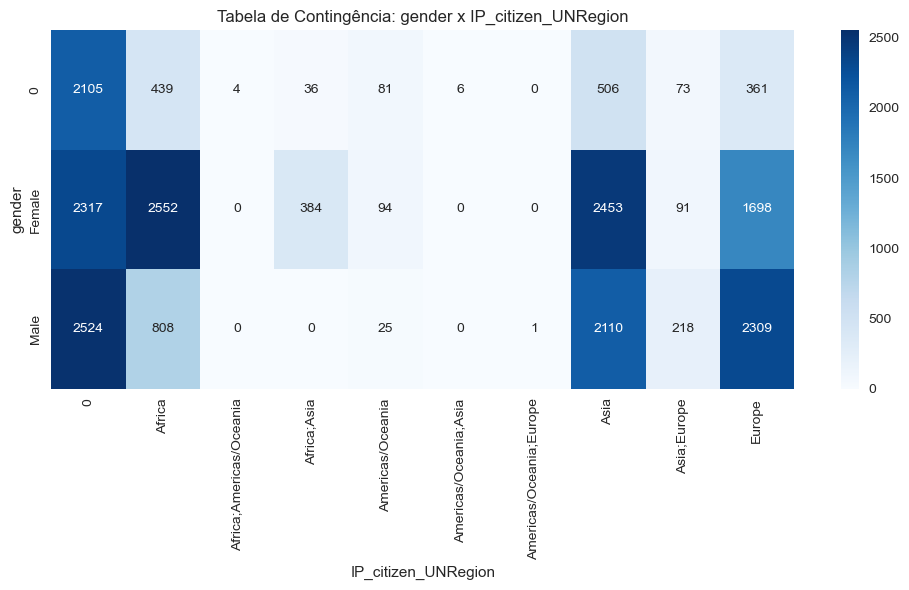


>>> gender x IP_Relation
Chi-quadrado: 1920.1316
p-value: 0.0000
Associação Significativa
Cramér's V: 0.2128


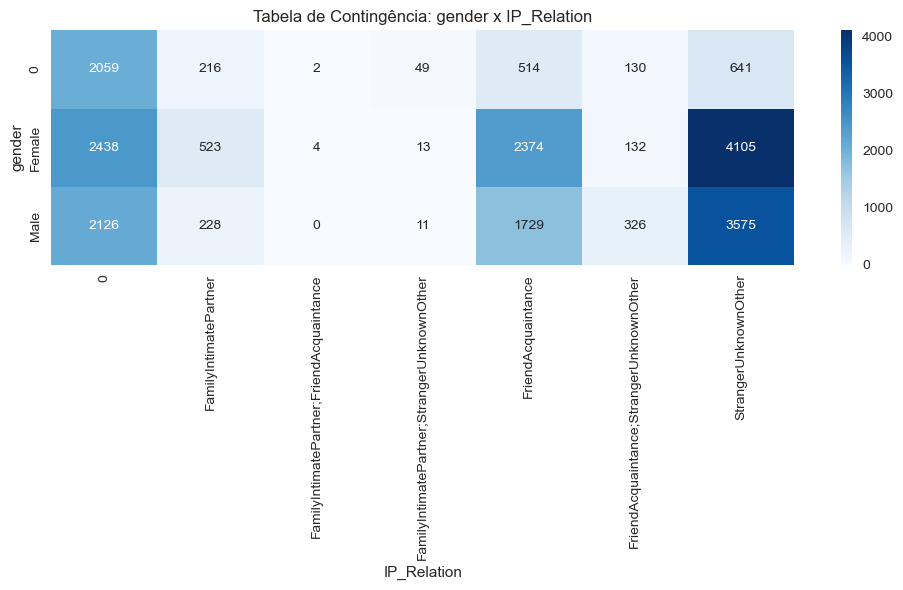


>>> gender x IP_PayMoney
Chi-quadrado: 2023.8934
p-value: 0.0000
Associação Significativa
Cramér's V: 0.2185


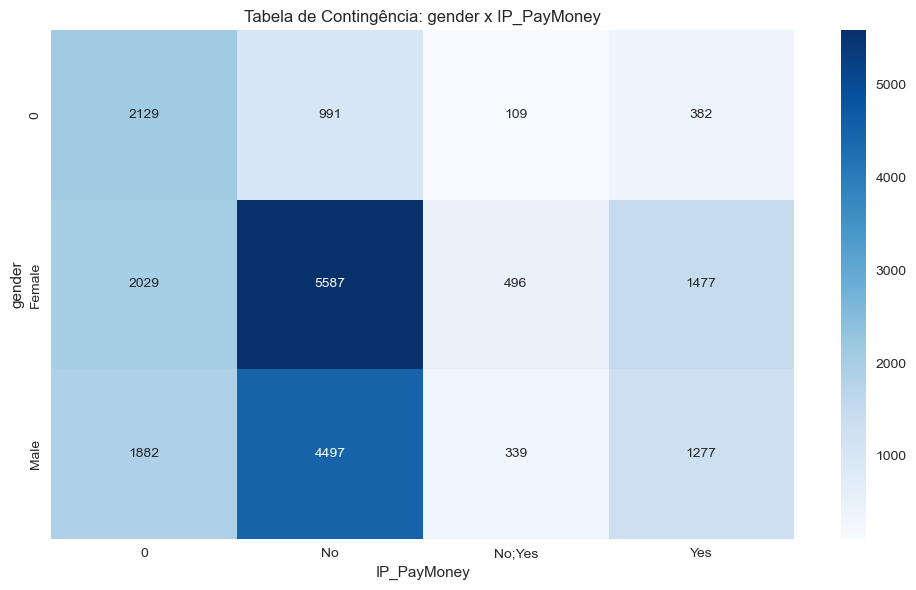


>>> majorityStatus x UN_COO_Region
Chi-quadrado: 657.3527
p-value: 0.0000
Associação Significativa
Cramér's V: 0.1245


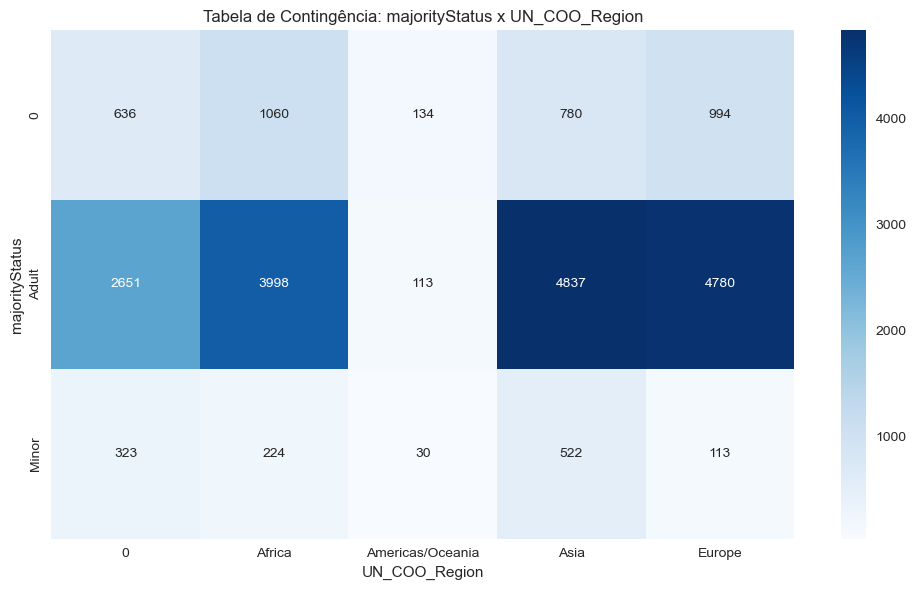


>>> majorityStatus x UN_COE_Region
Chi-quadrado: 934.5344
p-value: 0.0000
Associação Significativa
Cramér's V: 0.1485


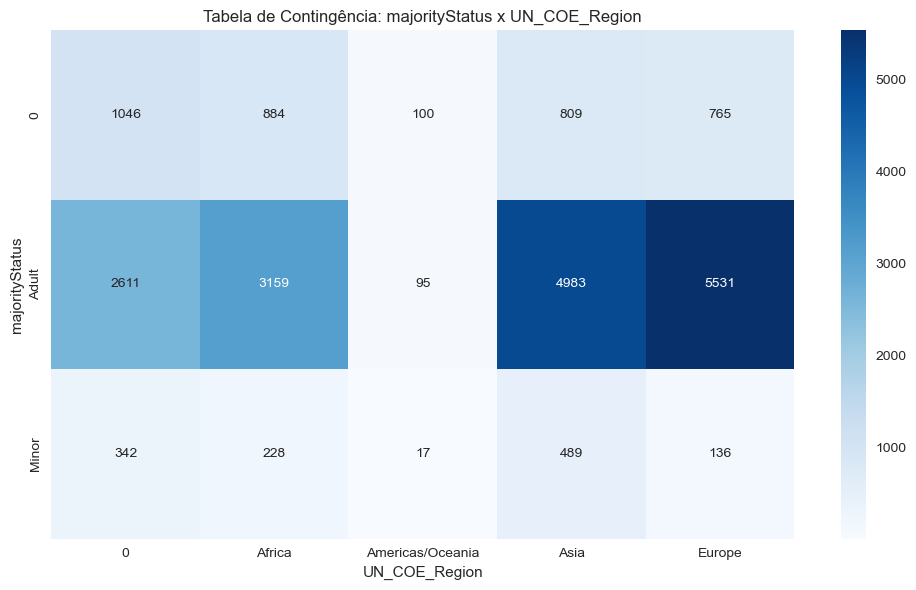


>>> majorityStatus x IP_Gender
Chi-quadrado: 5260.9583
p-value: 0.0000
Associação Significativa
Cramér's V: 0.3523


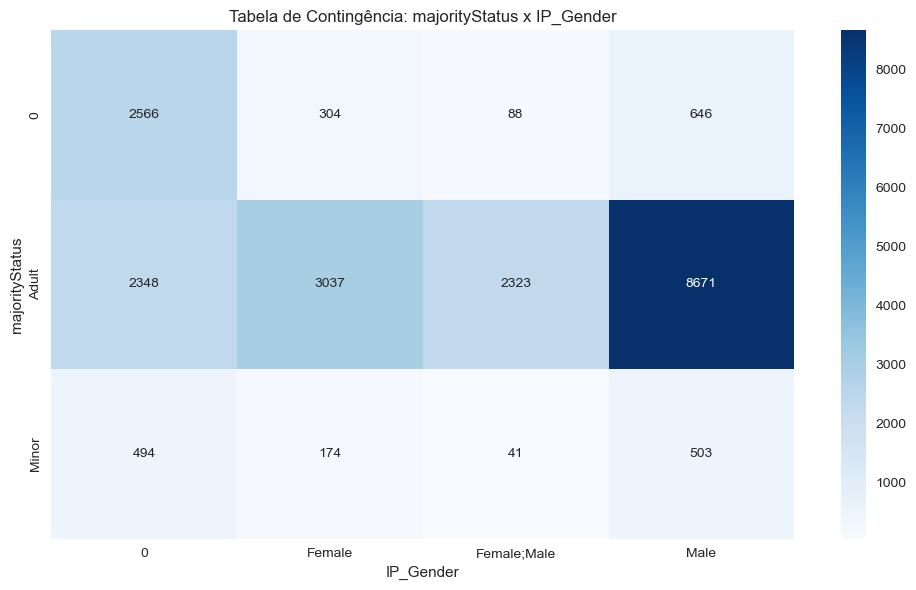


>>> majorityStatus x IP_ageBroad
Chi-quadrado: 617.9260
p-value: 0.0000
Associação Significativa
Cramér's V: 0.1207


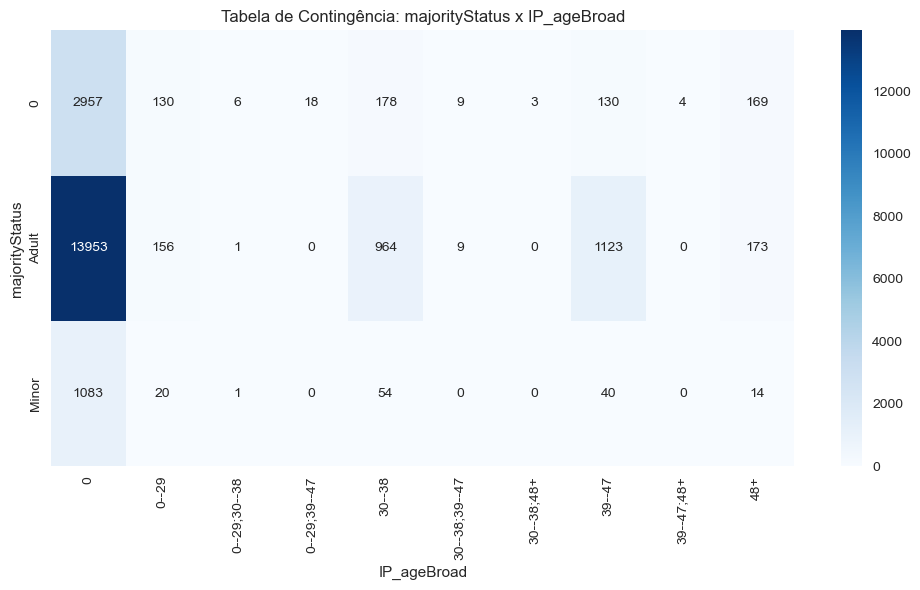


>>> majorityStatus x IP_citizen_UNRegion
Chi-quadrado: 3299.1742
p-value: 0.0000
Associação Significativa
Cramér's V: 0.2790


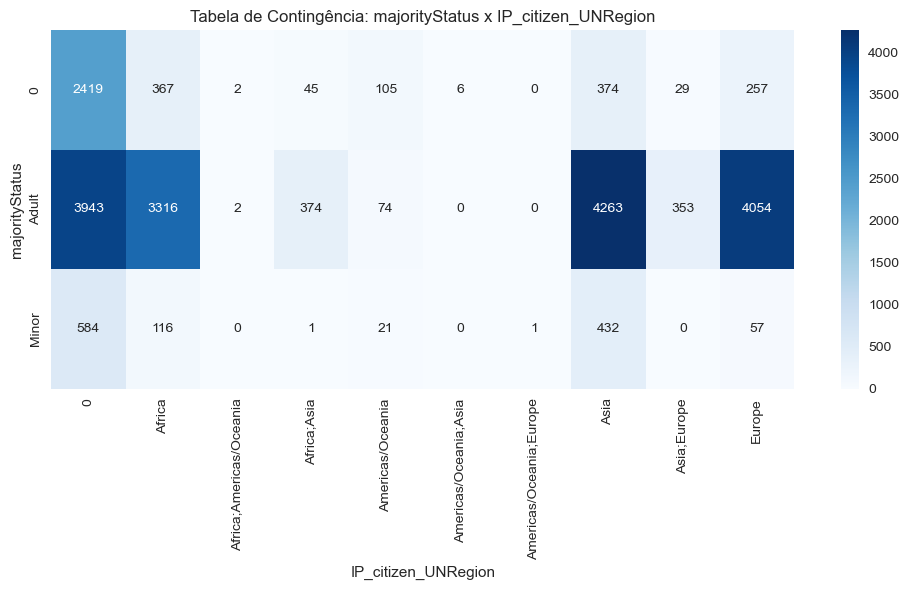


>>> majorityStatus x IP_Relation
Chi-quadrado: 4545.1367
p-value: 0.0000
Associação Significativa
Cramér's V: 0.3274


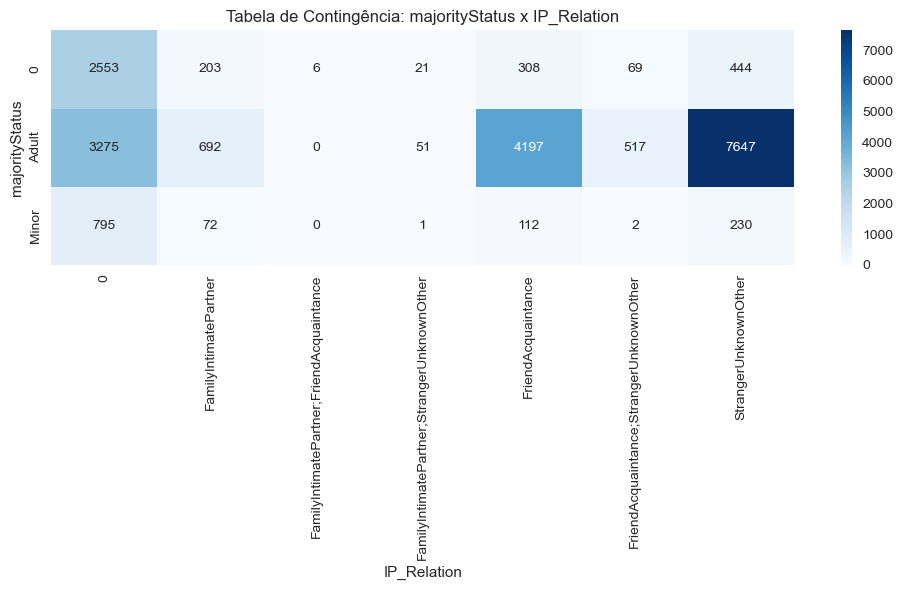


>>> majorityStatus x IP_PayMoney
Chi-quadrado: 4899.4926
p-value: 0.0000
Associação Significativa
Cramér's V: 0.3400


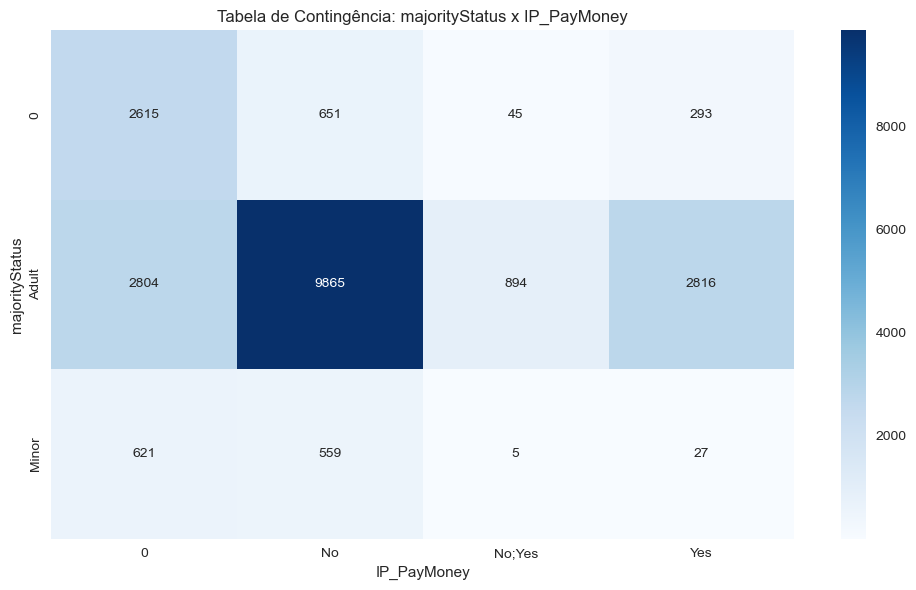


>>> UN_COO_Region x UN_COE_Region
Chi-quadrado: 24372.0036
p-value: 0.0000
Associação Significativa
Cramér's V: 0.5362


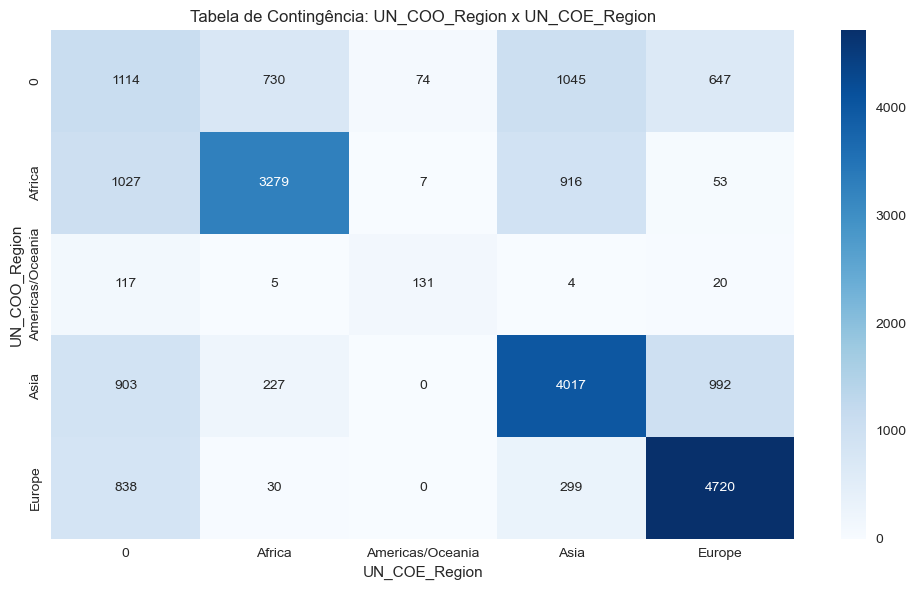


>>> UN_COO_Region x IP_Gender
Chi-quadrado: 2437.4934
p-value: 0.0000
Associação Significativa
Cramér's V: 0.1958


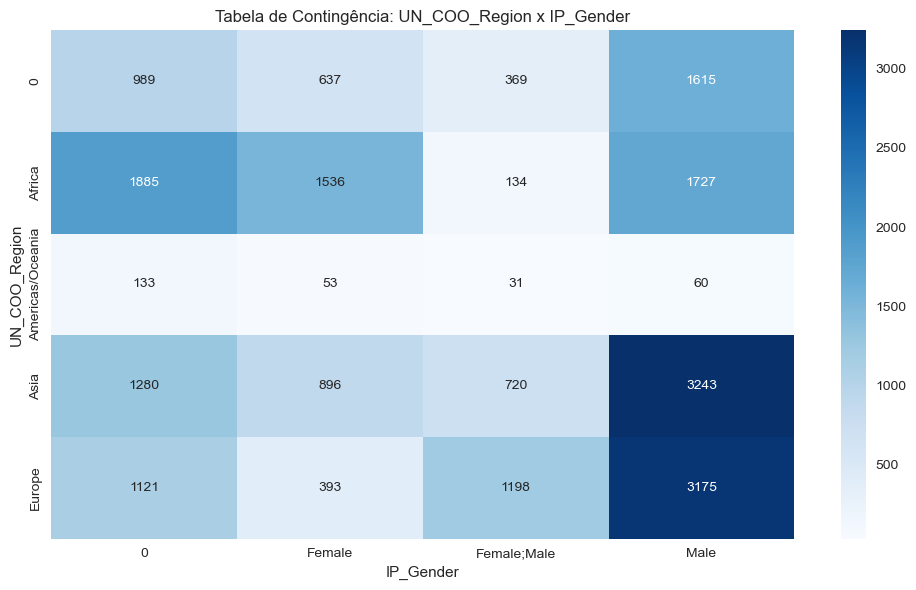


>>> UN_COO_Region x IP_ageBroad
Chi-quadrado: 1662.7581
p-value: 0.0000
Associação Significativa
Cramér's V: 0.1400


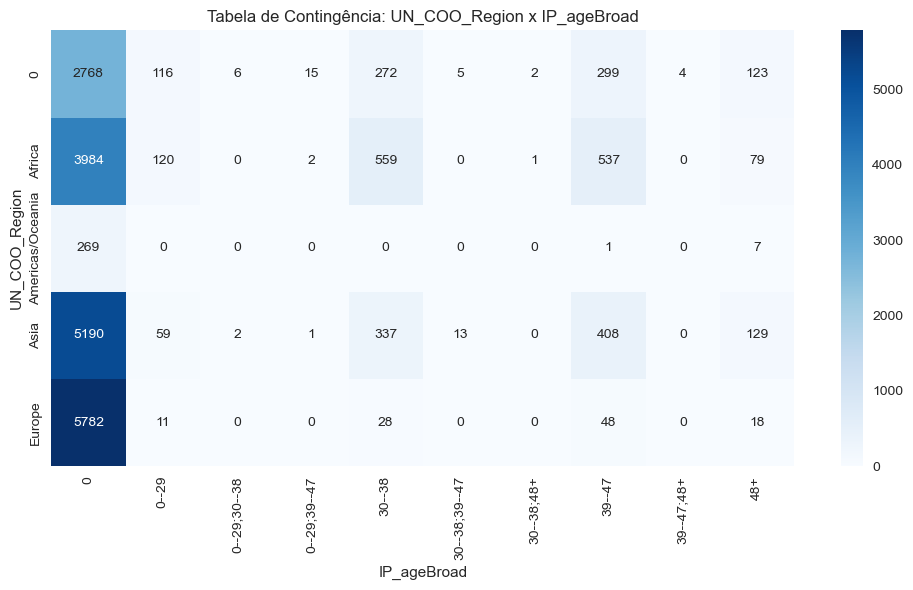


>>> UN_COO_Region x IP_citizen_UNRegion
Chi-quadrado: 25724.5070
p-value: 0.0000
Associação Significativa
Cramér's V: 0.5508


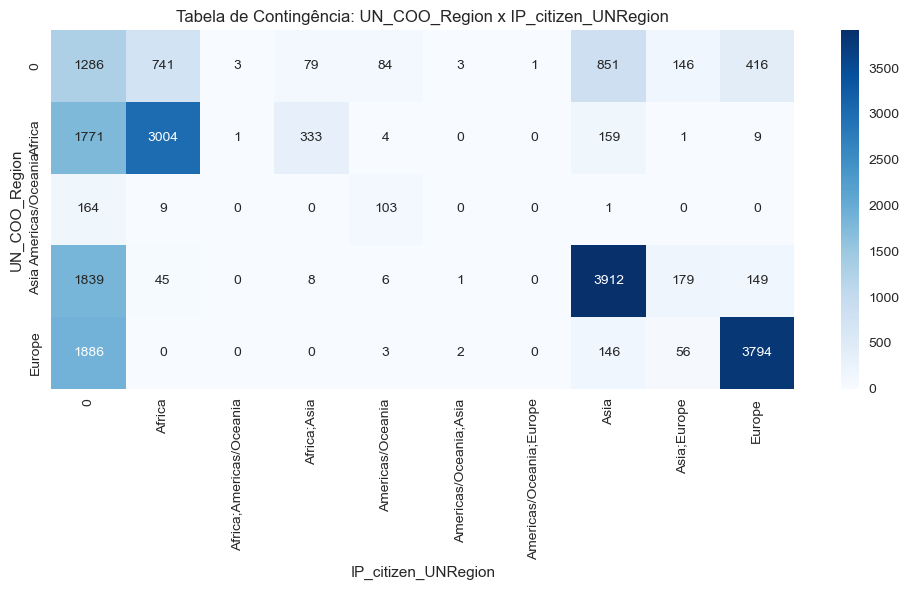


>>> UN_COO_Region x IP_Relation
Chi-quadrado: 1809.9975
p-value: 0.0000
Associação Significativa
Cramér's V: 0.1461


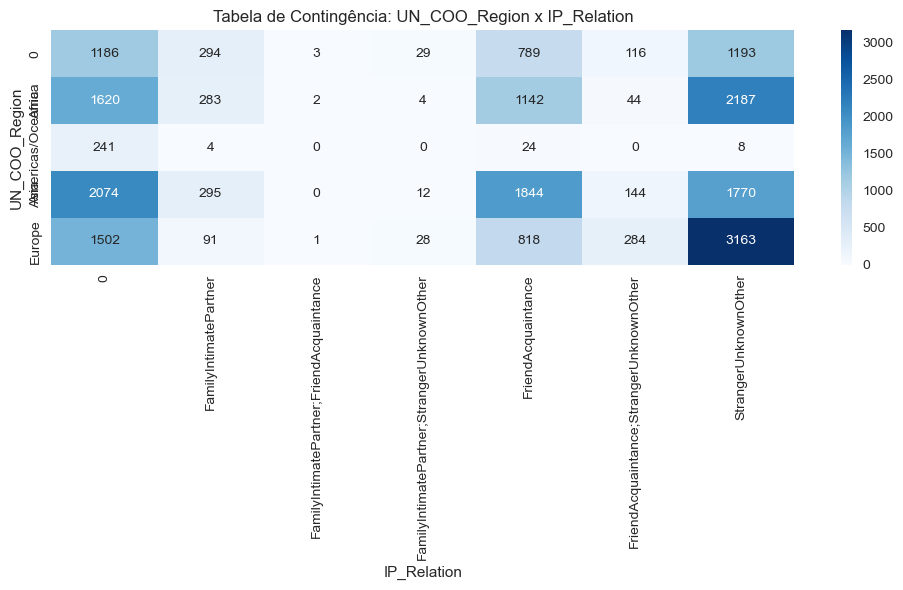


>>> UN_COO_Region x IP_PayMoney
Chi-quadrado: 1403.6751
p-value: 0.0000
Associação Significativa
Cramér's V: 0.1486


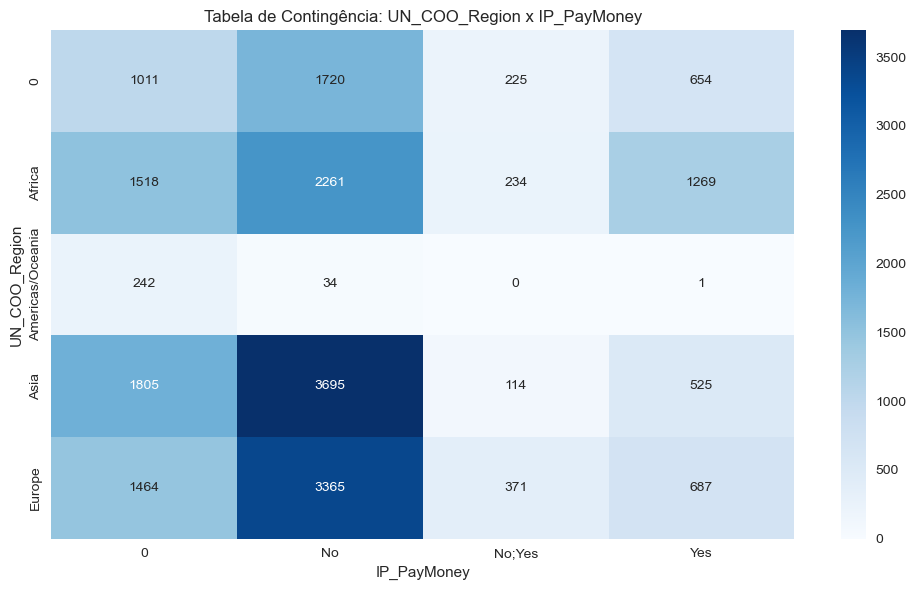


>>> UN_COE_Region x IP_Gender
Chi-quadrado: 2276.4397
p-value: 0.0000
Associação Significativa
Cramér's V: 0.1892


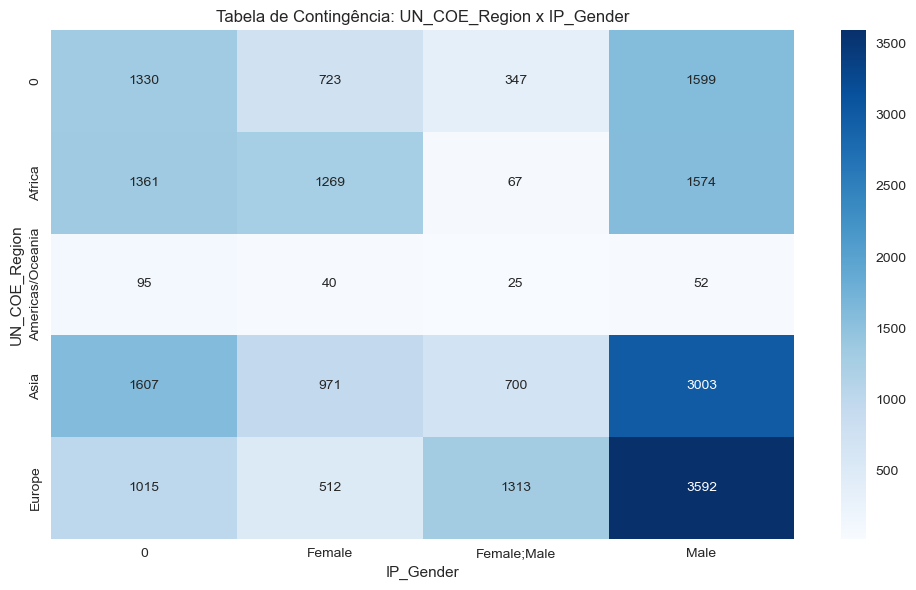


>>> UN_COE_Region x IP_ageBroad
Chi-quadrado: 1931.7790
p-value: 0.0000
Associação Significativa
Cramér's V: 0.1509


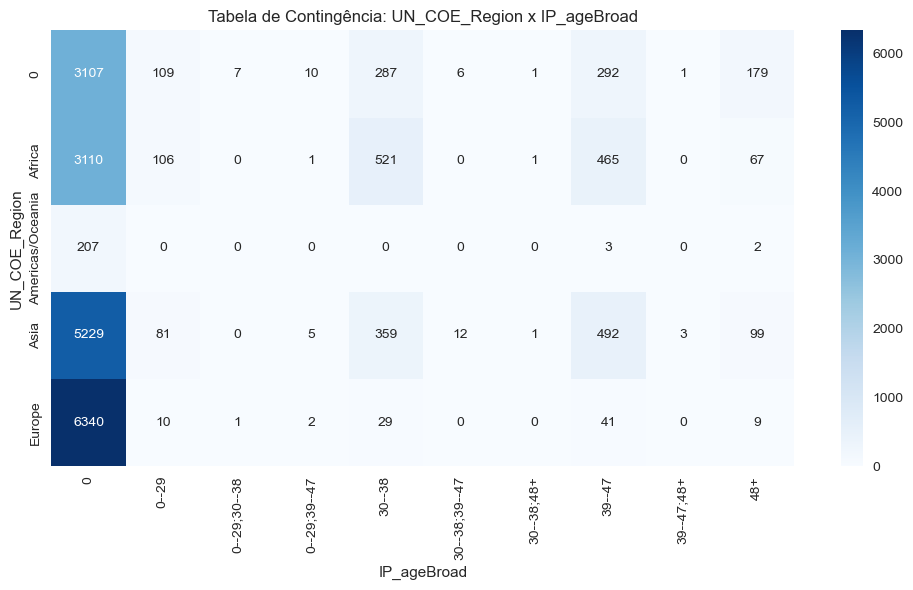


>>> UN_COE_Region x IP_citizen_UNRegion
Chi-quadrado: 23449.8545
p-value: 0.0000
Associação Significativa
Cramér's V: 0.5259


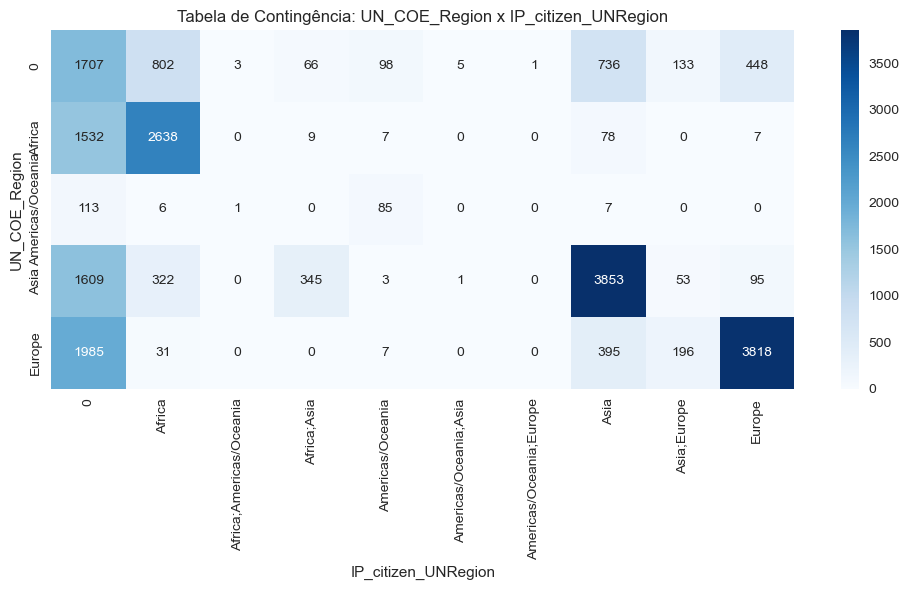


>>> UN_COE_Region x IP_Relation
Chi-quadrado: 1308.0313
p-value: 0.0000
Associação Significativa
Cramér's V: 0.1242


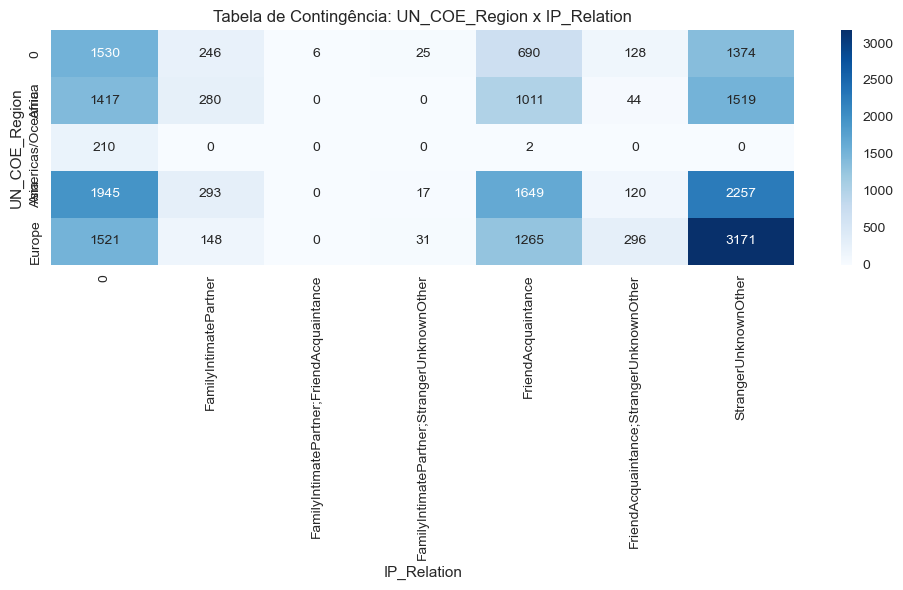


>>> UN_COE_Region x IP_PayMoney
Chi-quadrado: 1321.2620
p-value: 0.0000
Associação Significativa
Cramér's V: 0.1442


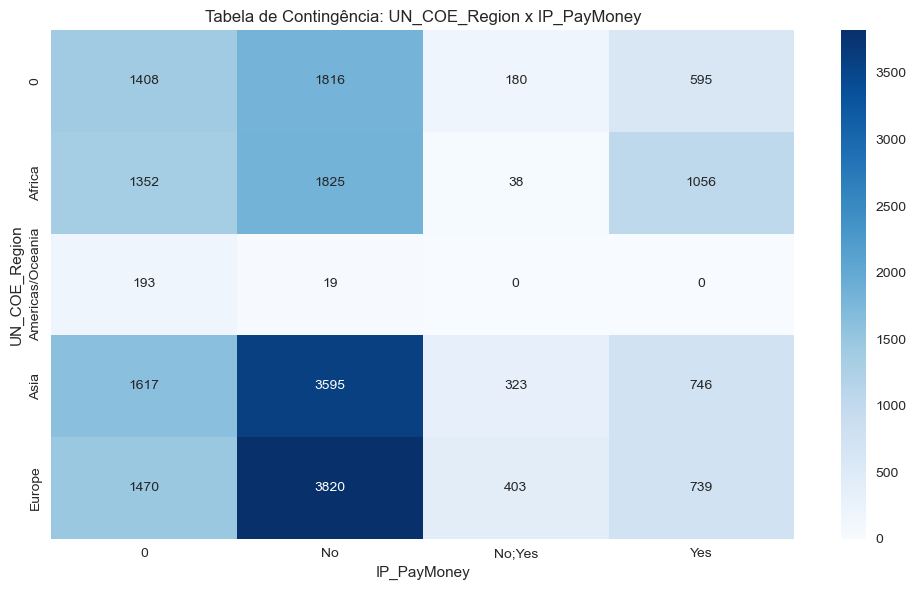


>>> IP_Gender x IP_ageBroad
Chi-quadrado: 850.9709
p-value: 0.0000
Associação Significativa
Cramér's V: 0.1157


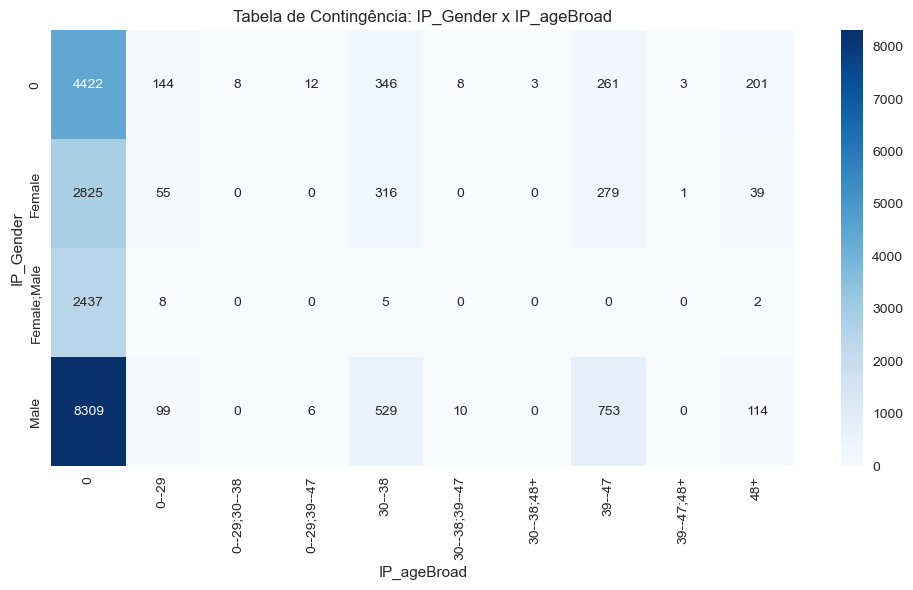


>>> IP_Gender x IP_citizen_UNRegion
Chi-quadrado: 4369.9365
p-value: 0.0000
Associação Significativa
Cramér's V: 0.2622


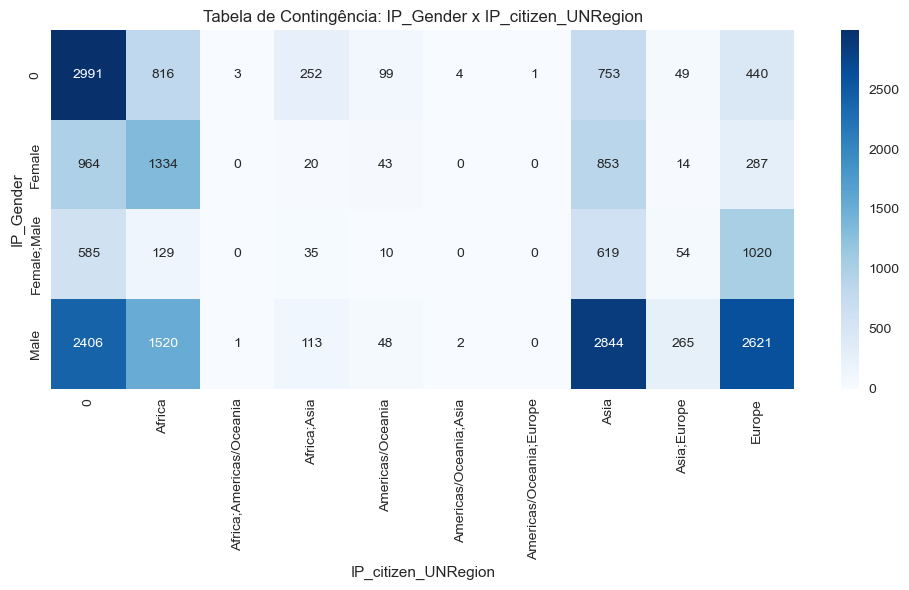


>>> IP_Gender x IP_Relation
Chi-quadrado: 3132.3594
p-value: 0.0000
Associação Significativa
Cramér's V: 0.2220


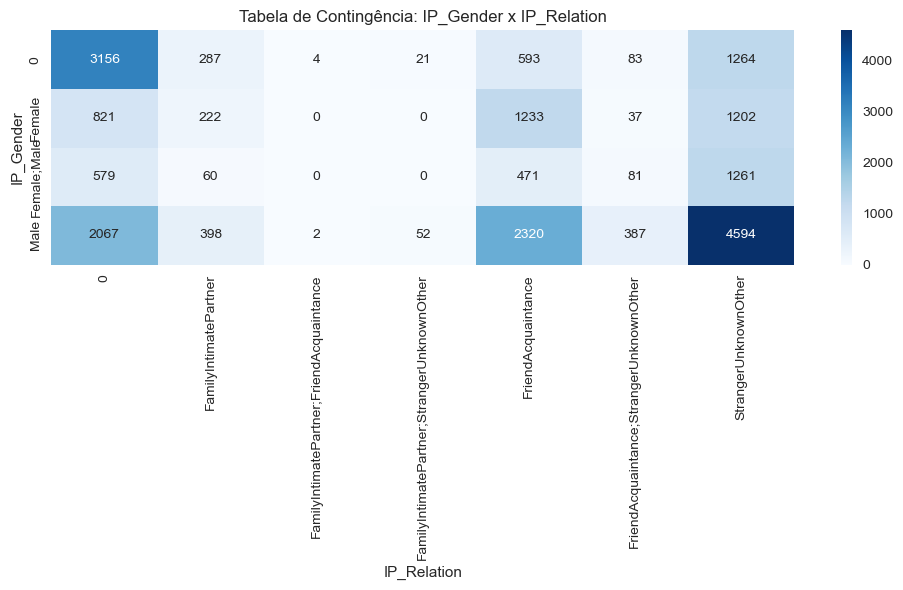


>>> IP_Gender x IP_PayMoney
Chi-quadrado: 2901.5874
p-value: 0.0000
Associação Significativa
Cramér's V: 0.2136


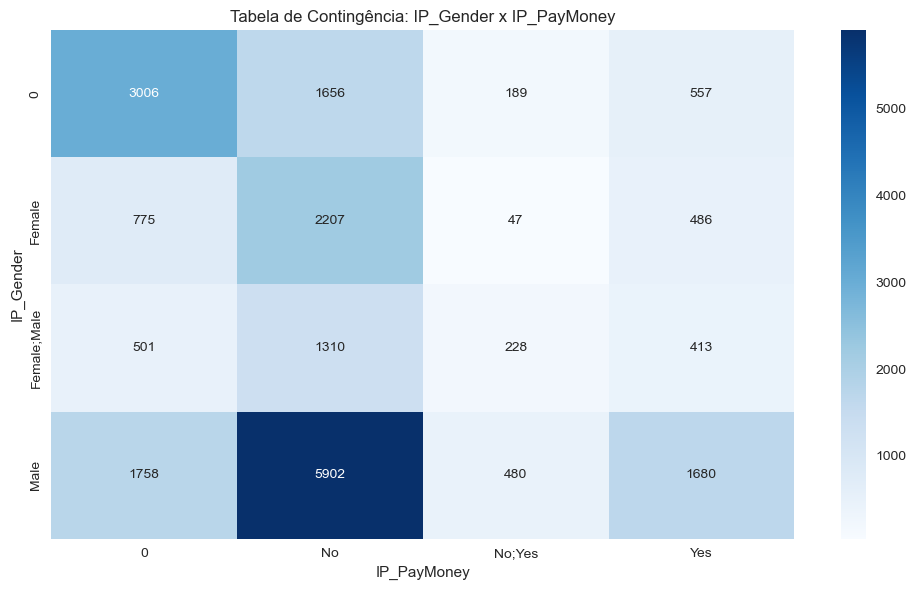


>>> IP_ageBroad x IP_citizen_UNRegion
Chi-quadrado: 1923.7593
p-value: 0.0000
Associação Significativa
Cramér's V: 0.1004


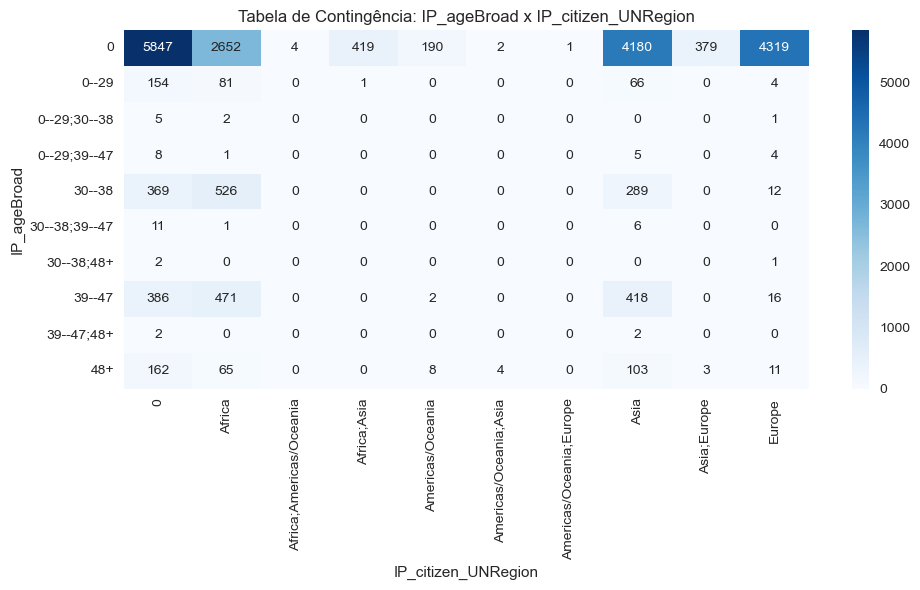


>>> IP_ageBroad x IP_Relation
Chi-quadrado: 468.1855
p-value: 0.0000
Associação Significativa
Cramér's V: 0.0607


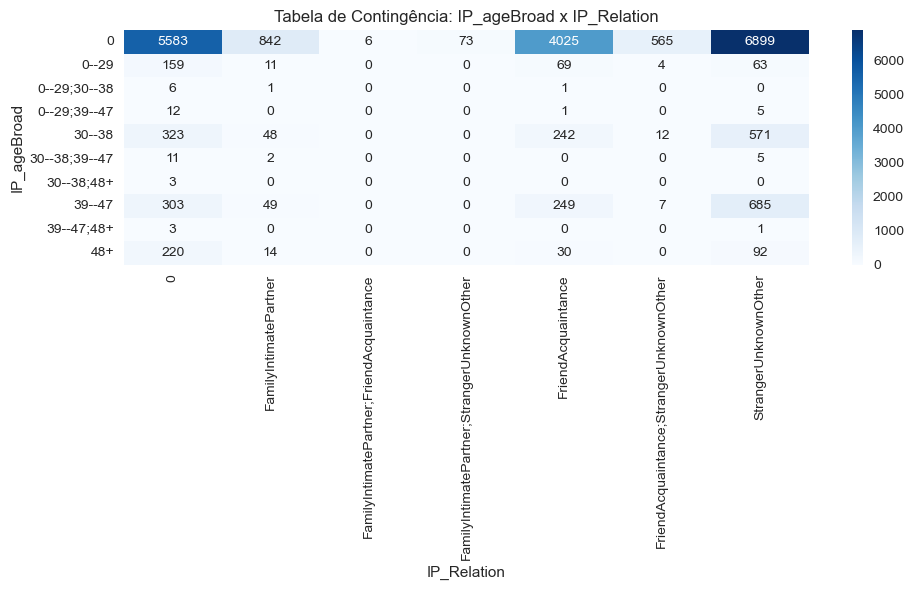


>>> IP_ageBroad x IP_PayMoney
Chi-quadrado: 577.7498
p-value: 0.0000
Associação Significativa
Cramér's V: 0.0953


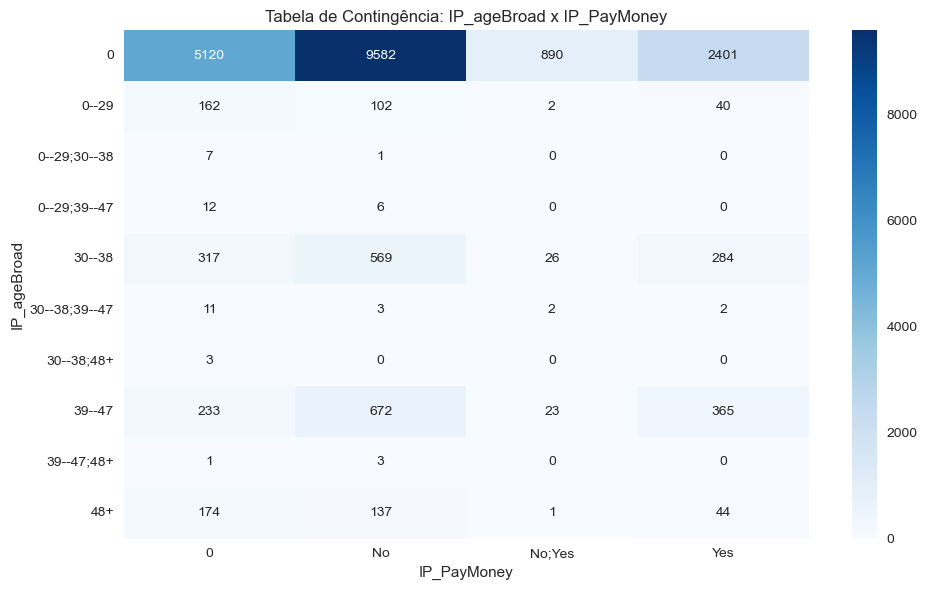


>>> IP_citizen_UNRegion x IP_Relation
Chi-quadrado: 3565.5005
p-value: 0.0000
Associação Significativa
Cramér's V: 0.1674


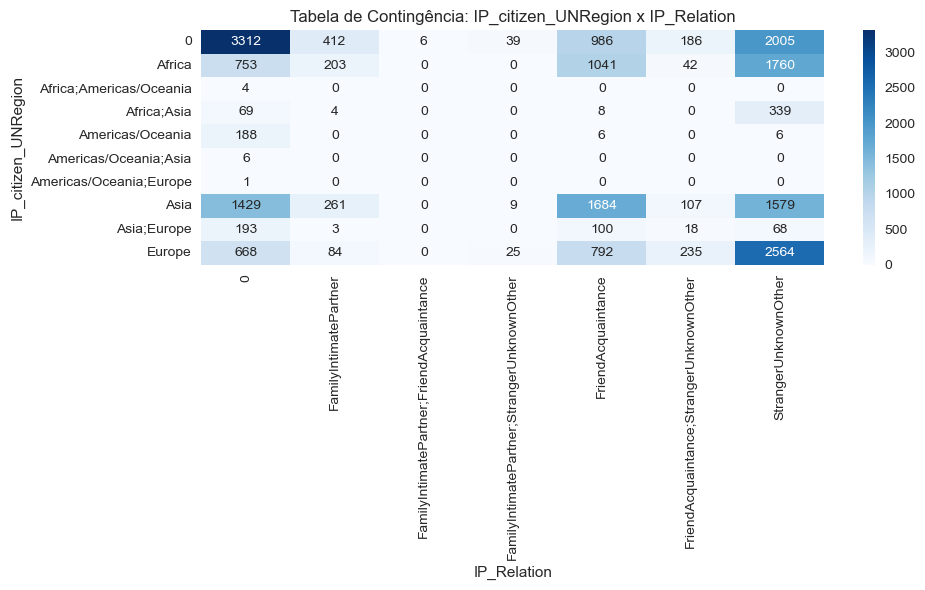


>>> IP_citizen_UNRegion x IP_PayMoney
Chi-quadrado: 3608.8328
p-value: 0.0000
Associação Significativa
Cramér's V: 0.2382


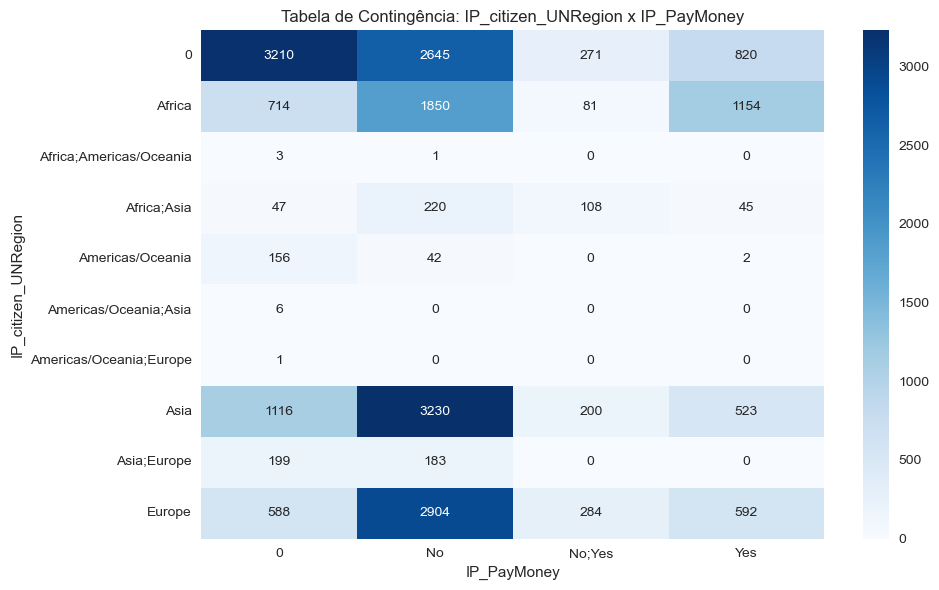


>>> IP_Relation x IP_PayMoney
Chi-quadrado: 7398.6044
p-value: 0.0000
Associação Significativa
Cramér's V: 0.3411


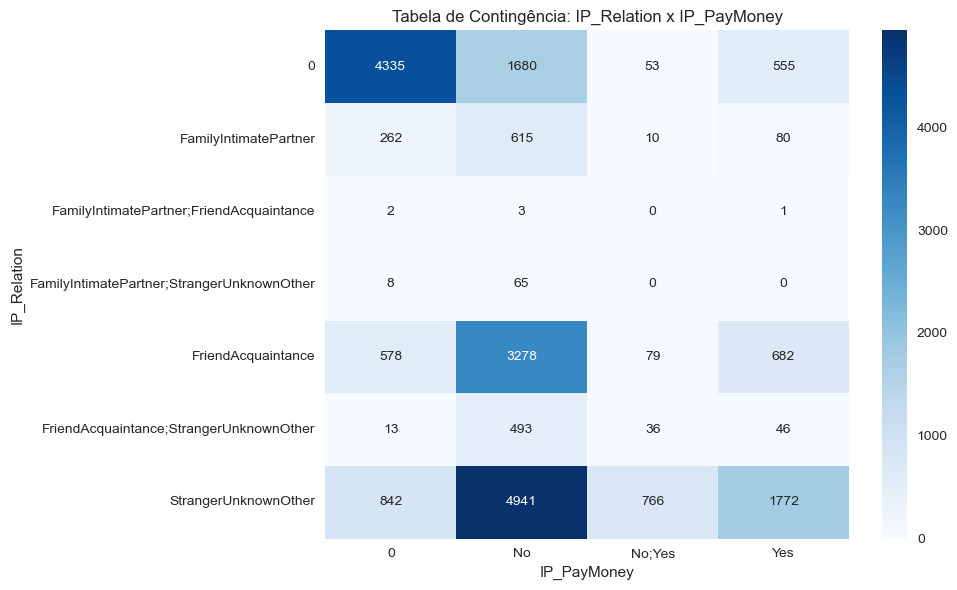

In [20]:
analise_bivariada_completa(df=df)

### Analise multivariada


ANÁLISE MULTIVARIADA COMPLETA

3.1 ANÁLISE DE COMPONENTES PRINCIPAIS (PCA)
--------------------------------------------------
Analisando 6 variáveis numéricas com 21195 observações válidas.
Variância explicada por componente:
PC1: 0.2788 (27.88%)
PC2: 0.2039 (20.39%)
PC3: 0.1855 (18.55%)
PC4: 0.1427 (14.27%)
PC5: 0.1072 (10.72%)
PC6: 0.0819 (8.19%)

Variância acumulada até PC3: 0.6683 (66.83%)


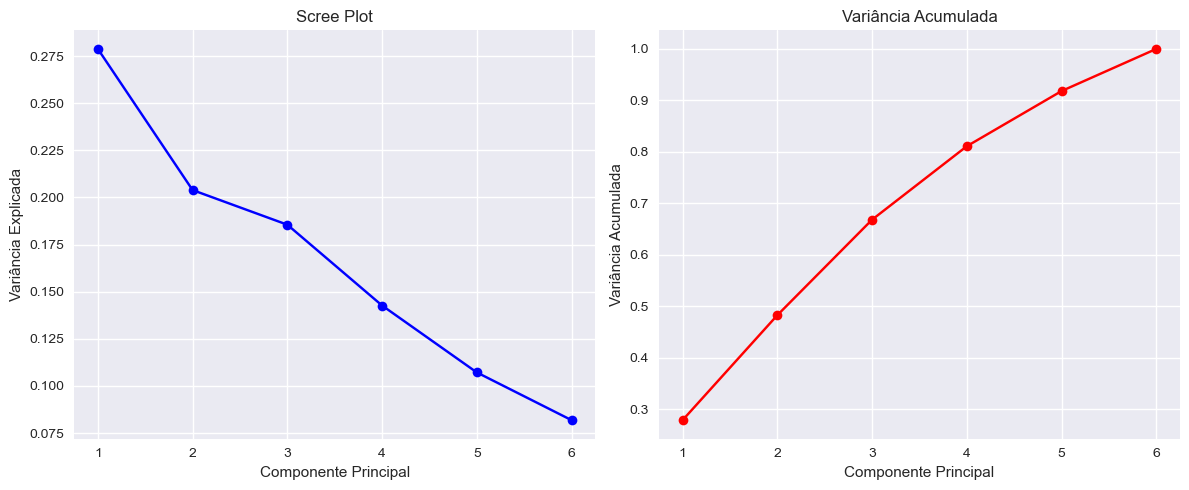

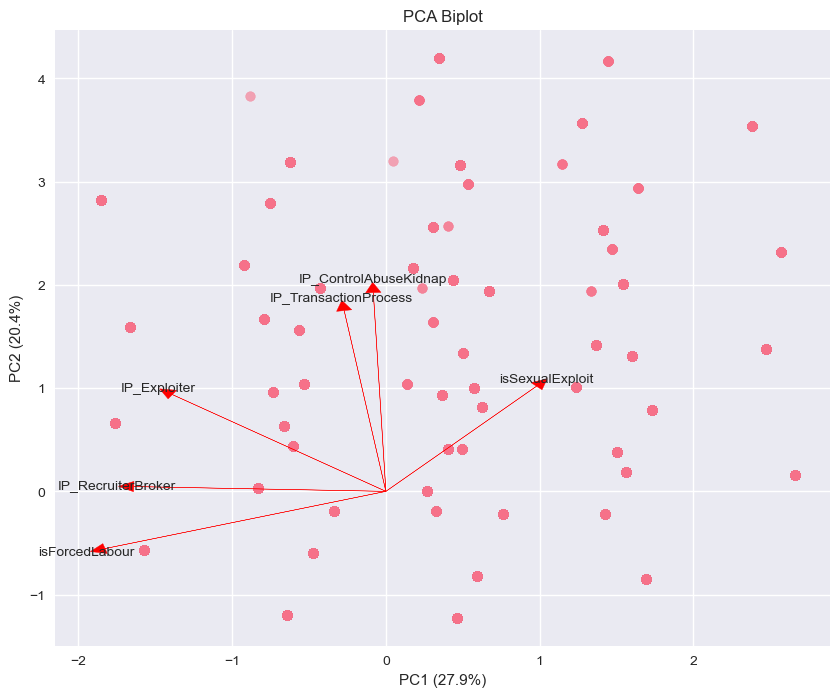

In [21]:
analise_multivariada_completa(df=df)

### Analise categorica


2.3 ANÁLISE CATEGÓRICA vs NUMÉRICA
--------------------------------------------------

>>> yearRegister x isForcedLabour
               count      mean       std  min  25%  50%  75%  max
yearRegister                                                     
0             3655.0  0.535978  0.498772  0.0  0.0  1.0  1.0  1.0
2005-2013     2531.0  0.491505  0.500027  0.0  0.0  0.0  1.0  1.0
2014-2018     6274.0  0.685209  0.464470  0.0  0.0  1.0  1.0  1.0
2019          2398.0  0.558799  0.496634  0.0  0.0  1.0  1.0  1.0
2020          2002.0  0.649850  0.477136  0.0  0.0  1.0  1.0  1.0
2021-2022     4335.0  0.485582  0.499850  0.0  0.0  0.0  1.0  1.0
ANOVA: F = 122.9260, p-value = 0.0000


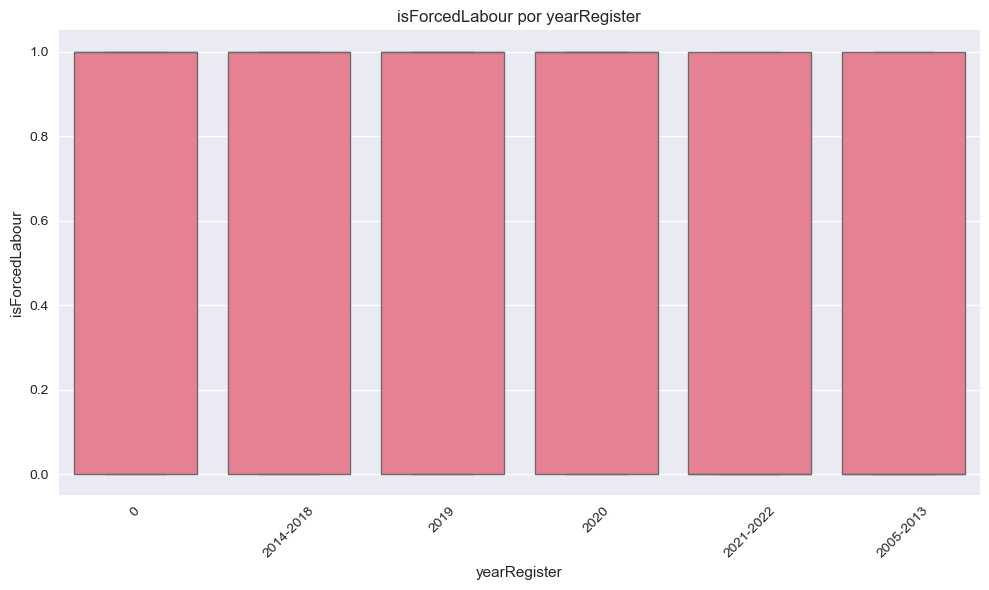


>>> yearRegister x isSexualExploit
               count      mean       std  min  25%  50%  75%  max
yearRegister                                                     
0             3655.0  0.214774  0.410722  0.0  0.0  0.0  0.0  1.0
2005-2013     2531.0  0.177005  0.381748  0.0  0.0  0.0  0.0  1.0
2014-2018     6274.0  0.093880  0.291684  0.0  0.0  0.0  0.0  1.0
2019          2398.0  0.181818  0.385775  0.0  0.0  0.0  0.0  1.0
2020          2002.0  0.067433  0.250832  0.0  0.0  0.0  0.0  1.0
2021-2022     4335.0  0.088120  0.283502  0.0  0.0  0.0  0.0  1.0
ANOVA: F = 111.6478, p-value = 0.0000


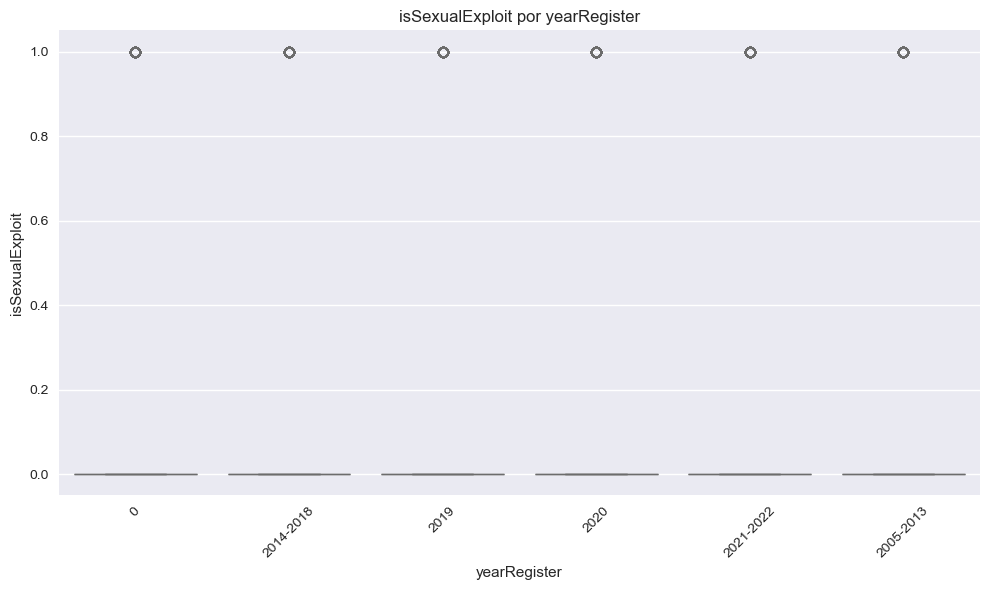


>>> yearRegister x IP_Exploiter
               count      mean       std  min  25%  50%  75%  max
yearRegister                                                     
0             3655.0  0.441587  0.496644  0.0  0.0  0.0  1.0  1.0
2005-2013     2531.0  0.498222  0.500096  0.0  0.0  0.0  1.0  1.0
2014-2018     6274.0  0.604240  0.489052  0.0  0.0  1.0  1.0  1.0
2019          2398.0  0.457882  0.498327  0.0  0.0  0.0  1.0  1.0
2020          2002.0  0.346154  0.475862  0.0  0.0  0.0  1.0  1.0
2021-2022     4335.0  0.230911  0.421464  0.0  0.0  0.0  0.0  1.0
ANOVA: F = 336.1549, p-value = 0.0000


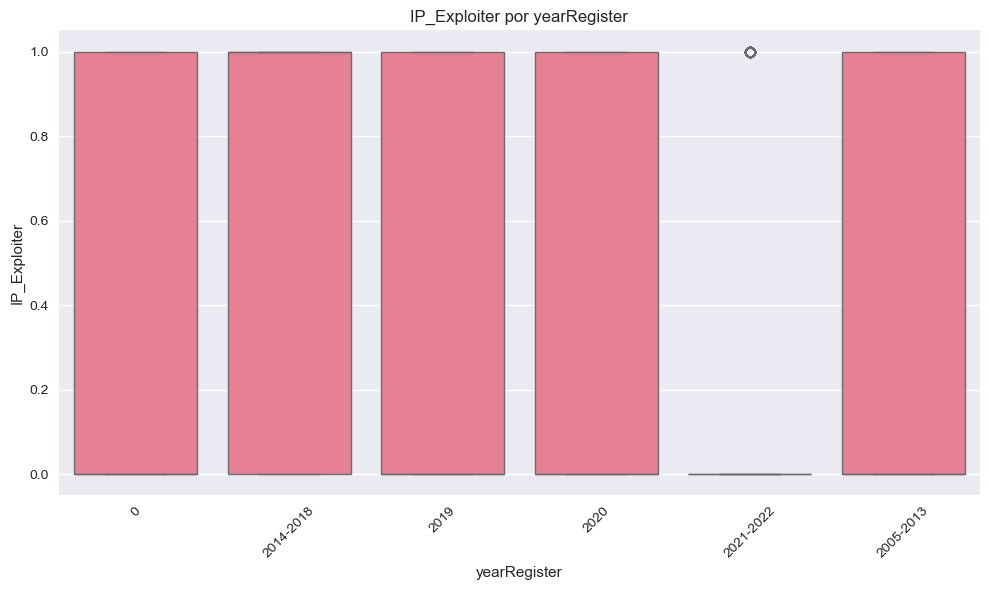


>>> yearRegister x IP_RecruiterBroker
               count      mean       std  min  25%  50%  75%  max
yearRegister                                                     
0             3655.0  0.545007  0.498038  0.0  0.0  1.0  1.0  1.0
2005-2013     2531.0  0.585144  0.492794  0.0  0.0  1.0  1.0  1.0
2014-2018     6274.0  0.656838  0.474803  0.0  0.0  1.0  1.0  1.0
2019          2398.0  0.597998  0.490405  0.0  0.0  1.0  1.0  1.0
2020          2002.0  0.542458  0.498319  0.0  0.0  1.0  1.0  1.0
2021-2022     4335.0  0.403922  0.490739  0.0  0.0  0.0  1.0  1.0
ANOVA: F = 143.3876, p-value = 0.0000


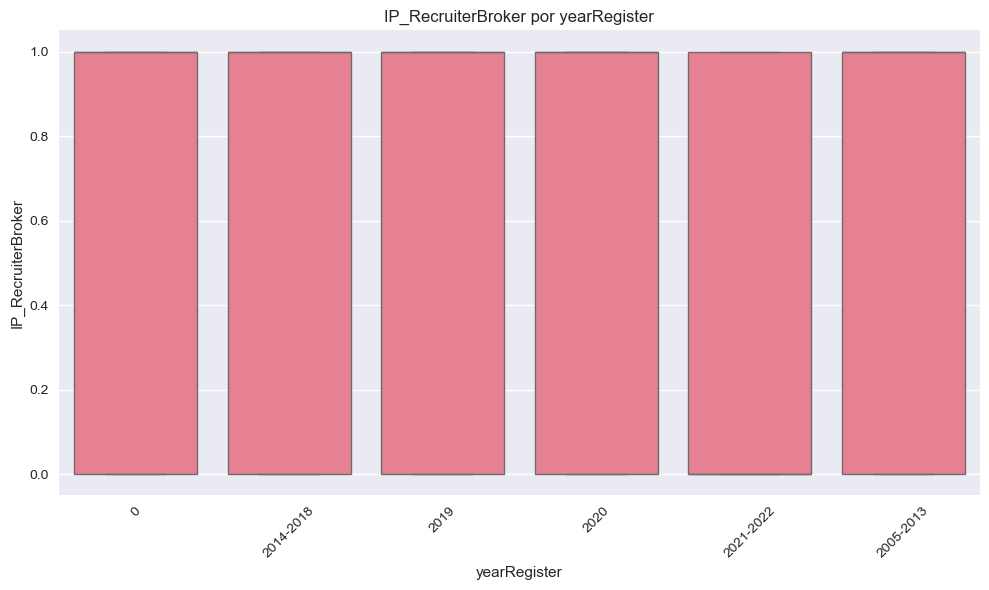


>>> yearRegister x IP_TransactionProcess
               count      mean       std  min  25%  50%  75%  max
yearRegister                                                     
0             3655.0  0.376744  0.484636  0.0  0.0  0.0  1.0  1.0
2005-2013     2531.0  0.230739  0.421389  0.0  0.0  0.0  0.0  1.0
2014-2018     6274.0  0.246095  0.430769  0.0  0.0  0.0  0.0  1.0
2019          2398.0  0.427023  0.494749  0.0  0.0  0.0  1.0  1.0
2020          2002.0  0.431069  0.495349  0.0  0.0  0.0  1.0  1.0
2021-2022     4335.0  0.450288  0.497580  0.0  0.0  0.0  1.0  1.0
ANOVA: F = 162.3447, p-value = 0.0000


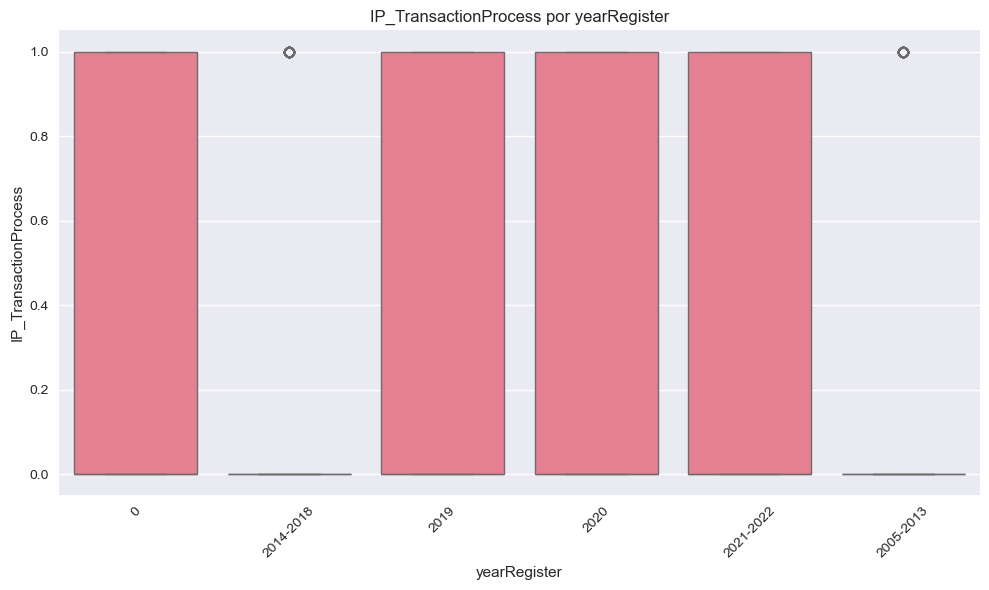


>>> yearRegister x IP_ControlAbuseKidnap
               count      mean       std  min  25%  50%  75%  max
yearRegister                                                     
0             3655.0  0.156224  0.363118  0.0  0.0  0.0  0.0  1.0
2005-2013     2531.0  0.005927  0.076771  0.0  0.0  0.0  0.0  1.0
2014-2018     6274.0  0.026299  0.160036  0.0  0.0  0.0  0.0  1.0
2019          2398.0  0.156797  0.363685  0.0  0.0  0.0  0.0  1.0
2020          2002.0  0.122877  0.328378  0.0  0.0  0.0  0.0  1.0
2021-2022     4335.0  0.162630  0.369070  0.0  0.0  0.0  0.0  1.0
ANOVA: F = 223.1052, p-value = 0.0000


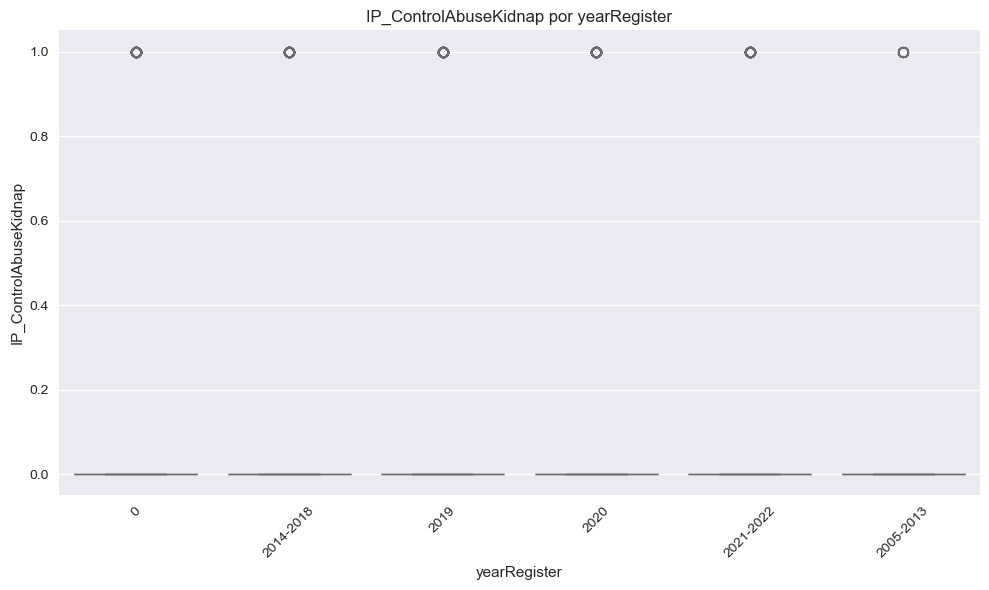


>>> gender x isForcedLabour
         count      mean       std  min  25%  50%  75%  max
gender                                                     
0       3611.0  0.288563  0.453157  0.0  0.0  0.0  1.0  1.0
Female  9589.0  0.579205  0.493712  0.0  0.0  1.0  1.0  1.0
Male    7995.0  0.706942  0.455193  0.0  0.0  1.0  1.0  1.0
ANOVA: F = 974.4890, p-value = 0.0000


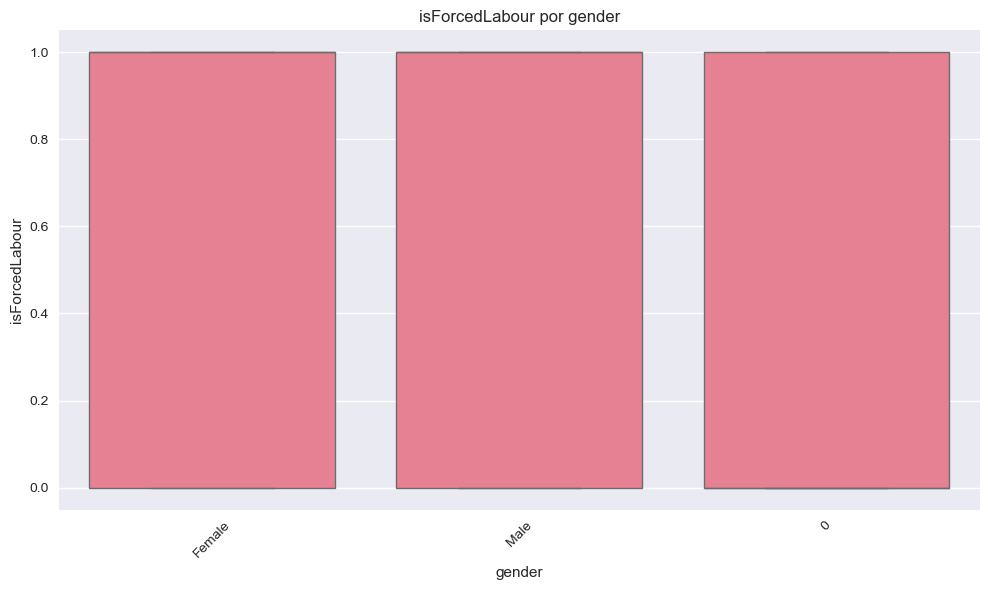


>>> gender x isSexualExploit
         count      mean       std  min  25%  50%  75%  max
gender                                                     
0       3611.0  0.122127  0.327478  0.0  0.0  0.0  0.0  1.0
Female  9589.0  0.239128  0.426573  0.0  0.0  0.0  0.0  1.0
Male    7995.0  0.005128  0.071432  0.0  0.0  0.0  0.0  1.0
ANOVA: F = 1165.9461, p-value = 0.0000


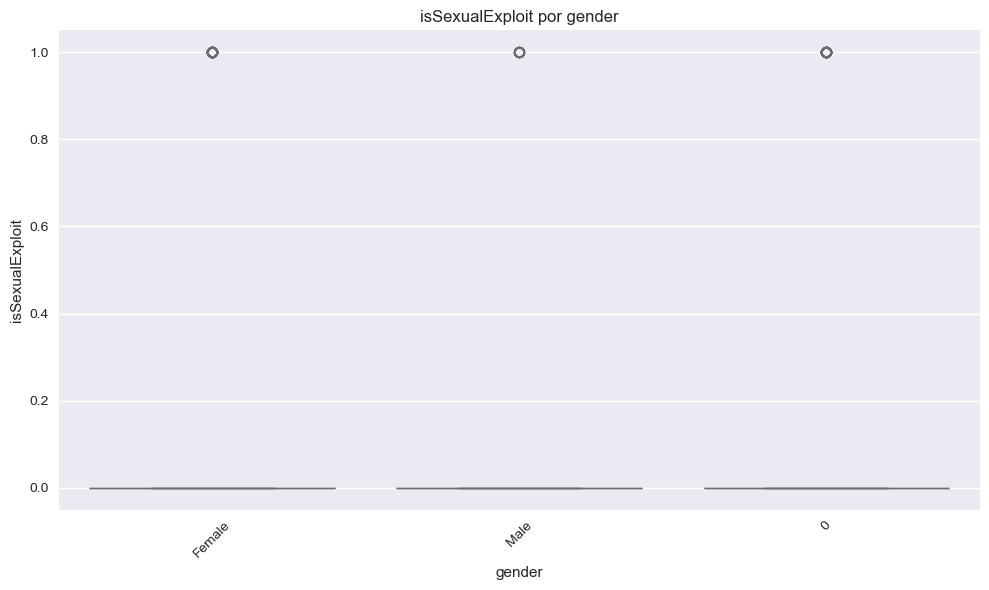


>>> gender x IP_Exploiter
         count      mean       std  min  25%  50%  75%  max
gender                                                     
0       3611.0  0.213791  0.410038  0.0  0.0  0.0  0.0  1.0
Female  9589.0  0.463343  0.498680  0.0  0.0  0.0  1.0  1.0
Male    7995.0  0.530707  0.499087  0.0  0.0  1.0  1.0  1.0
ANOVA: F = 542.2004, p-value = 0.0000


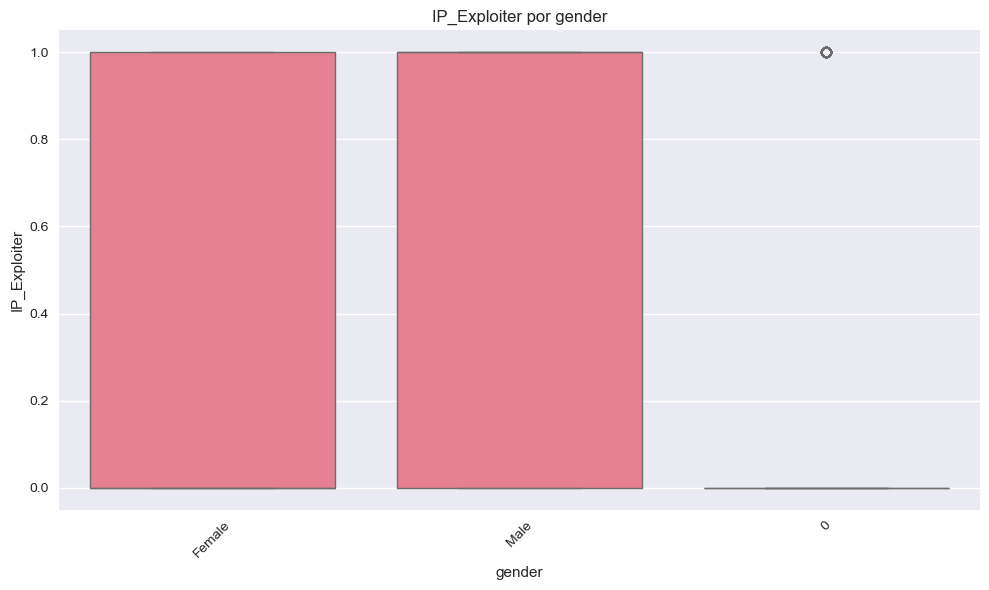


>>> gender x IP_RecruiterBroker
         count      mean       std  min  25%  50%  75%  max
gender                                                     
0       3611.0  0.297425  0.457188  0.0  0.0  0.0  1.0  1.0
Female  9589.0  0.618938  0.485673  0.0  0.0  1.0  1.0  1.0
Male    7995.0  0.607380  0.488364  0.0  0.0  1.0  1.0  1.0
ANOVA: F = 646.2120, p-value = 0.0000


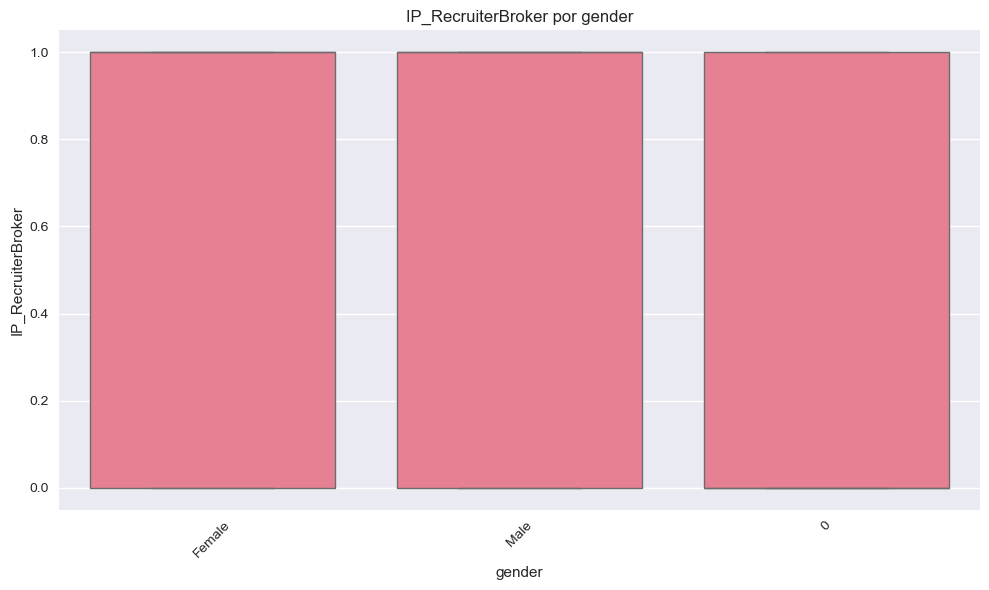


>>> gender x IP_TransactionProcess
         count      mean       std  min  25%  50%  75%  max
gender                                                     
0       3611.0  0.220714  0.414786  0.0  0.0  0.0  0.0  1.0
Female  9589.0  0.392846  0.488409  0.0  0.0  0.0  1.0  1.0
Male    7995.0  0.347717  0.476276  0.0  0.0  0.0  1.0  1.0
ANOVA: F = 174.4650, p-value = 0.0000


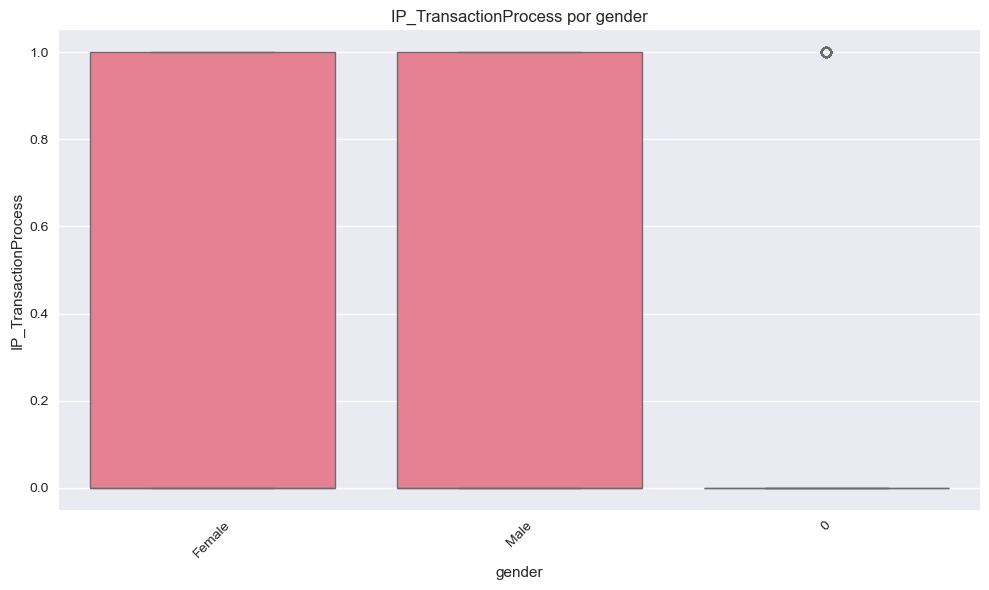


>>> gender x IP_ControlAbuseKidnap
         count      mean       std  min  25%  50%  75%  max
gender                                                     
0       3611.0  0.081141  0.273089  0.0  0.0  0.0  0.0  1.0
Female  9589.0  0.089582  0.285597  0.0  0.0  0.0  0.0  1.0
Male    7995.0  0.115822  0.320032  0.0  0.0  0.0  0.0  1.0
ANOVA: F = 24.0552, p-value = 0.0000


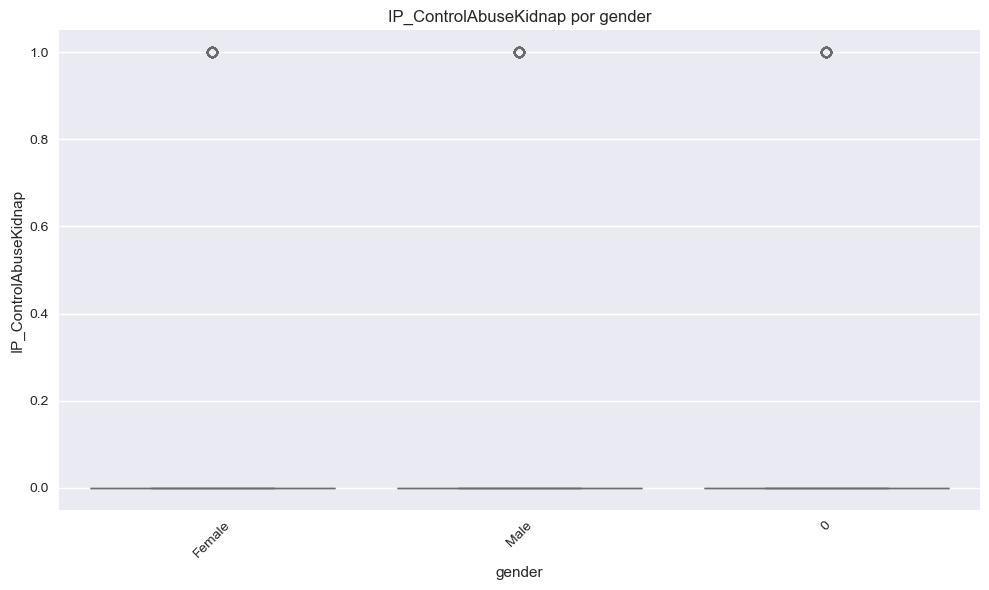


>>> majorityStatus x isForcedLabour
                  count      mean       std  min  25%  50%  75%  max
majorityStatus                                                      
0                3604.0  0.190622  0.392846  0.0  0.0  0.0  0.0  1.0
Adult           16379.0  0.677697  0.467373  0.0  0.0  1.0  1.0  1.0
Minor            1212.0  0.380363  0.485676  0.0  0.0  0.0  1.0  1.0
ANOVA: F = 1800.5761, p-value = 0.0000


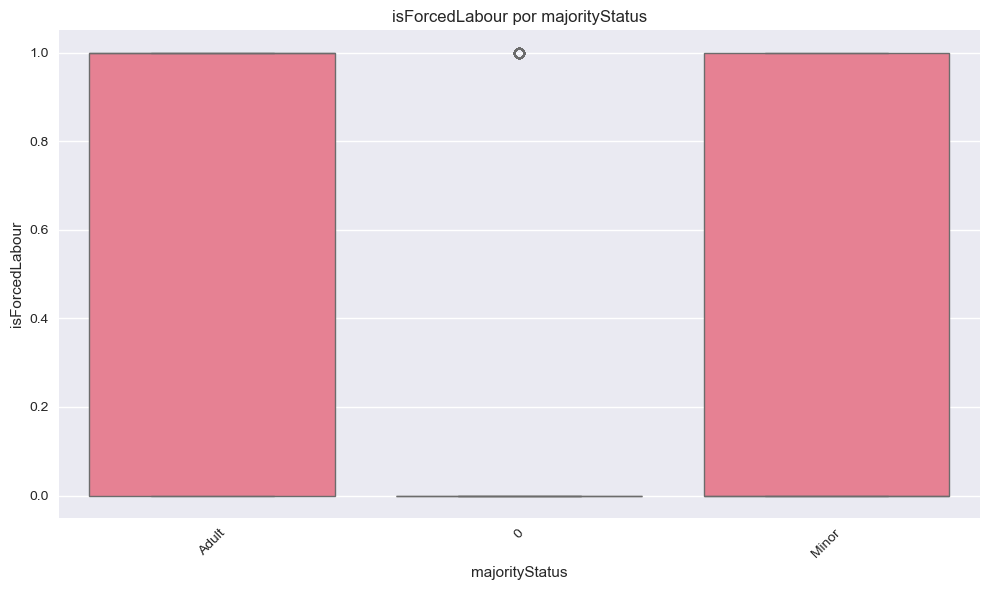


>>> majorityStatus x isSexualExploit
                  count      mean       std  min  25%  50%  75%  max
majorityStatus                                                      
0                3604.0  0.108768  0.311391  0.0  0.0  0.0  0.0  1.0
Adult           16379.0  0.136883  0.343734  0.0  0.0  0.0  0.0  1.0
Minor            1212.0  0.116337  0.320761  0.0  0.0  0.0  0.0  1.0
ANOVA: F = 11.4736, p-value = 0.0000


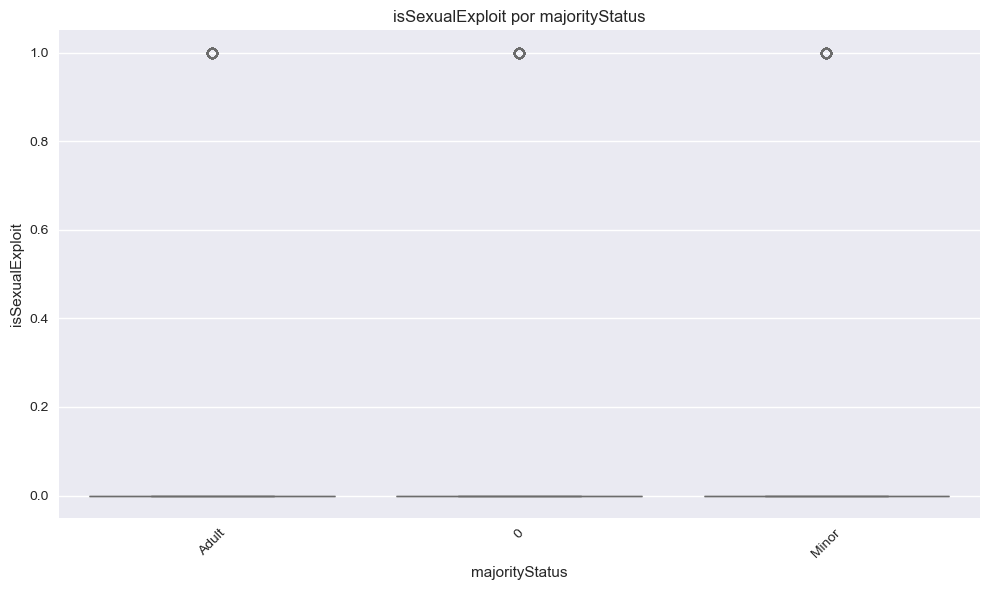


>>> majorityStatus x IP_Exploiter
                  count      mean       std  min  25%  50%  75%  max
majorityStatus                                                      
0                3604.0  0.145117  0.352267  0.0  0.0  0.0  0.0  1.0
Adult           16379.0  0.527444  0.499262  0.0  0.0  1.0  1.0  1.0
Minor            1212.0  0.244224  0.429804  0.0  0.0  0.0  0.0  1.0
ANOVA: F = 1079.5225, p-value = 0.0000


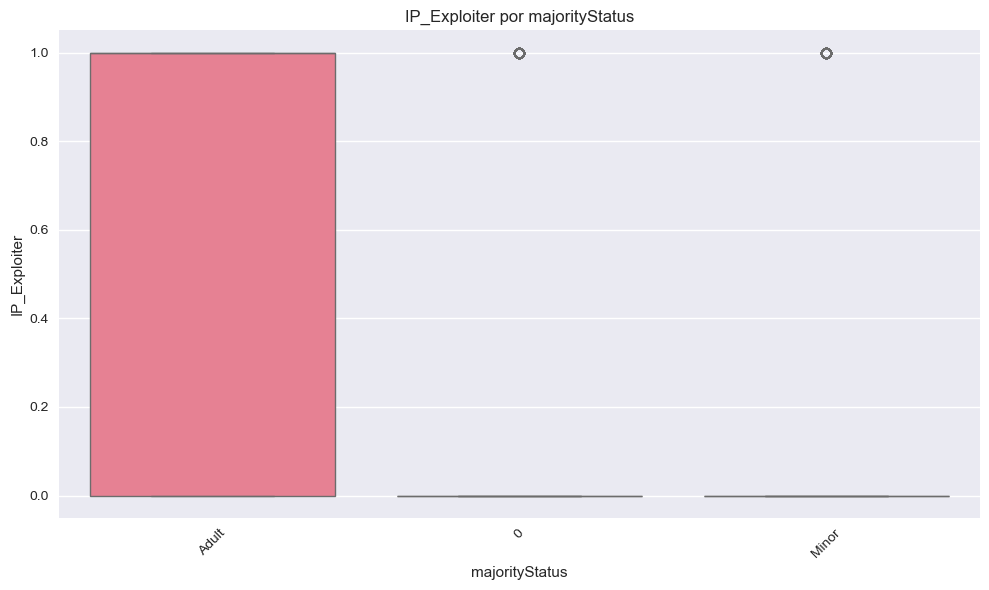


>>> majorityStatus x IP_RecruiterBroker
                  count      mean       std  min  25%  50%  75%  max
majorityStatus                                                      
0                3604.0  0.173696  0.378900  0.0  0.0  0.0  0.0  1.0
Adult           16379.0  0.666768  0.471383  0.0  0.0  1.0  1.0  1.0
Minor            1212.0  0.262376  0.440108  0.0  0.0  0.0  1.0  1.0
ANOVA: F = 2007.4446, p-value = 0.0000


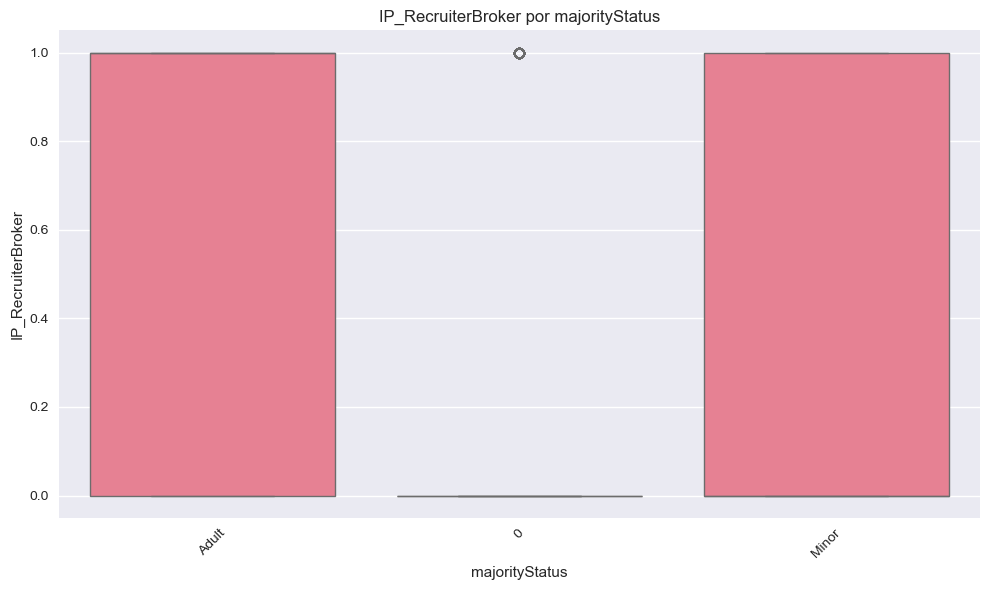


>>> majorityStatus x IP_TransactionProcess
                  count      mean       std  min  25%  50%  75%  max
majorityStatus                                                      
0                3604.0  0.095727  0.294257  0.0  0.0  0.0  0.0  1.0
Adult           16379.0  0.411136  0.492055  0.0  0.0  0.0  1.0  1.0
Minor            1212.0  0.218647  0.413499  0.0  0.0  0.0  0.0  1.0
ANOVA: F = 744.0236, p-value = 0.0000


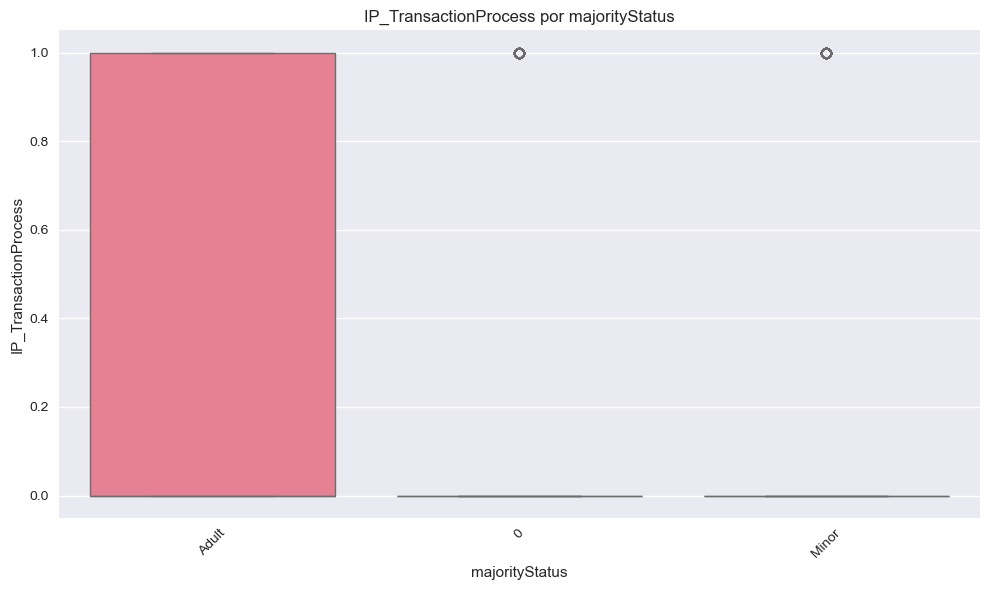


>>> majorityStatus x IP_ControlAbuseKidnap
                  count      mean       std  min  25%  50%  75%  max
majorityStatus                                                      
0                3604.0  0.042730  0.202276  0.0  0.0  0.0  0.0  1.0
Adult           16379.0  0.116307  0.320603  0.0  0.0  0.0  0.0  1.0
Minor            1212.0  0.015677  0.124272  0.0  0.0  0.0  0.0  1.0
ANOVA: F = 141.5781, p-value = 0.0000


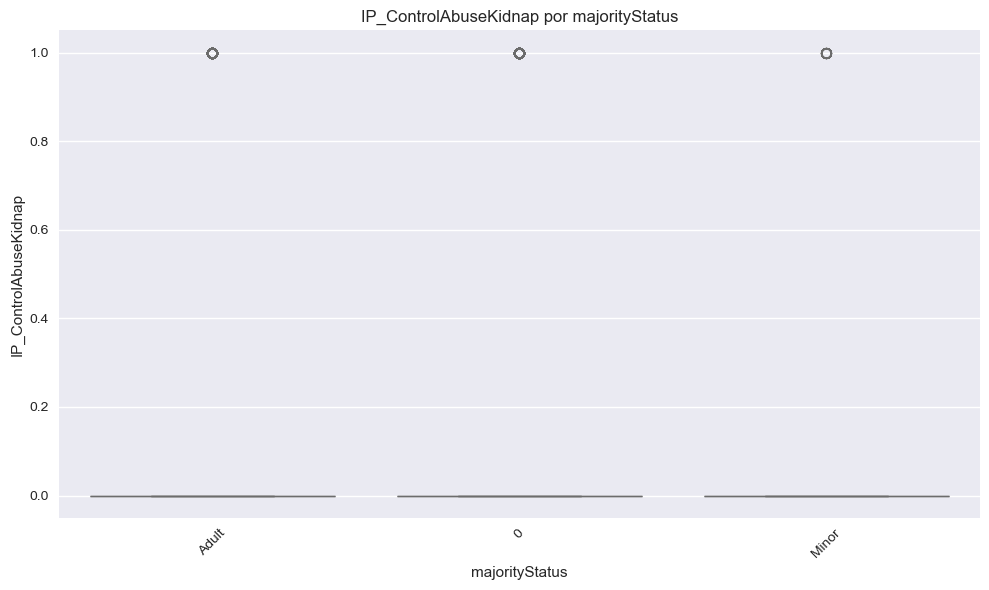


>>> UN_COO_Region x isForcedLabour
                   count      mean       std  min  25%  50%  75%  max
UN_COO_Region                                                        
0                 3610.0  0.516343  0.499802  0.0  0.0  1.0  1.0  1.0
Africa            5282.0  0.404203  0.490784  0.0  0.0  0.0  1.0  1.0
Americas/Oceania   277.0  0.184116  0.388280  0.0  0.0  0.0  0.0  1.0
Asia              6139.0  0.693761  0.460968  0.0  0.0  1.0  1.0  1.0
Europe            5887.0  0.669101  0.470577  0.0  0.0  1.0  1.0  1.0
ANOVA: F = 381.5556, p-value = 0.0000


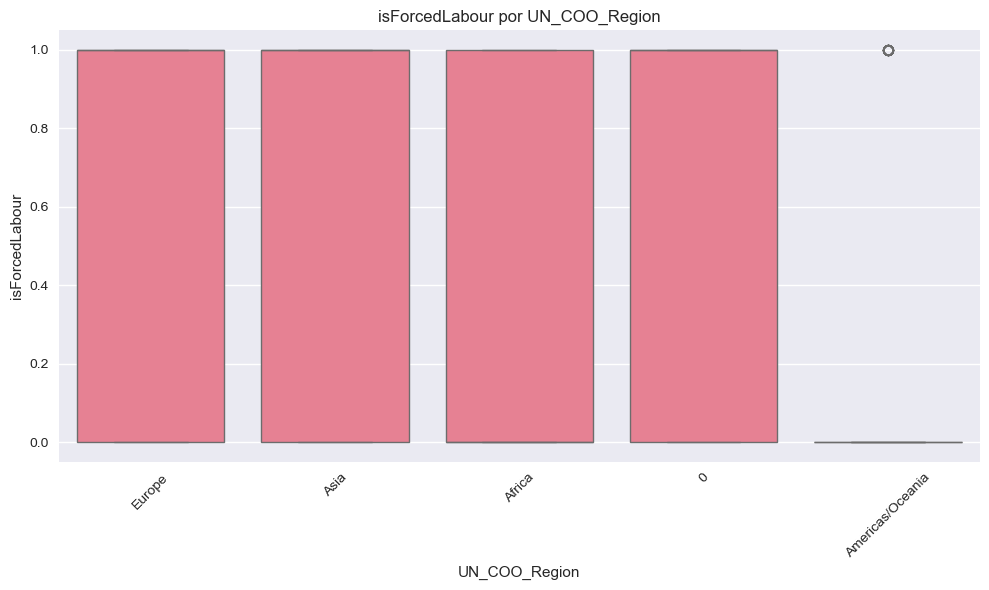


>>> UN_COO_Region x isSexualExploit
                   count      mean       std  min  25%  50%  75%  max
UN_COO_Region                                                        
0                 3610.0  0.173961  0.379129  0.0  0.0  0.0  0.0  1.0
Africa            5282.0  0.184021  0.387538  0.0  0.0  0.0  0.0  1.0
Americas/Oceania   277.0  0.238267  0.426794  0.0  0.0  0.0  0.0  1.0
Asia              6139.0  0.100994  0.301345  0.0  0.0  0.0  0.0  1.0
Europe            5887.0  0.083064  0.276003  0.0  0.0  0.0  0.0  1.0
ANOVA: F = 97.8855, p-value = 0.0000


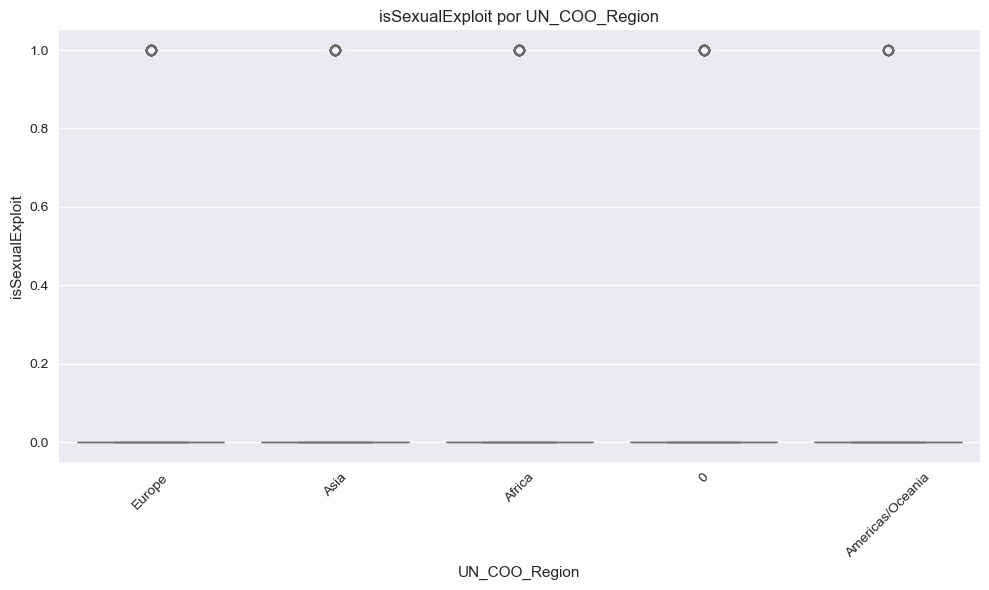


>>> UN_COO_Region x IP_Exploiter
                   count      mean       std  min  25%  50%  75%  max
UN_COO_Region                                                        
0                 3610.0  0.386704  0.487062  0.0  0.0  0.0  1.0  1.0
Africa            5282.0  0.243279  0.429103  0.0  0.0  0.0  0.0  1.0
Americas/Oceania   277.0  0.357401  0.480102  0.0  0.0  0.0  1.0  1.0
Asia              6139.0  0.446164  0.497134  0.0  0.0  0.0  1.0  1.0
Europe            5887.0  0.669101  0.470577  0.0  0.0  1.0  1.0  1.0
ANOVA: F = 590.1180, p-value = 0.0000


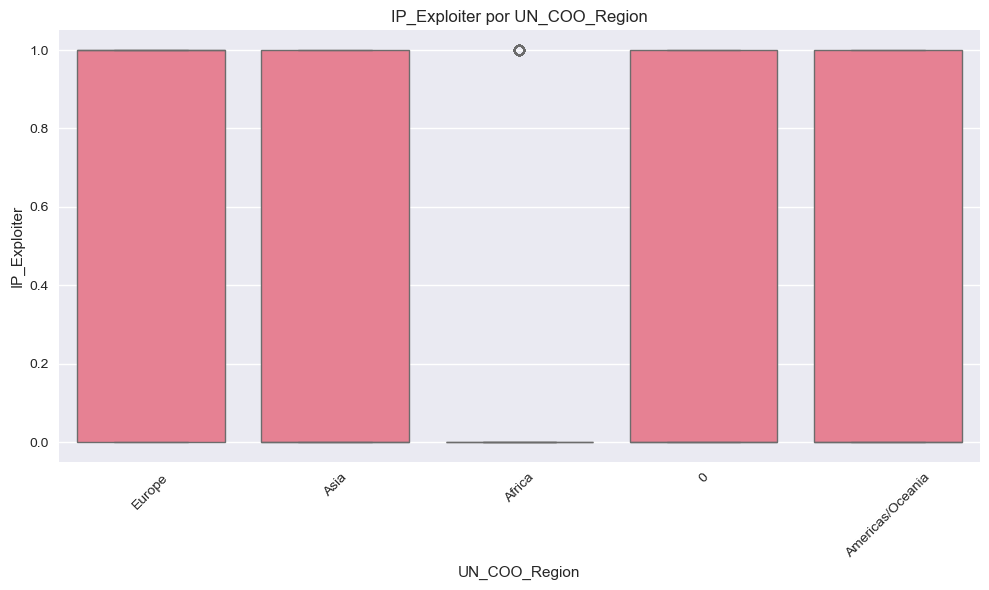


>>> UN_COO_Region x IP_RecruiterBroker
                   count      mean       std  min  25%  50%  75%  max
UN_COO_Region                                                        
0                 3610.0  0.495568  0.500050  0.0  0.0  0.0  1.0  1.0
Africa            5282.0  0.398145  0.489562  0.0  0.0  0.0  1.0  1.0
Americas/Oceania   277.0  0.393502  0.489411  0.0  0.0  0.0  1.0  1.0
Asia              6139.0  0.575664  0.494282  0.0  0.0  1.0  1.0  1.0
Europe            5887.0  0.735519  0.441094  0.0  0.0  1.0  1.0  1.0
ANOVA: F = 373.4000, p-value = 0.0000


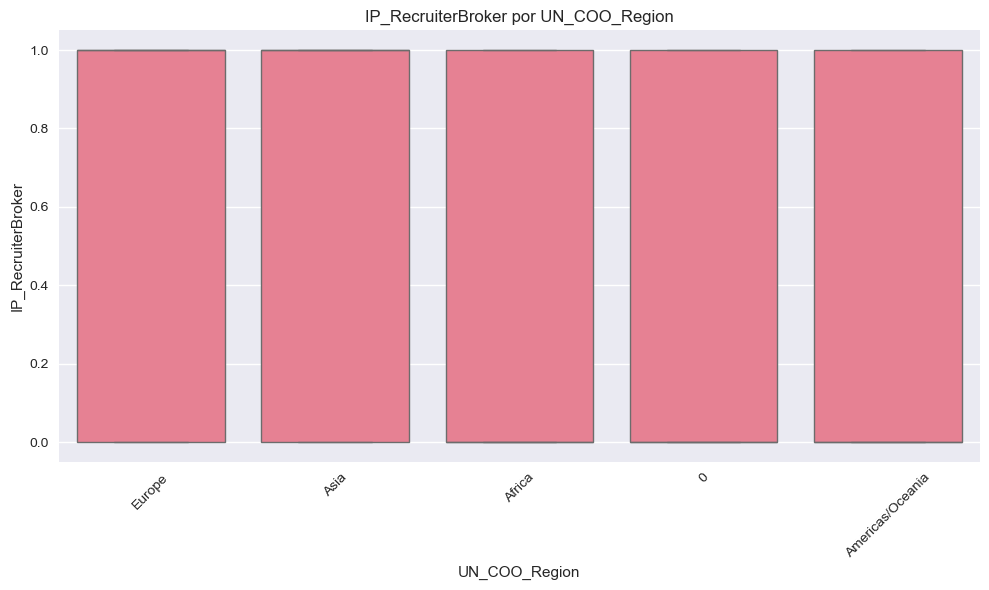


>>> UN_COO_Region x IP_TransactionProcess
                   count      mean       std  min  25%  50%  75%  max
UN_COO_Region                                                        
0                 3610.0  0.361219  0.480420  0.0  0.0  0.0  1.0  1.0
Africa            5282.0  0.407989  0.491508  0.0  0.0  0.0  1.0  1.0
Americas/Oceania   277.0  0.151625  0.359306  0.0  0.0  0.0  0.0  1.0
Asia              6139.0  0.294022  0.455639  0.0  0.0  0.0  1.0  1.0
Europe            5887.0  0.346187  0.475794  0.0  0.0  0.0  1.0  1.0
ANOVA: F = 53.7200, p-value = 0.0000


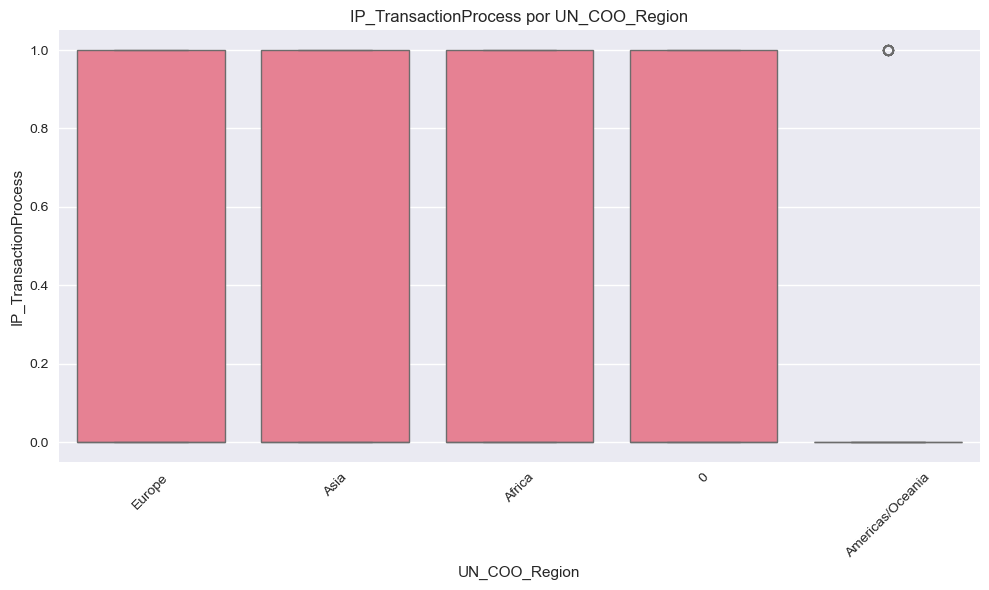


>>> UN_COO_Region x IP_ControlAbuseKidnap
                   count      mean       std  min  25%  50%  75%  max
UN_COO_Region                                                        
0                 3610.0  0.130194  0.336563  0.0  0.0  0.0  0.0  1.0
Africa            5282.0  0.121734  0.327010  0.0  0.0  0.0  0.0  1.0
Americas/Oceania   277.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Asia              6139.0  0.017267  0.130274  0.0  0.0  0.0  0.0  1.0
Europe            5887.0  0.145915  0.353051  0.0  0.0  0.0  0.0  1.0
ANOVA: F = 183.9744, p-value = 0.0000


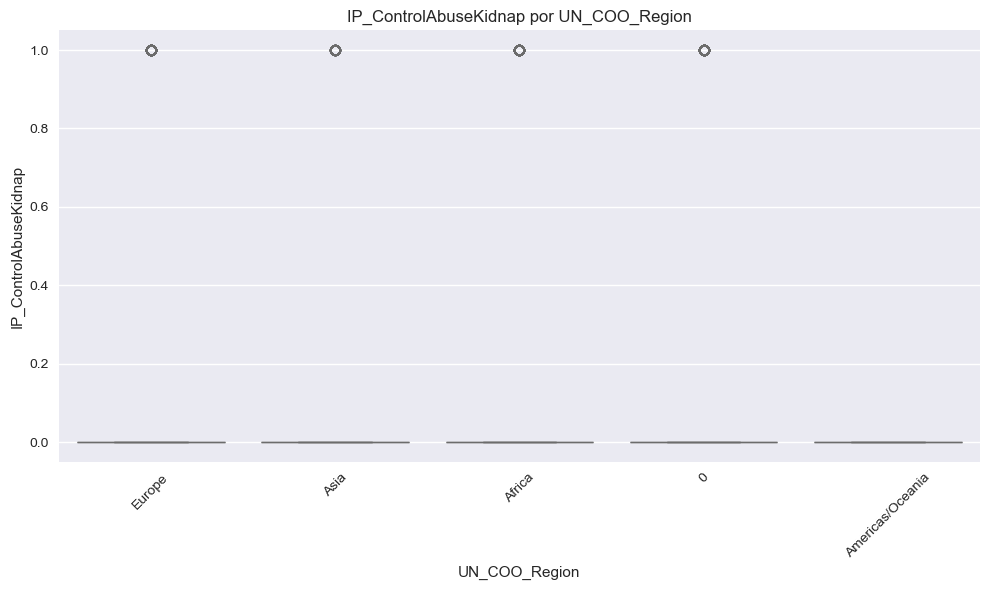


>>> UN_COE_Region x isForcedLabour
                   count      mean       std  min  25%  50%  75%  max
UN_COE_Region                                                        
0                 3999.0  0.452863  0.497835  0.0  0.0  0.0  1.0  1.0
Africa            4271.0  0.317022  0.465370  0.0  0.0  0.0  1.0  1.0
Americas/Oceania   212.0  0.273585  0.446854  0.0  0.0  0.0  1.0  1.0
Asia              6281.0  0.677281  0.467554  0.0  0.0  1.0  1.0  1.0
Europe            6432.0  0.741760  0.437701  0.0  0.0  1.0  1.0  1.0
ANOVA: F = 705.4123, p-value = 0.0000


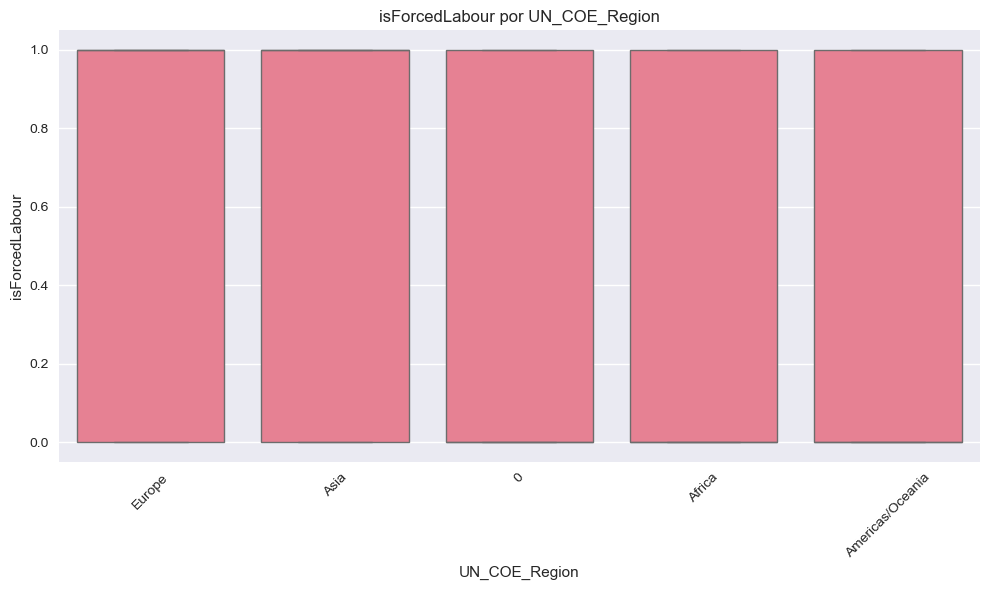


>>> UN_COE_Region x isSexualExploit
                   count      mean       std  min  25%  50%  75%  max
UN_COE_Region                                                        
0                 3999.0  0.151288  0.358374  0.0  0.0  0.0  0.0  1.0
Africa            4271.0  0.201358  0.401062  0.0  0.0  0.0  0.0  1.0
Americas/Oceania   212.0  0.207547  0.406511  0.0  0.0  0.0  0.0  1.0
Asia              6281.0  0.121796  0.327076  0.0  0.0  0.0  0.0  1.0
Europe            6432.0  0.077892  0.268022  0.0  0.0  0.0  0.0  1.0
ANOVA: F = 95.4947, p-value = 0.0000


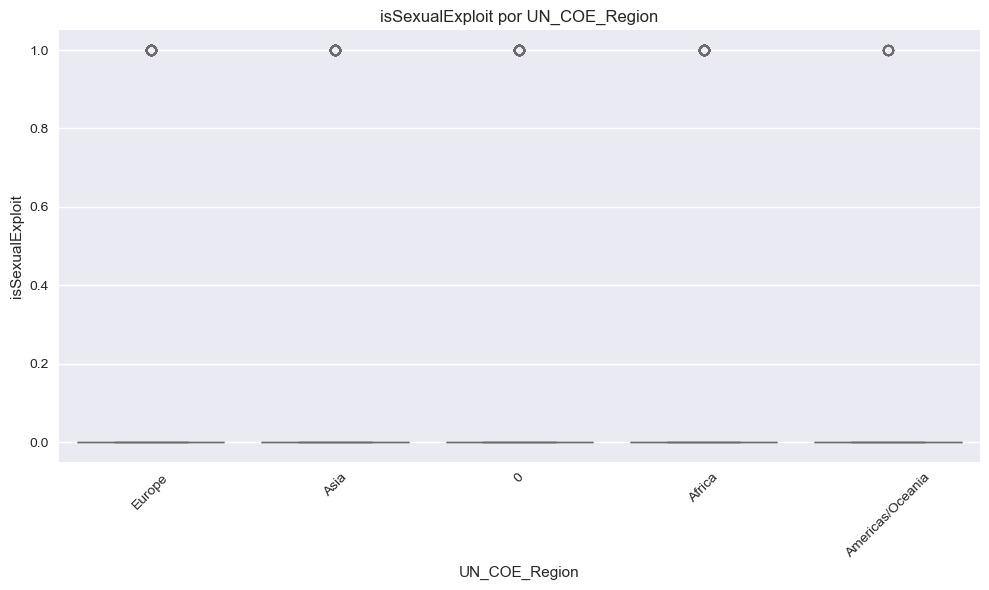


>>> UN_COE_Region x IP_Exploiter
                   count      mean       std  min  25%  50%  75%  max
UN_COE_Region                                                        
0                 3999.0  0.355089  0.478600  0.0  0.0  0.0  1.0  1.0
Africa            4271.0  0.269726  0.443869  0.0  0.0  0.0  1.0  1.0
Americas/Oceania   212.0  0.377358  0.485873  0.0  0.0  0.0  1.0  1.0
Asia              6281.0  0.349307  0.476789  0.0  0.0  0.0  1.0  1.0
Europe            6432.0  0.717040  0.450472  0.0  0.0  1.0  1.0  1.0
ANOVA: F = 814.5462, p-value = 0.0000


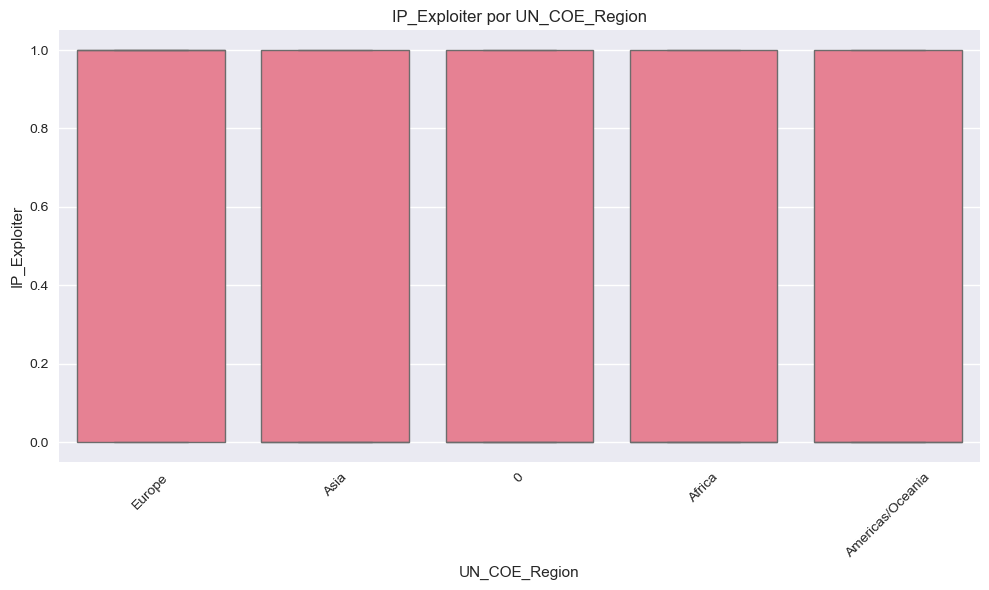


>>> UN_COE_Region x IP_RecruiterBroker
                   count      mean       std  min  25%  50%  75%  max
UN_COE_Region                                                        
0                 3999.0  0.469117  0.499108  0.0  0.0  0.0  1.0  1.0
Africa            4271.0  0.314212  0.464256  0.0  0.0  0.0  1.0  1.0
Americas/Oceania   212.0  0.443396  0.497962  0.0  0.0  0.0  1.0  1.0
Asia              6281.0  0.580003  0.493597  0.0  0.0  1.0  1.0  1.0
Europe            6432.0  0.763371  0.425046  0.0  1.0  1.0  1.0  1.0
ANOVA: F = 639.3495, p-value = 0.0000


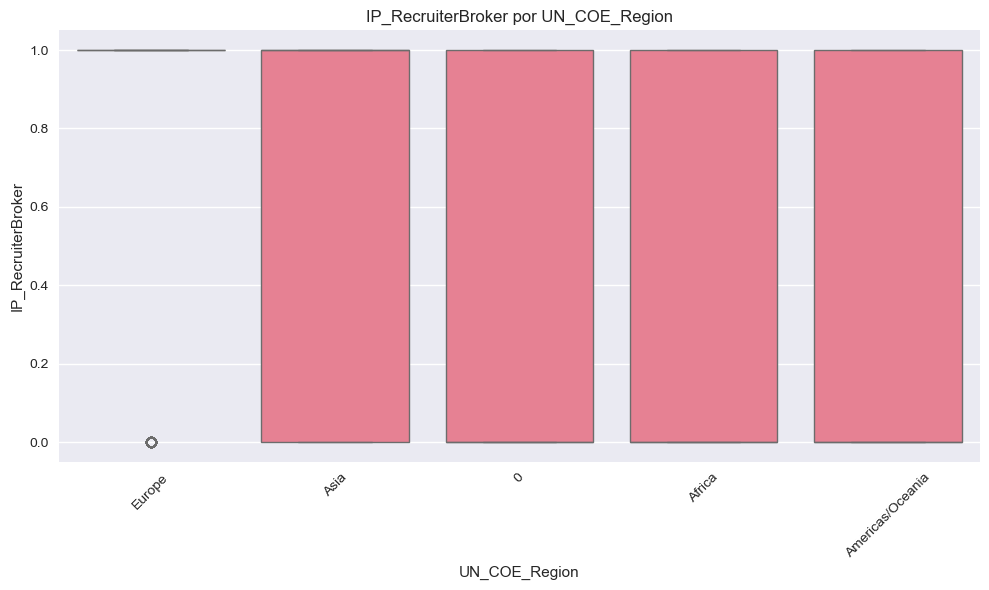


>>> UN_COE_Region x IP_TransactionProcess
                   count      mean       std  min  25%  50%  75%  max
UN_COE_Region                                                        
0                 3999.0  0.342836  0.474716  0.0  0.0  0.0  1.0  1.0
Africa            4271.0  0.406462  0.491230  0.0  0.0  0.0  1.0  1.0
Americas/Oceania   212.0  0.070755  0.257022  0.0  0.0  0.0  0.0  1.0
Asia              6281.0  0.337207  0.472794  0.0  0.0  0.0  1.0  1.0
Europe            6432.0  0.327114  0.469196  0.0  0.0  0.0  1.0  1.0
ANOVA: F = 38.3445, p-value = 0.0000


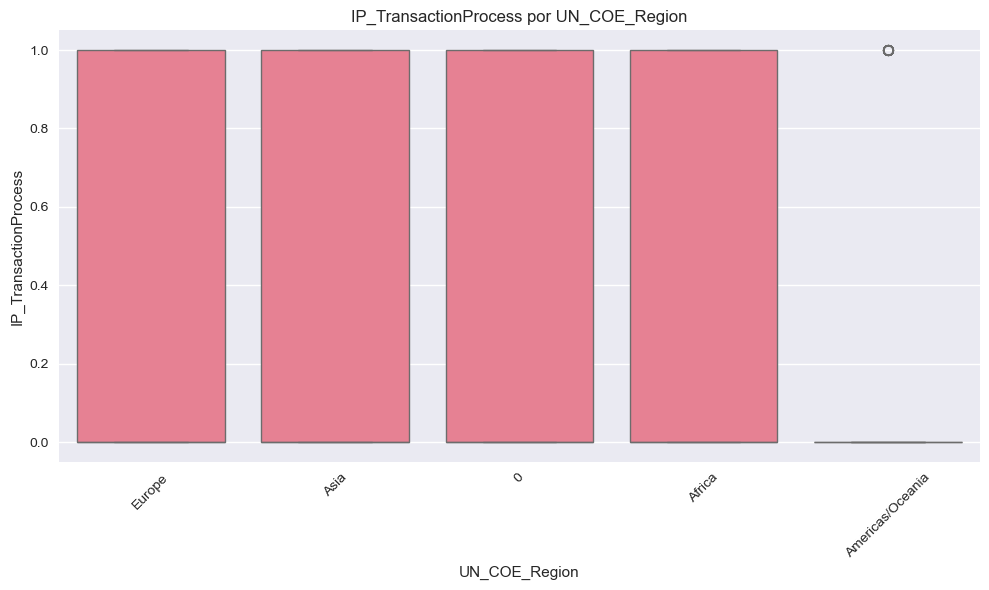


>>> UN_COE_Region x IP_ControlAbuseKidnap
                   count      mean       std  min  25%  50%  75%  max
UN_COE_Region                                                        
0                 3999.0  0.148537  0.355676  0.0  0.0  0.0  0.0  1.0
Africa            4271.0  0.155233  0.362169  0.0  0.0  0.0  0.0  1.0
Americas/Oceania   212.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Asia              6281.0  0.015125  0.122060  0.0  0.0  0.0  0.0  1.0
Europe            6432.0  0.112873  0.316462  0.0  0.0  0.0  0.0  1.0
ANOVA: F = 207.9737, p-value = 0.0000


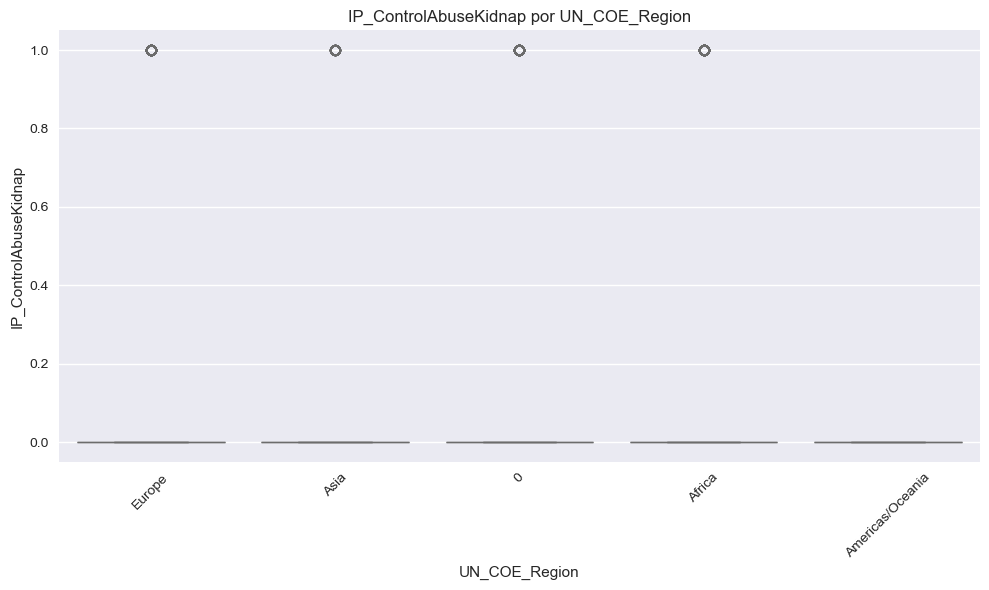


>>> IP_Gender x isForcedLabour
              count      mean       std  min  25%  50%  75%  max
IP_Gender                                                       
0            5408.0  0.330436  0.470414  0.0  0.0  0.0  1.0  1.0
Female       3515.0  0.522617  0.499559  0.0  0.0  1.0  1.0  1.0
Female;Male  2452.0  0.739396  0.439053  0.0  0.0  1.0  1.0  1.0
Male         9820.0  0.693585  0.461028  0.0  0.0  1.0  1.0  1.0
ANOVA: F = 819.1866, p-value = 0.0000


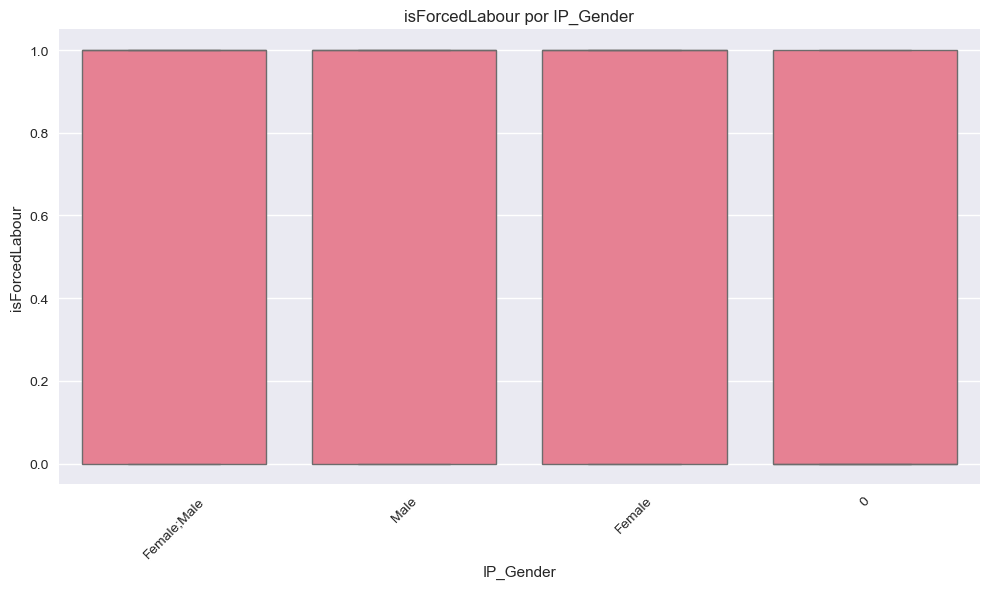


>>> IP_Gender x isSexualExploit
              count      mean       std  min  25%  50%  75%  max
IP_Gender                                                       
0            5408.0  0.115385  0.319515  0.0  0.0  0.0  0.0  1.0
Female       3515.0  0.255477  0.436191  0.0  0.0  0.0  1.0  1.0
Female;Male  2452.0  0.169657  0.375408  0.0  0.0  0.0  0.0  1.0
Male         9820.0  0.085234  0.279244  0.0  0.0  0.0  0.0  1.0
ANOVA: F = 242.3979, p-value = 0.0000


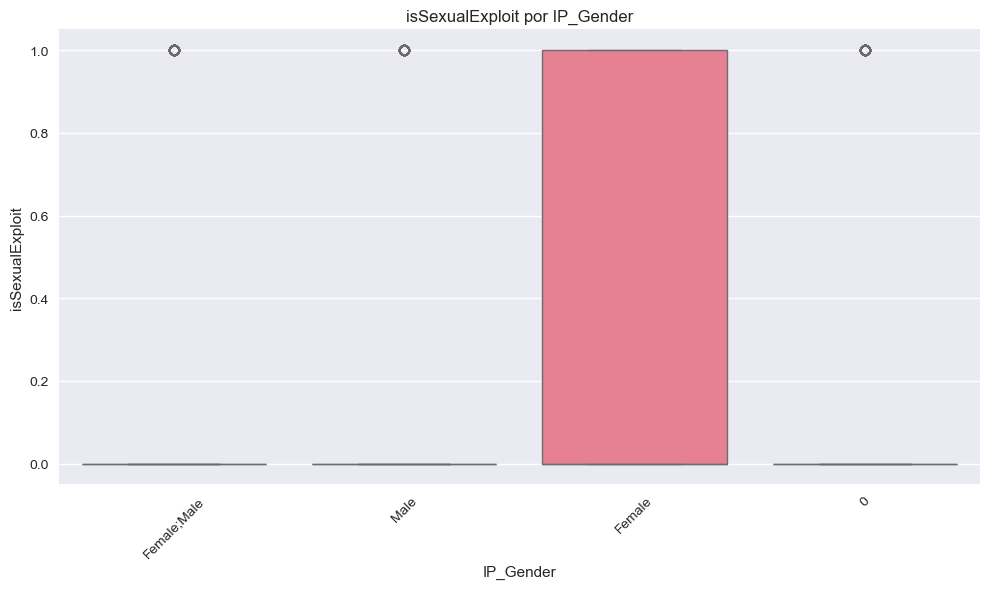


>>> IP_Gender x IP_Exploiter
              count      mean       std  min  25%  50%  75%  max
IP_Gender                                                       
0            5408.0  0.203772  0.402839  0.0  0.0  0.0  0.0  1.0
Female       3515.0  0.340541  0.473958  0.0  0.0  0.0  1.0  1.0
Female;Male  2452.0  0.800571  0.399653  0.0  1.0  1.0  1.0  1.0
Male         9820.0  0.529124  0.499176  0.0  0.0  1.0  1.0  1.0
ANOVA: F = 1148.5746, p-value = 0.0000


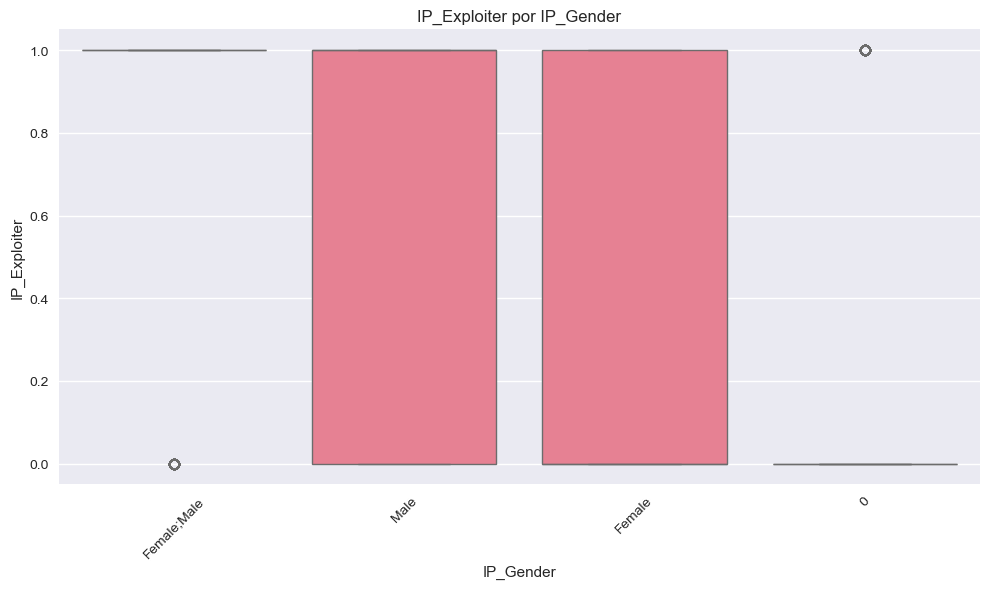


>>> IP_Gender x IP_RecruiterBroker
              count      mean       std  min  25%  50%  75%  max
IP_Gender                                                       
0            5408.0  0.299556  0.458106  0.0  0.0  0.0  1.0  1.0
Female       3515.0  0.559886  0.496471  0.0  0.0  1.0  1.0  1.0
Female;Male  2452.0  0.896819  0.304257  0.0  1.0  1.0  1.0  1.0
Male         9820.0  0.618941  0.485672  0.0  0.0  1.0  1.0  1.0
ANOVA: F = 1055.7271, p-value = 0.0000


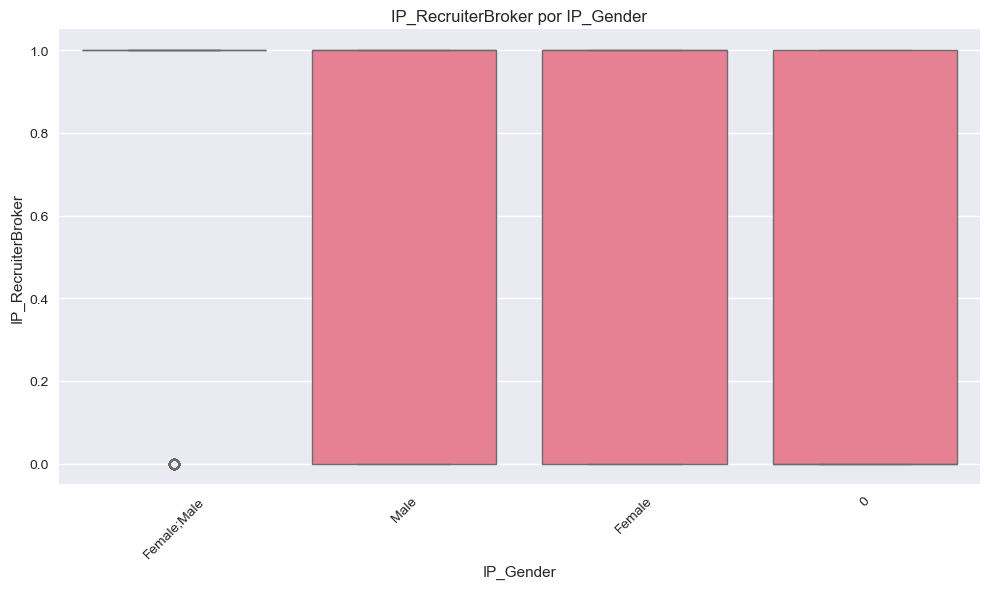


>>> IP_Gender x IP_TransactionProcess
              count      mean       std  min  25%  50%  75%  max
IP_Gender                                                       
0            5408.0  0.186575  0.389606  0.0  0.0  0.0  0.0  1.0
Female       3515.0  0.394879  0.488894  0.0  0.0  0.0  1.0  1.0
Female;Male  2452.0  0.482055  0.499780  0.0  0.0  0.0  1.0  1.0
Male         9820.0  0.383401  0.486239  0.0  0.0  0.0  1.0  1.0
ANOVA: F = 315.1333, p-value = 0.0000


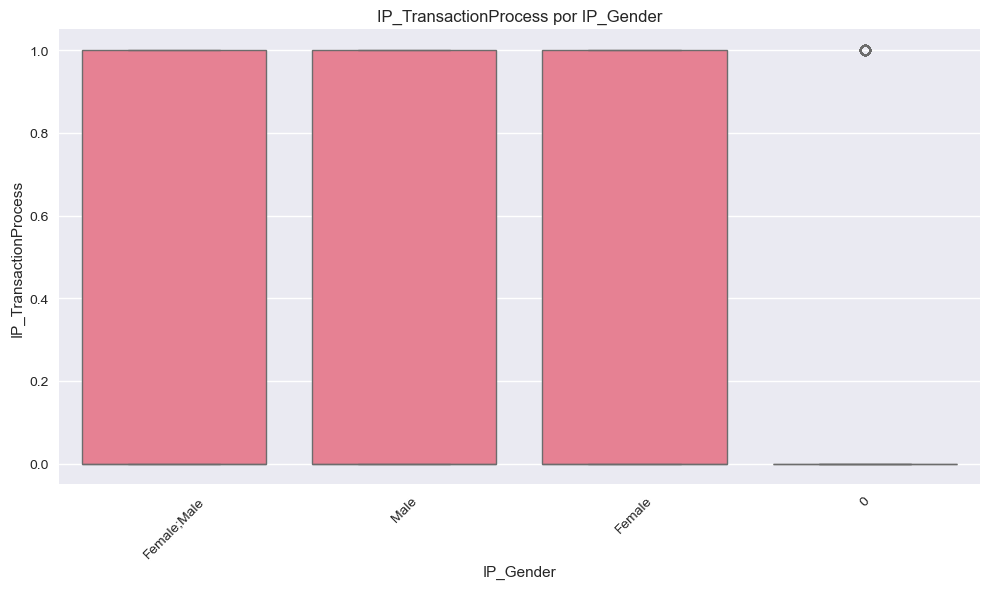


>>> IP_Gender x IP_ControlAbuseKidnap
              count      mean       std  min  25%  50%  75%  max
IP_Gender                                                       
0            5408.0  0.070451  0.255930  0.0  0.0  0.0  0.0  1.0
Female       3515.0  0.081366  0.273435  0.0  0.0  0.0  0.0  1.0
Female;Male  2452.0  0.083605  0.276851  0.0  0.0  0.0  0.0  1.0
Male         9820.0  0.122811  0.328236  0.0  0.0  0.0  0.0  1.0
ANOVA: F = 44.1037, p-value = 0.0000


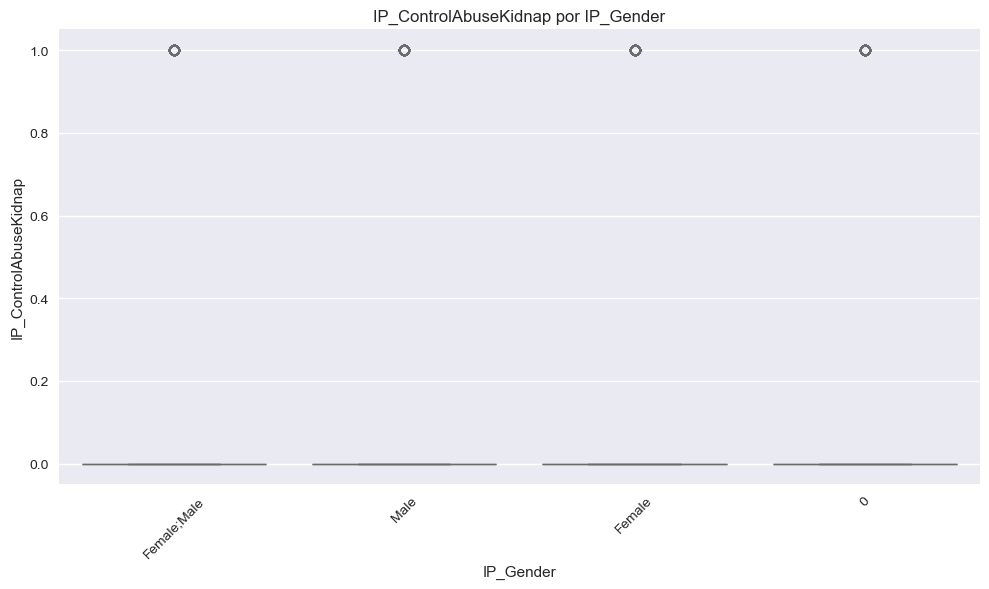


>>> IP_ageBroad x isForcedLabour
                 count      mean       std  min  25%  50%   75%  max
IP_ageBroad                                                         
0              17993.0  0.584783  0.492773  0.0  0.0  1.0  1.00  1.0
0--29            306.0  0.310458  0.463439  0.0  0.0  0.0  1.00  1.0
0--29;30--38       8.0  0.000000  0.000000  0.0  0.0  0.0  0.00  0.0
0--29;39--47      18.0  0.000000  0.000000  0.0  0.0  0.0  0.00  0.0
30--38          1196.0  0.561873  0.496365  0.0  0.0  1.0  1.00  1.0
30--38;39--47     18.0  0.666667  0.485071  0.0  0.0  1.0  1.00  1.0
30--38;48+         3.0  0.000000  0.000000  0.0  0.0  0.0  0.00  0.0
39--47          1293.0  0.621810  0.485123  0.0  0.0  1.0  1.00  1.0
39--47;48+         4.0  0.250000  0.500000  0.0  0.0  0.0  0.25  1.0
48+              356.0  0.398876  0.490356  0.0  0.0  0.0  1.00  1.0
ANOVA: F = 21.6899, p-value = 0.0000


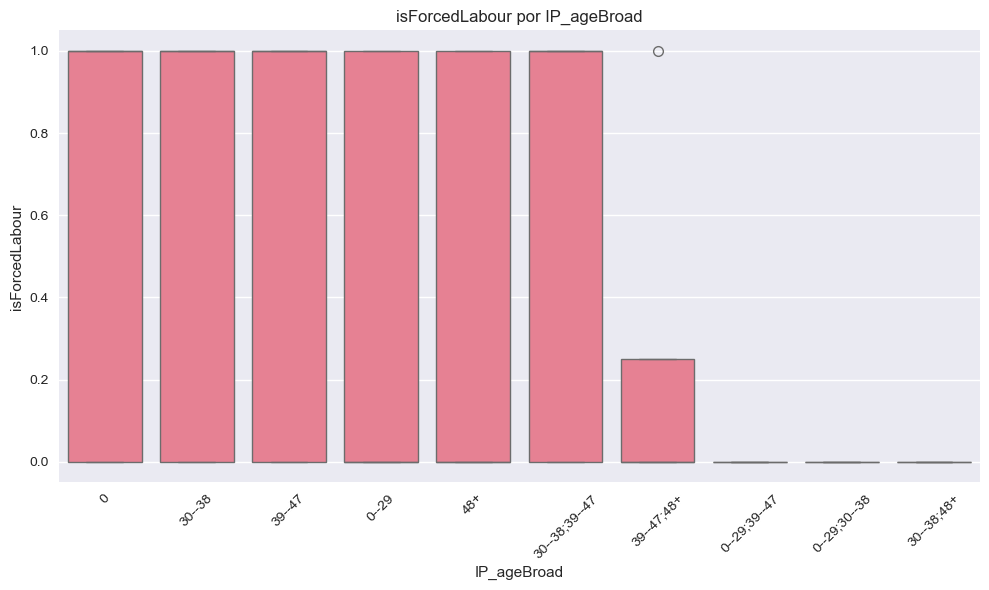


>>> IP_ageBroad x isSexualExploit
                 count      mean       std  min  25%  50%  75%  max
IP_ageBroad                                                        
0              17993.0  0.140666  0.347686  0.0  0.0  0.0  0.0  1.0
0--29            306.0  0.058824  0.235680  0.0  0.0  0.0  0.0  1.0
0--29;30--38       8.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
0--29;39--47      18.0  0.055556  0.235702  0.0  0.0  0.0  0.0  1.0
30--38          1196.0  0.116221  0.320624  0.0  0.0  0.0  0.0  1.0
30--38;39--47     18.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
30--38;48+         3.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
39--47          1293.0  0.066512  0.249271  0.0  0.0  0.0  0.0  1.0
39--47;48+         4.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
48+              356.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
ANOVA: F = 15.4159, p-value = 0.0000


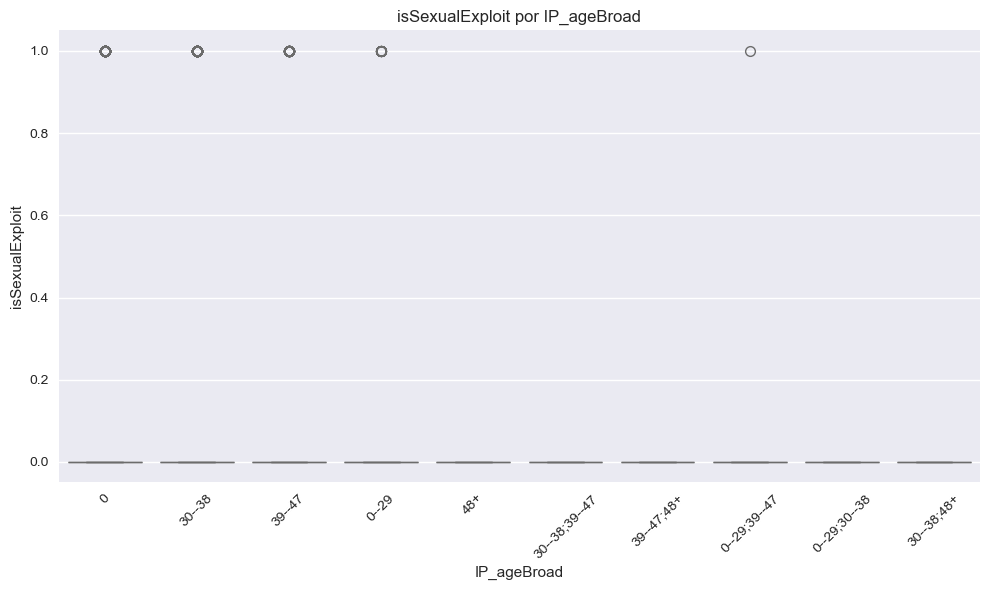


>>> IP_ageBroad x IP_Exploiter
                 count      mean       std  min  25%  50%  75%  max
IP_ageBroad                                                        
0              17993.0  0.502529  0.500008  0.0  0.0  1.0  1.0  1.0
0--29            306.0  0.071895  0.258738  0.0  0.0  0.0  0.0  1.0
0--29;30--38       8.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
0--29;39--47      18.0  0.111111  0.323381  0.0  0.0  0.0  0.0  1.0
30--38          1196.0  0.152174  0.359340  0.0  0.0  0.0  0.0  1.0
30--38;39--47     18.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
30--38;48+         3.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
39--47          1293.0  0.152359  0.359507  0.0  0.0  0.0  0.0  1.0
39--47;48+         4.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
48+              356.0  0.036517  0.187836  0.0  0.0  0.0  0.0  1.0
ANOVA: F = 185.8912, p-value = 0.0000


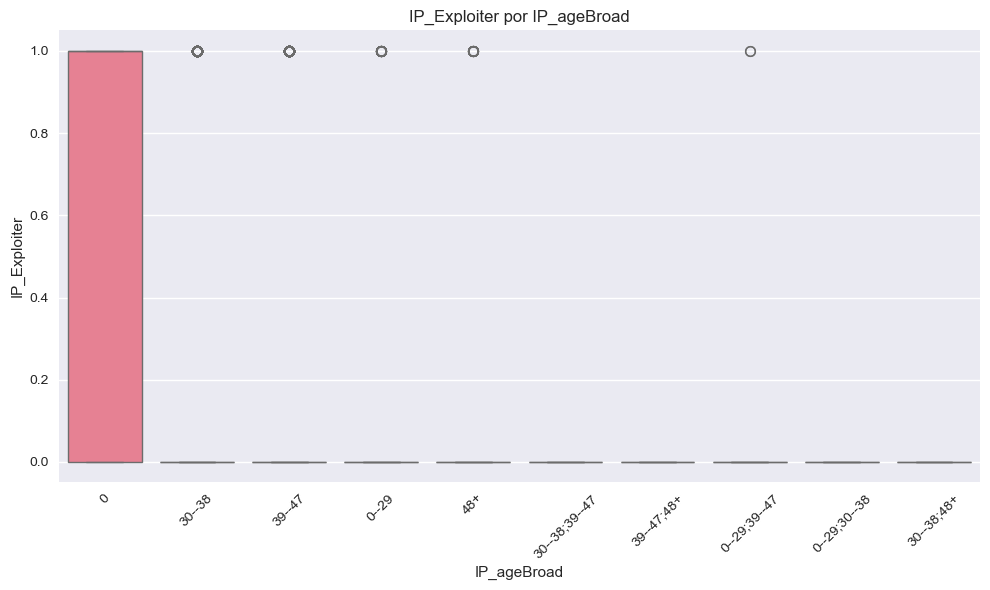


>>> IP_ageBroad x IP_RecruiterBroker
                 count      mean       std  min  25%  50%   75%  max
IP_ageBroad                                                         
0              17993.0  0.604568  0.488957  0.0  0.0  1.0  1.00  1.0
0--29            306.0  0.189542  0.392581  0.0  0.0  0.0  0.00  1.0
0--29;30--38       8.0  0.500000  0.534522  0.0  0.0  0.5  1.00  1.0
0--29;39--47      18.0  0.055556  0.235702  0.0  0.0  0.0  0.00  1.0
30--38          1196.0  0.318562  0.466114  0.0  0.0  0.0  1.00  1.0
30--38;39--47     18.0  0.277778  0.460889  0.0  0.0  0.0  0.75  1.0
30--38;48+         3.0  0.000000  0.000000  0.0  0.0  0.0  0.00  0.0
39--47          1293.0  0.366589  0.482059  0.0  0.0  0.0  1.00  1.0
39--47;48+         4.0  0.000000  0.000000  0.0  0.0  0.0  0.00  0.0
48+              356.0  0.179775  0.384541  0.0  0.0  0.0  0.00  1.0
ANOVA: F = 121.0846, p-value = 0.0000


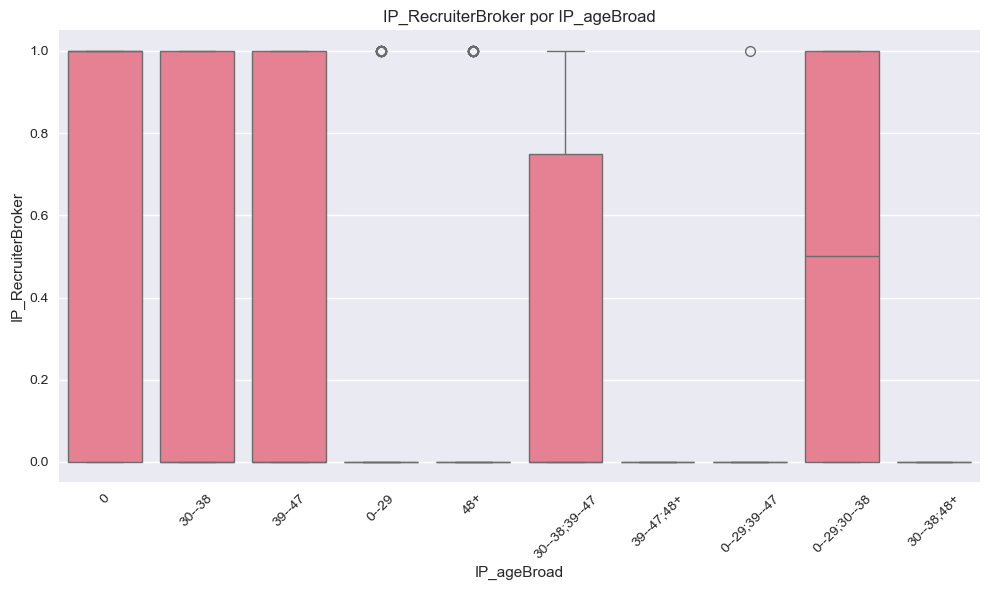


>>> IP_ageBroad x IP_TransactionProcess
                 count      mean       std  min  25%  50%   75%  max
IP_ageBroad                                                         
0              17993.0  0.337742  0.472953  0.0  0.0  0.0  1.00  1.0
0--29            306.0  0.287582  0.453376  0.0  0.0  0.0  1.00  1.0
0--29;30--38       8.0  0.250000  0.462910  0.0  0.0  0.0  0.25  1.0
0--29;39--47      18.0  0.000000  0.000000  0.0  0.0  0.0  0.00  0.0
30--38          1196.0  0.428930  0.495130  0.0  0.0  0.0  1.00  1.0
30--38;39--47     18.0  0.277778  0.460889  0.0  0.0  0.0  0.75  1.0
30--38;48+         3.0  0.000000  0.000000  0.0  0.0  0.0  0.00  0.0
39--47          1293.0  0.439288  0.496492  0.0  0.0  0.0  1.00  1.0
39--47;48+         4.0  0.250000  0.500000  0.0  0.0  0.0  0.25  1.0
48+              356.0  0.252809  0.435234  0.0  0.0  0.0  1.00  1.0
ANOVA: F = 13.5873, p-value = 0.0000


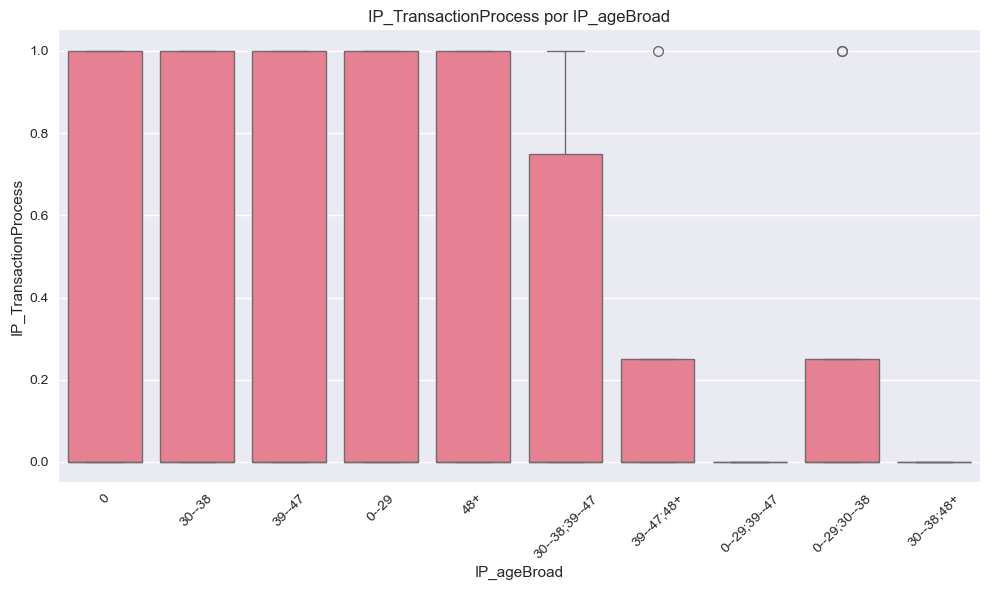


>>> IP_ageBroad x IP_ControlAbuseKidnap
                 count      mean       std  min  25%  50%  75%  max
IP_ageBroad                                                        
0              17993.0  0.103207  0.304237  0.0  0.0  0.0  0.0  1.0
0--29            306.0  0.022876  0.149752  0.0  0.0  0.0  0.0  1.0
0--29;30--38       8.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
0--29;39--47      18.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
30--38          1196.0  0.082776  0.275658  0.0  0.0  0.0  0.0  1.0
30--38;39--47     18.0  0.055556  0.235702  0.0  0.0  0.0  0.0  1.0
30--38;48+         3.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
39--47          1293.0  0.078113  0.268453  0.0  0.0  0.0  0.0  1.0
39--47;48+         4.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
48+              356.0  0.036517  0.187836  0.0  0.0  0.0  0.0  1.0
ANOVA: F = 5.9155, p-value = 0.0000


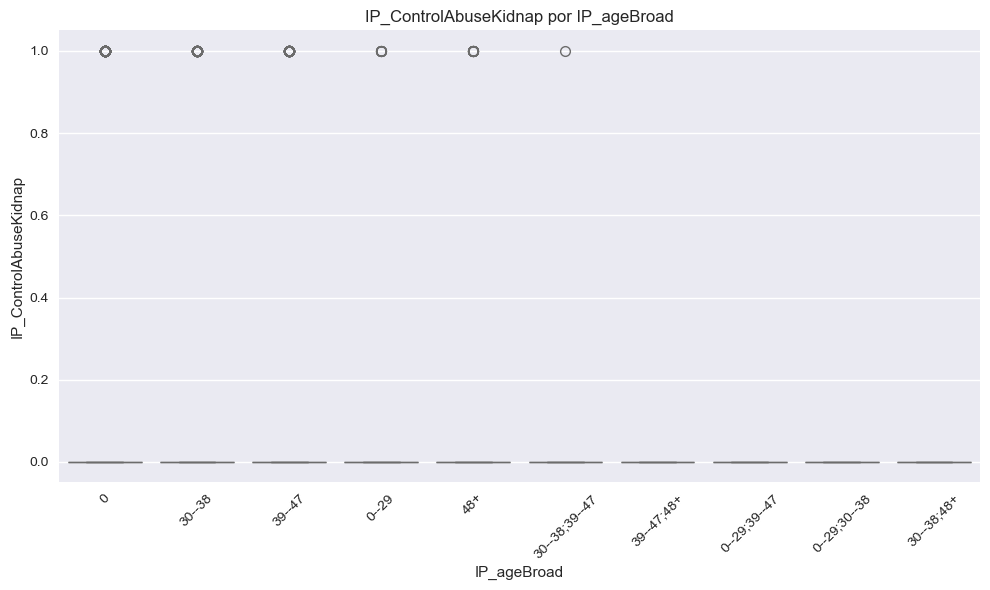


>>> IP_citizen_UNRegion x isForcedLabour
                          count      mean       std  min  25%  50%   75%  max
IP_citizen_UNRegion                                                          
0                        6946.0  0.406565  0.491228  0.0  0.0  0.0  1.00  1.0
Africa                   3799.0  0.426691  0.494662  0.0  0.0  0.0  1.00  1.0
Africa;Americas/Oceania     4.0  0.250000  0.500000  0.0  0.0  0.0  0.25  1.0
Africa;Asia               420.0  0.807143  0.395012  0.0  1.0  1.0  1.00  1.0
Americas/Oceania          200.0  0.120000  0.325777  0.0  0.0  0.0  0.00  1.0
Americas/Oceania;Asia       6.0  0.000000  0.000000  0.0  0.0  0.0  0.00  0.0
Americas/Oceania;Europe     1.0  0.000000       NaN  0.0  0.0  0.0  0.00  0.0
Asia                     5069.0  0.751430  0.432226  0.0  1.0  1.0  1.00  1.0
Asia;Europe               382.0  0.641361  0.480230  0.0  0.0  1.0  1.00  1.0
Europe                   4368.0  0.774954  0.417660  0.0  1.0  1.0  1.00  1.0
ANOVA: F = 401.7394, p

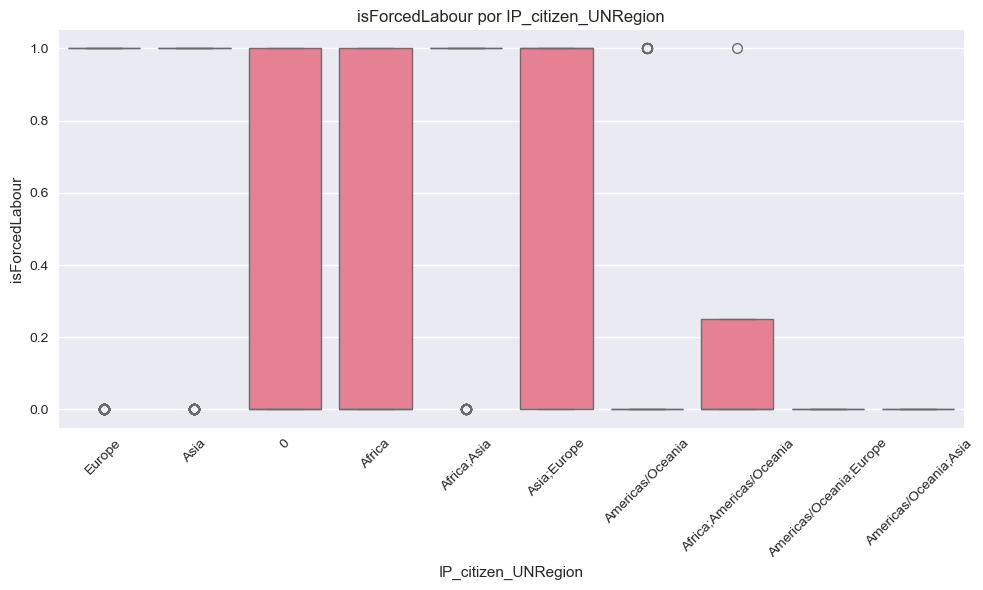


>>> IP_citizen_UNRegion x isSexualExploit
                          count      mean       std  min  25%  50%  75%  max
IP_citizen_UNRegion                                                         
0                        6946.0  0.129139  0.335378  0.0  0.0  0.0  0.0  1.0
Africa                   3799.0  0.232166  0.422270  0.0  0.0  0.0  0.0  1.0
Africa;Americas/Oceania     4.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Africa;Asia               420.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Americas/Oceania          200.0  0.220000  0.415286  0.0  0.0  0.0  0.0  1.0
Americas/Oceania;Asia       6.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Americas/Oceania;Europe     1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0
Asia                     5069.0  0.112054  0.315464  0.0  0.0  0.0  0.0  1.0
Asia;Europe               382.0  0.078534  0.269363  0.0  0.0  0.0  0.0  1.0
Europe                   4368.0  0.081044  0.272934  0.0  0.0  0.0  0.0  1.0
ANOVA: F = 69.4599, p-value = 0.0

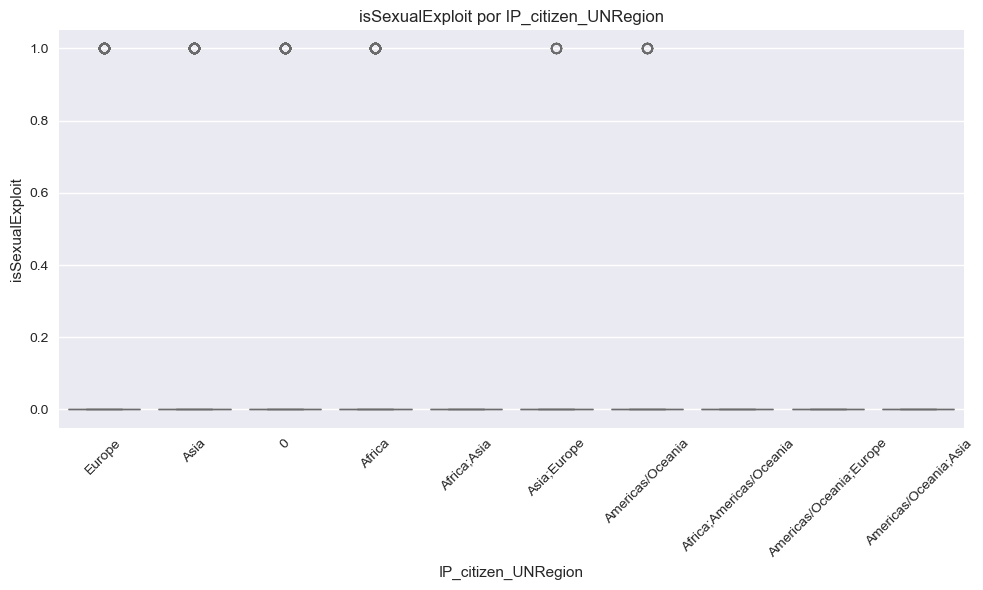


>>> IP_citizen_UNRegion x IP_Exploiter
                          count      mean       std  min  25%  50%   75%  max
IP_citizen_UNRegion                                                          
0                        6946.0  0.333429  0.471472  0.0  0.0  0.0  1.00  1.0
Africa                   3799.0  0.300079  0.458352  0.0  0.0  0.0  1.00  1.0
Africa;Americas/Oceania     4.0  0.250000  0.500000  0.0  0.0  0.0  0.25  1.0
Africa;Asia               420.0  0.147619  0.355145  0.0  0.0  0.0  0.00  1.0
Americas/Oceania          200.0  0.410000  0.493068  0.0  0.0  0.0  1.00  1.0
Americas/Oceania;Asia       6.0  0.000000  0.000000  0.0  0.0  0.0  0.00  0.0
Americas/Oceania;Europe     1.0  1.000000       NaN  1.0  1.0  1.0  1.00  1.0
Asia                     5069.0  0.422766  0.494048  0.0  0.0  0.0  1.00  1.0
Asia;Europe               382.0  0.753927  0.431287  0.0  1.0  1.0  1.00  1.0
Europe                   4368.0  0.784112  0.411484  0.0  1.0  1.0  1.00  1.0
ANOVA: F = 440.0110, p-v

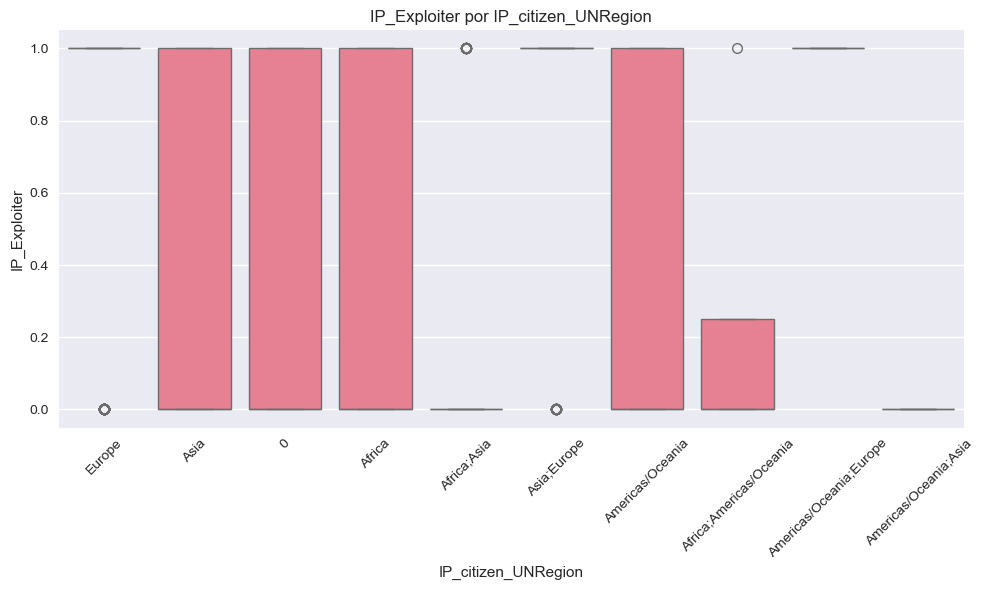


>>> IP_citizen_UNRegion x IP_RecruiterBroker
                          count      mean       std  min  25%  50%  75%  max
IP_citizen_UNRegion                                                         
0                        6946.0  0.406565  0.491228  0.0  0.0  0.0  1.0  1.0
Africa                   3799.0  0.419058  0.493470  0.0  0.0  0.0  1.0  1.0
Africa;Americas/Oceania     4.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Africa;Asia               420.0  0.769048  0.421945  0.0  1.0  1.0  1.0  1.0
Americas/Oceania          200.0  0.445000  0.498213  0.0  0.0  0.0  1.0  1.0
Americas/Oceania;Asia       6.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Americas/Oceania;Europe     1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0
Asia                     5069.0  0.597159  0.490518  0.0  0.0  1.0  1.0  1.0
Asia;Europe               382.0  0.858639  0.348851  0.0  1.0  1.0  1.0  1.0
Europe                   4368.0  0.842949  0.363891  0.0  1.0  1.0  1.0  1.0
ANOVA: F = 379.0098, p-value =

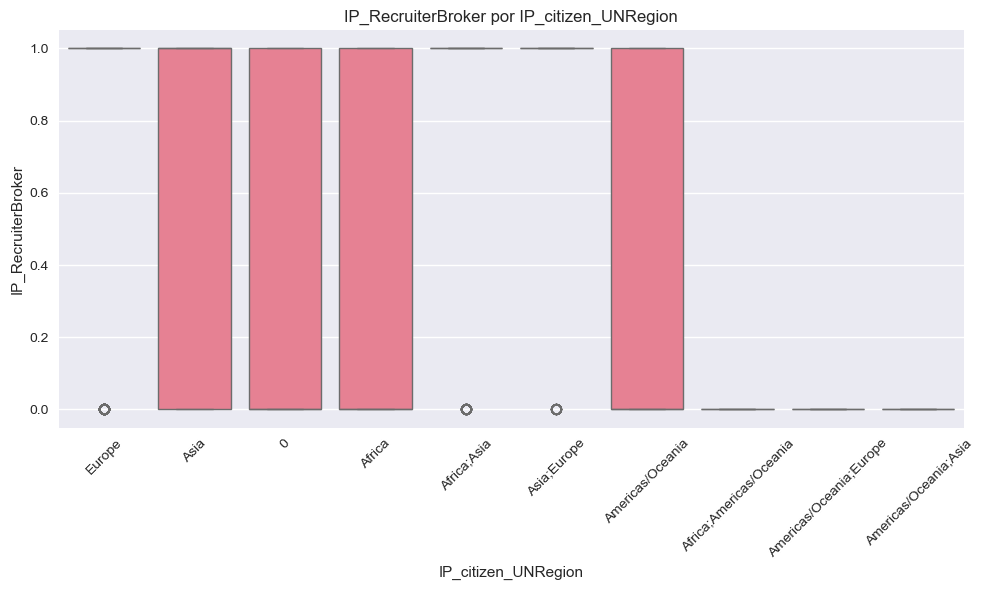


>>> IP_citizen_UNRegion x IP_TransactionProcess
                          count      mean       std  min  25%  50%  75%  max
IP_citizen_UNRegion                                                         
0                        6946.0  0.256838  0.436921  0.0  0.0  0.0  1.0  1.0
Africa                   3799.0  0.453804  0.497927  0.0  0.0  0.0  1.0  1.0
Africa;Americas/Oceania     4.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Africa;Asia               420.0  0.566667  0.496127  0.0  0.0  1.0  1.0  1.0
Americas/Oceania          200.0  0.190000  0.393285  0.0  0.0  0.0  0.0  1.0
Americas/Oceania;Asia       6.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Americas/Oceania;Europe     1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0
Asia                     5069.0  0.367528  0.482179  0.0  0.0  0.0  1.0  1.0
Asia;Europe               382.0  0.321990  0.467852  0.0  0.0  0.0  1.0  1.0
Europe                   4368.0  0.360348  0.480156  0.0  0.0  0.0  1.0  1.0
ANOVA: F = 73.3494, p-value

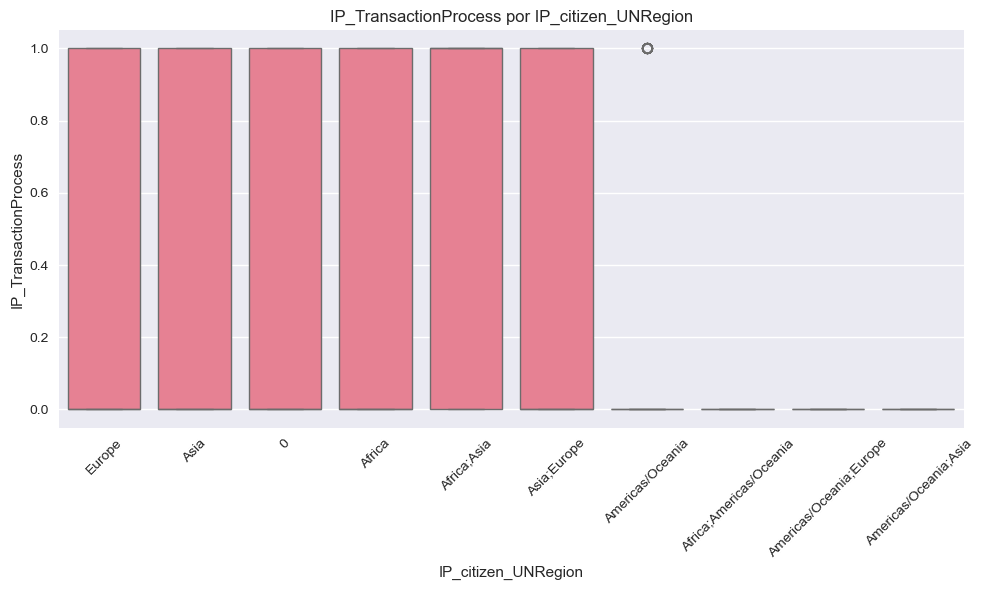


>>> IP_citizen_UNRegion x IP_ControlAbuseKidnap
                          count      mean       std  min  25%  50%  75%  max
IP_citizen_UNRegion                                                         
0                        6946.0  0.091707  0.288633  0.0  0.0  0.0  0.0  1.0
Africa                   3799.0  0.168202  0.374095  0.0  0.0  0.0  0.0  1.0
Africa;Americas/Oceania     4.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Africa;Asia               420.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Americas/Oceania          200.0  0.010000  0.099748  0.0  0.0  0.0  0.0  1.0
Americas/Oceania;Asia       6.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Americas/Oceania;Europe     1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0
Asia                     5069.0  0.019728  0.139077  0.0  0.0  0.0  0.0  1.0
Asia;Europe               382.0  0.002618  0.051164  0.0  0.0  0.0  0.0  1.0
Europe                   4368.0  0.160027  0.366674  0.0  0.0  0.0  0.0  1.0
ANOVA: F = 111.9372, p-valu

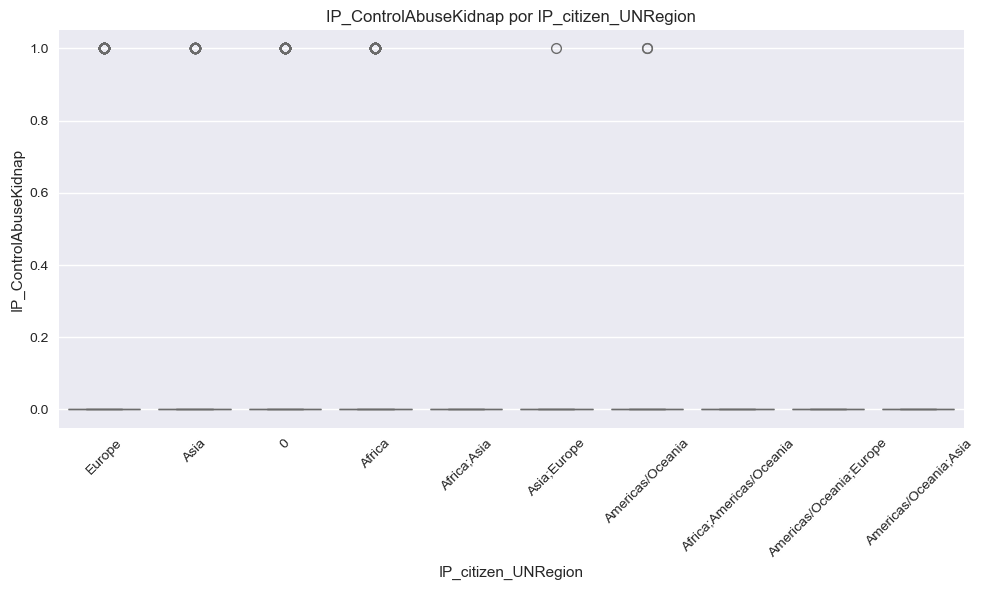


>>> IP_Relation x isForcedLabour
                                             count      mean       std  min  \
IP_Relation                                                                   
0                                           6623.0  0.329005  0.469887  0.0   
FamilyIntimatePartner                        967.0  0.476732  0.499717  0.0   
FamilyIntimatePartner;FriendAcquaintance       6.0  0.000000  0.000000  0.0   
FamilyIntimatePartner;StrangerUnknownOther    73.0  0.520548  0.503035  0.0   
FriendAcquaintance                          4617.0  0.664717  0.472140  0.0   
FriendAcquaintance;StrangerUnknownOther      588.0  0.739796  0.439119  0.0   
StrangerUnknownOther                        8321.0  0.728999  0.444503  0.0   

                                            25%  50%  75%  max  
IP_Relation                                                     
0                                           0.0  0.0  1.0  1.0  
FamilyIntimatePartner                       0.0  0.0  1.0  

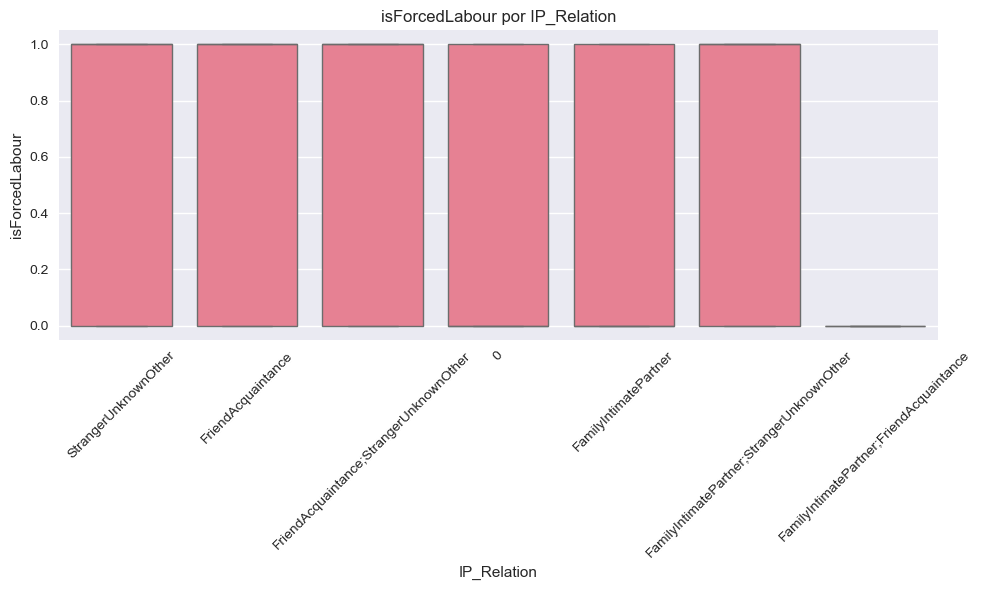


>>> IP_Relation x isSexualExploit
                                             count      mean       std  min  \
IP_Relation                                                                   
0                                           6623.0  0.171674  0.377126  0.0   
FamilyIntimatePartner                        967.0  0.206825  0.405239  0.0   
FamilyIntimatePartner;FriendAcquaintance       6.0  0.000000  0.000000  0.0   
FamilyIntimatePartner;StrangerUnknownOther    73.0  0.000000  0.000000  0.0   
FriendAcquaintance                          4617.0  0.179121  0.383495  0.0   
FriendAcquaintance;StrangerUnknownOther      588.0  0.030612  0.172411  0.0   
StrangerUnknownOther                        8321.0  0.071265  0.257283  0.0   

                                            25%  50%  75%  max  
IP_Relation                                                     
0                                           0.0  0.0  0.0  1.0  
FamilyIntimatePartner                       0.0  0.0  0.0 

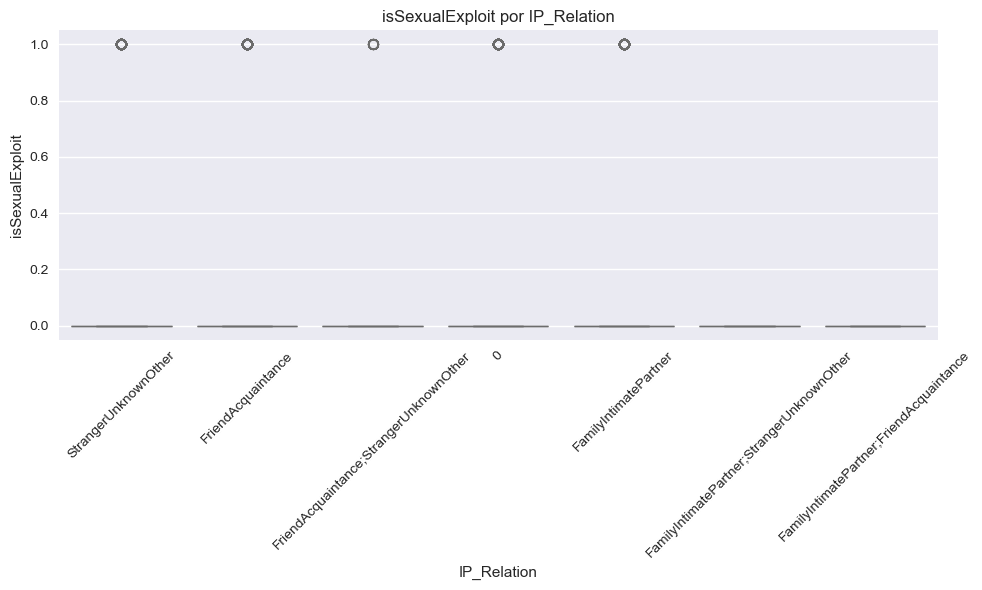


>>> IP_Relation x IP_Exploiter
                                             count      mean       std  min  \
IP_Relation                                                                   
0                                           6623.0  0.332327  0.471083  0.0   
FamilyIntimatePartner                        967.0  0.355739  0.478984  0.0   
FamilyIntimatePartner;FriendAcquaintance       6.0  0.333333  0.516398  0.0   
FamilyIntimatePartner;StrangerUnknownOther    73.0  0.328767  0.473016  0.0   
FriendAcquaintance                          4617.0  0.457007  0.498202  0.0   
FriendAcquaintance;StrangerUnknownOther      588.0  0.688776  0.463389  0.0   
StrangerUnknownOther                        8321.0  0.525418  0.499384  0.0   

                                            25%  50%   75%  max  
IP_Relation                                                      
0                                           0.0  0.0  1.00  1.0  
FamilyIntimatePartner                       0.0  0.0  1.00

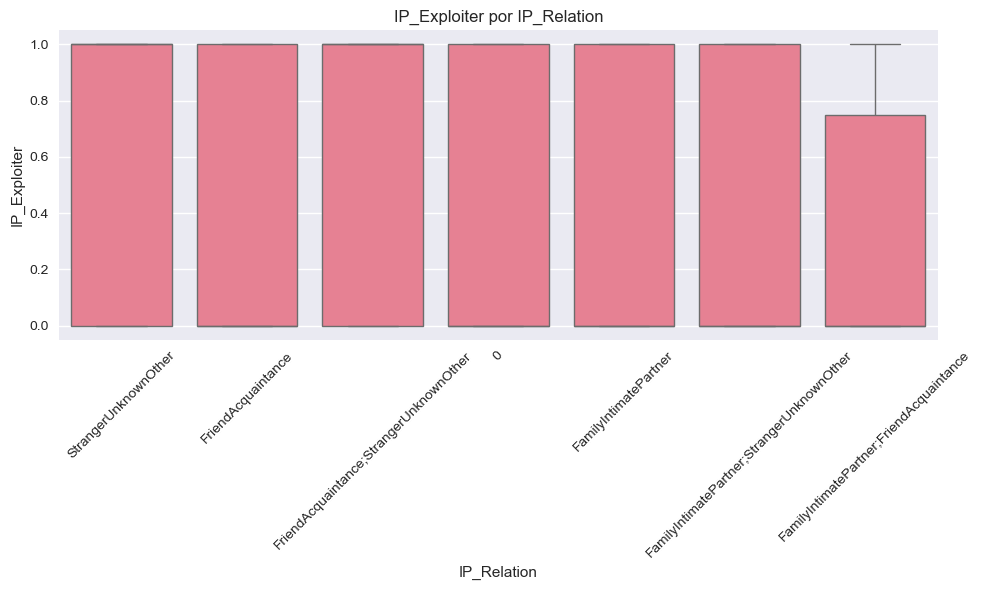


>>> IP_Relation x IP_RecruiterBroker
                                             count      mean       std  min  \
IP_Relation                                                                   
0                                           6623.0  0.361317  0.480418  0.0   
FamilyIntimatePartner                        967.0  0.434333  0.495926  0.0   
FamilyIntimatePartner;FriendAcquaintance       6.0  0.000000  0.000000  0.0   
FamilyIntimatePartner;StrangerUnknownOther    73.0  0.520548  0.503035  0.0   
FriendAcquaintance                          4617.0  0.655187  0.475359  0.0   
FriendAcquaintance;StrangerUnknownOther      588.0  0.802721  0.398283  0.0   
StrangerUnknownOther                        8321.0  0.663021  0.472706  0.0   

                                            25%  50%  75%  max  
IP_Relation                                                     
0                                           0.0  0.0  1.0  1.0  
FamilyIntimatePartner                       0.0  0.0  1

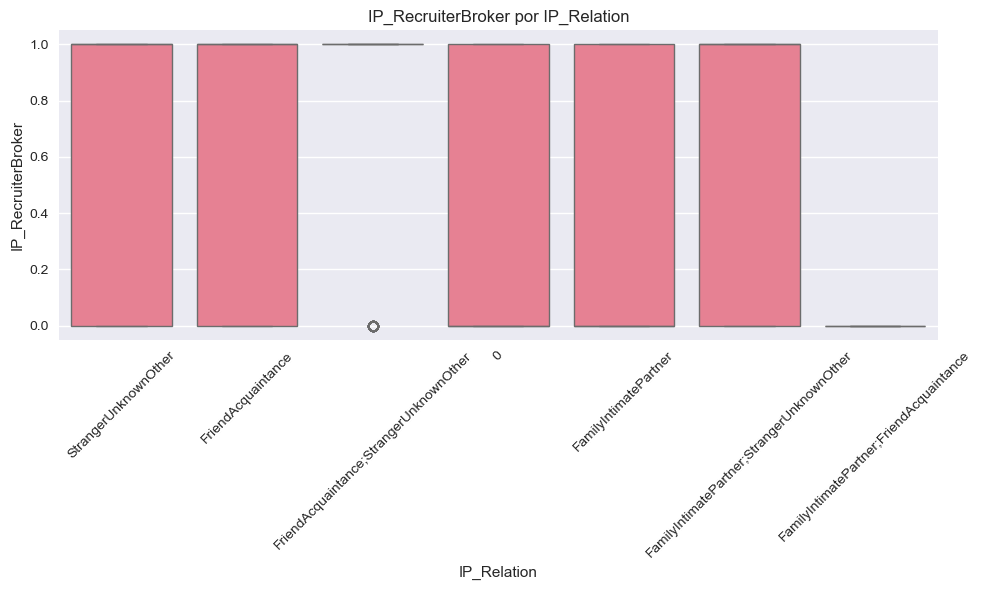


>>> IP_Relation x IP_TransactionProcess
                                             count      mean       std  min  \
IP_Relation                                                                   
0                                           6623.0  0.227842  0.419472  0.0   
FamilyIntimatePartner                        967.0  0.317477  0.465736  0.0   
FamilyIntimatePartner;FriendAcquaintance       6.0  0.000000  0.000000  0.0   
FamilyIntimatePartner;StrangerUnknownOther    73.0  0.410959  0.495413  0.0   
FriendAcquaintance                          4617.0  0.323370  0.467813  0.0   
FriendAcquaintance;StrangerUnknownOther      588.0  0.561224  0.496660  0.0   
StrangerUnknownOther                        8321.0  0.441654  0.496614  0.0   

                                            25%  50%  75%  max  
IP_Relation                                                     
0                                           0.0  0.0  0.0  1.0  
FamilyIntimatePartner                       0.0  0.0

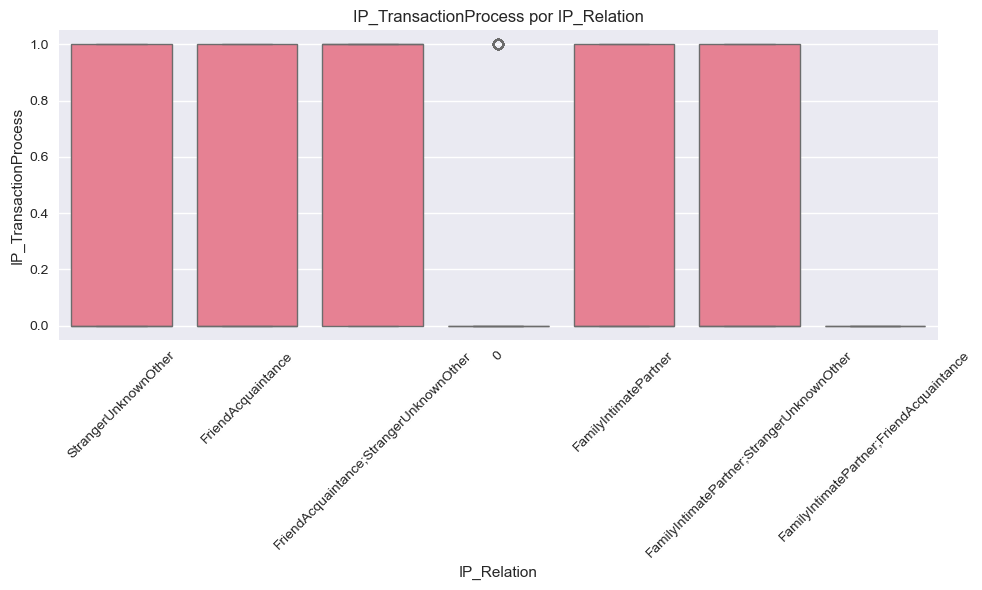


>>> IP_Relation x IP_ControlAbuseKidnap
                                             count      mean       std  min  \
IP_Relation                                                                   
0                                           6623.0  0.057829  0.233437  0.0   
FamilyIntimatePartner                        967.0  0.058945  0.235644  0.0   
FamilyIntimatePartner;FriendAcquaintance       6.0  0.000000  0.000000  0.0   
FamilyIntimatePartner;StrangerUnknownOther    73.0  0.082192  0.276557  0.0   
FriendAcquaintance                          4617.0  0.060429  0.238305  0.0   
FriendAcquaintance;StrangerUnknownOther      588.0  0.149660  0.357041  0.0   
StrangerUnknownOther                        8321.0  0.152025  0.359067  0.0   

                                            25%  50%  75%  max  
IP_Relation                                                     
0                                           0.0  0.0  0.0  1.0  
FamilyIntimatePartner                       0.0  0.0

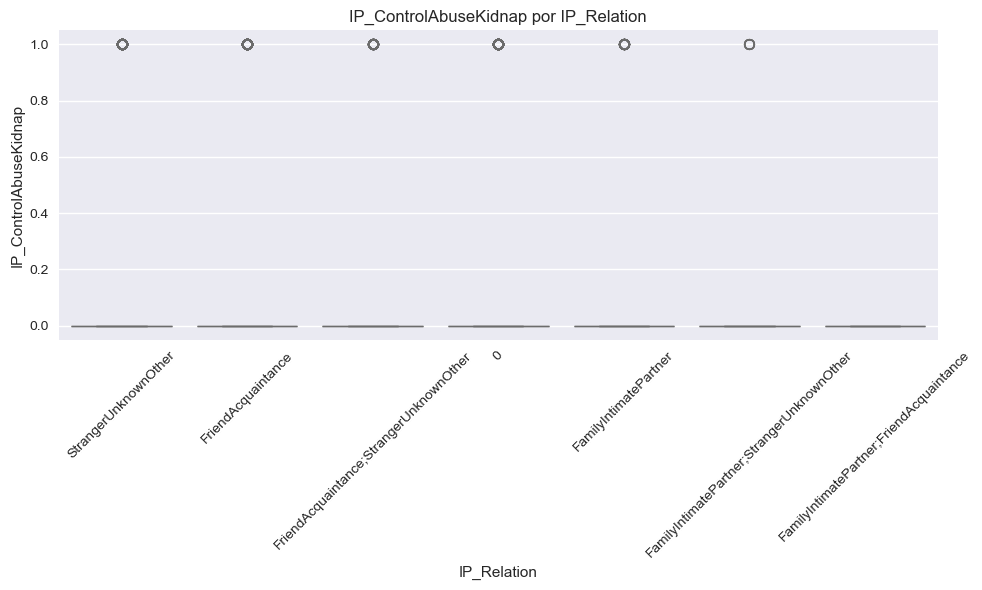


>>> IP_PayMoney x isForcedLabour
               count      mean       std  min  25%  50%  75%  max
IP_PayMoney                                                      
0             6040.0  0.297020  0.456983  0.0  0.0  0.0  1.0  1.0
No           11075.0  0.687314  0.463609  0.0  0.0  1.0  1.0  1.0
No;Yes         944.0  0.898305  0.302407  0.0  1.0  1.0  1.0  1.0
Yes           3136.0  0.635842  0.481270  0.0  0.0  1.0  1.0  1.0
ANOVA: F = 1136.4518, p-value = 0.0000


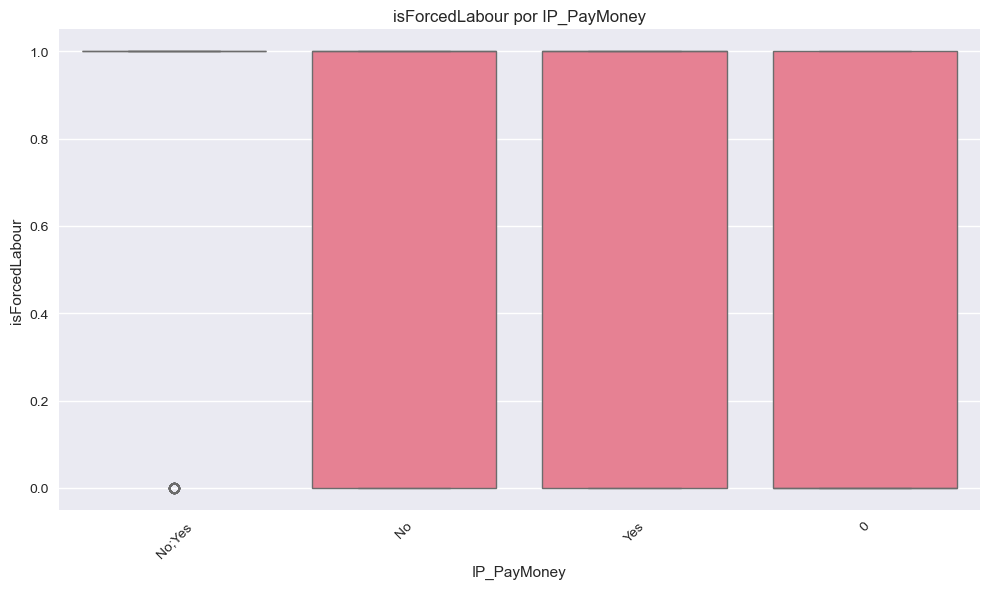


>>> IP_PayMoney x isSexualExploit
               count      mean       std  min  25%  50%  75%  max
IP_PayMoney                                                      
0             6040.0  0.169040  0.374818  0.0  0.0  0.0  0.0  1.0
No           11075.0  0.140045  0.347050  0.0  0.0  0.0  0.0  1.0
No;Yes         944.0  0.002119  0.046004  0.0  0.0  0.0  0.0  1.0
Yes           3136.0  0.064094  0.244960  0.0  0.0  0.0  0.0  1.0
ANOVA: F = 117.2083, p-value = 0.0000


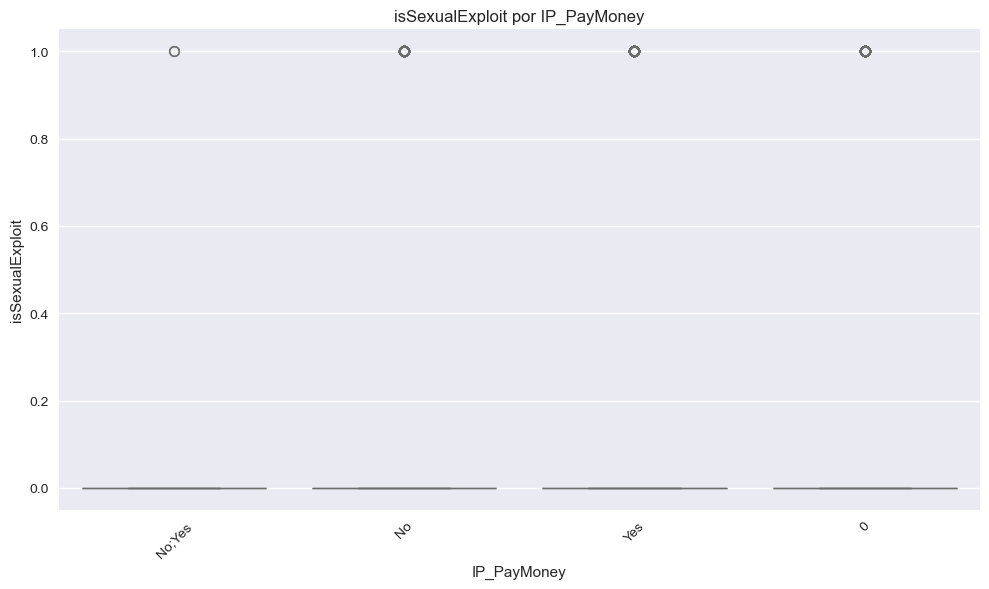


>>> IP_PayMoney x IP_Exploiter
               count      mean       std  min  25%  50%  75%  max
IP_PayMoney                                                      
0             6040.0  0.312086  0.463383  0.0  0.0  0.0  1.0  1.0
No           11075.0  0.526140  0.499339  0.0  0.0  1.0  1.0  1.0
No;Yes         944.0  0.582627  0.493387  0.0  0.0  1.0  1.0  1.0
Yes           3136.0  0.381378  0.485802  0.0  0.0  0.0  1.0  1.0
ANOVA: F = 295.2857, p-value = 0.0000


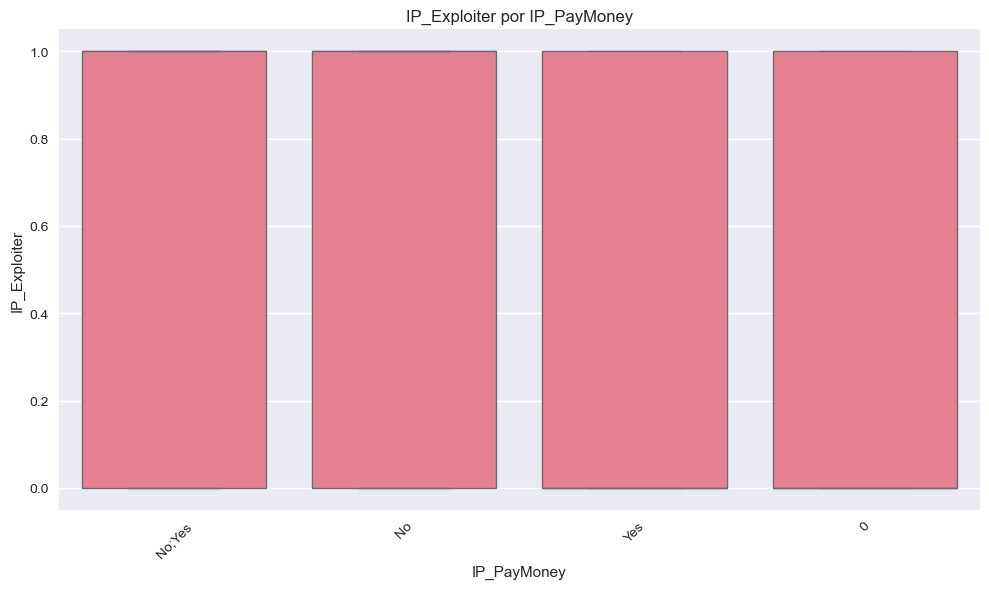


>>> IP_PayMoney x IP_RecruiterBroker
               count      mean       std  min  25%  50%  75%  max
IP_PayMoney                                                      
0             6040.0  0.346689  0.475955  0.0  0.0  0.0  1.0  1.0
No           11075.0  0.651828  0.476412  0.0  0.0  1.0  1.0  1.0
No;Yes         944.0  0.870763  0.335640  0.0  1.0  1.0  1.0  1.0
Yes           3136.0  0.551658  0.497404  0.0  0.0  1.0  1.0  1.0
ANOVA: F = 681.5539, p-value = 0.0000


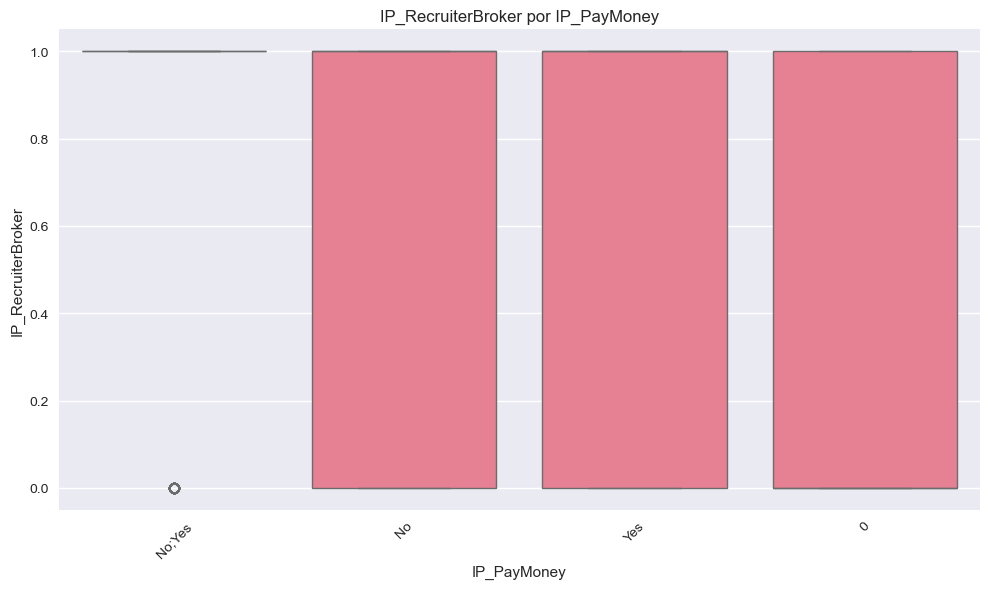


>>> IP_PayMoney x IP_TransactionProcess
               count      mean       std  min  25%  50%  75%  max
IP_PayMoney                                                      
0             6040.0  0.222848  0.416191  0.0  0.0  0.0  0.0  1.0
No           11075.0  0.380316  0.485486  0.0  0.0  0.0  1.0  1.0
No;Yes         944.0  0.687500  0.463758  0.0  0.0  1.0  1.0  1.0
Yes           3136.0  0.362564  0.480817  0.0  0.0  0.0  1.0  1.0
ANOVA: F = 332.2366, p-value = 0.0000


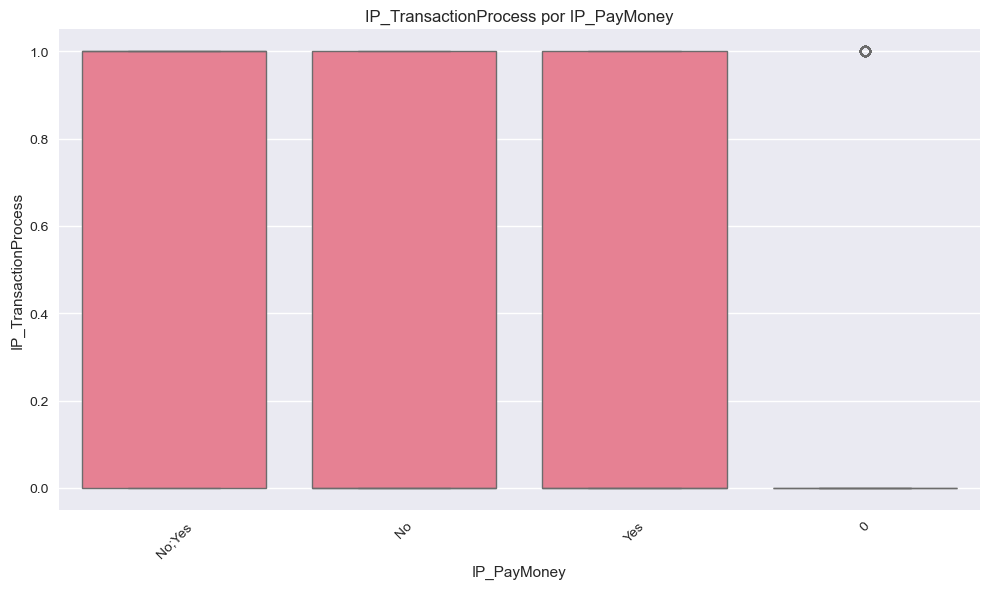


>>> IP_PayMoney x IP_ControlAbuseKidnap
               count      mean       std  min  25%  50%  75%  max
IP_PayMoney                                                      
0             6040.0  0.050993  0.220002  0.0  0.0  0.0  0.0  1.0
No           11075.0  0.114853  0.318859  0.0  0.0  0.0  0.0  1.0
No;Yes         944.0  0.092161  0.289406  0.0  0.0  0.0  0.0  1.0
Yes           3136.0  0.131059  0.337518  0.0  0.0  0.0  0.0  1.0
ANOVA: F = 76.0002, p-value = 0.0000


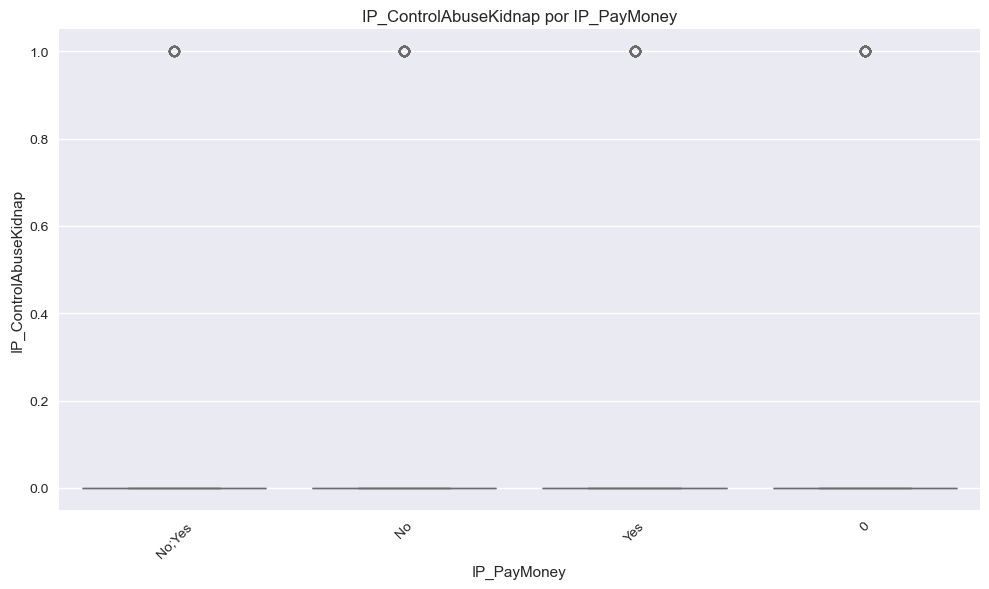

In [22]:
analise_categorica_numerica(df=df)

### Analise  de clustering


3.2 ANÁLISE DE CLUSTERING
--------------------------------------------------


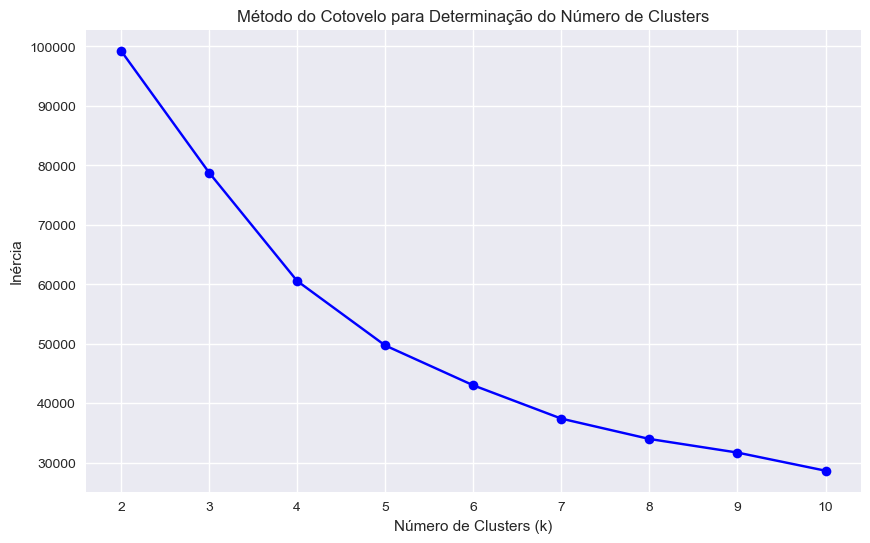

Aplicando K-means com 3 clusters
Distribuição dos clusters:
Cluster 0: 10310 observações (48.6%)
Cluster 1: 8110 observações (38.3%)
Cluster 2: 2775 observações (13.1%)


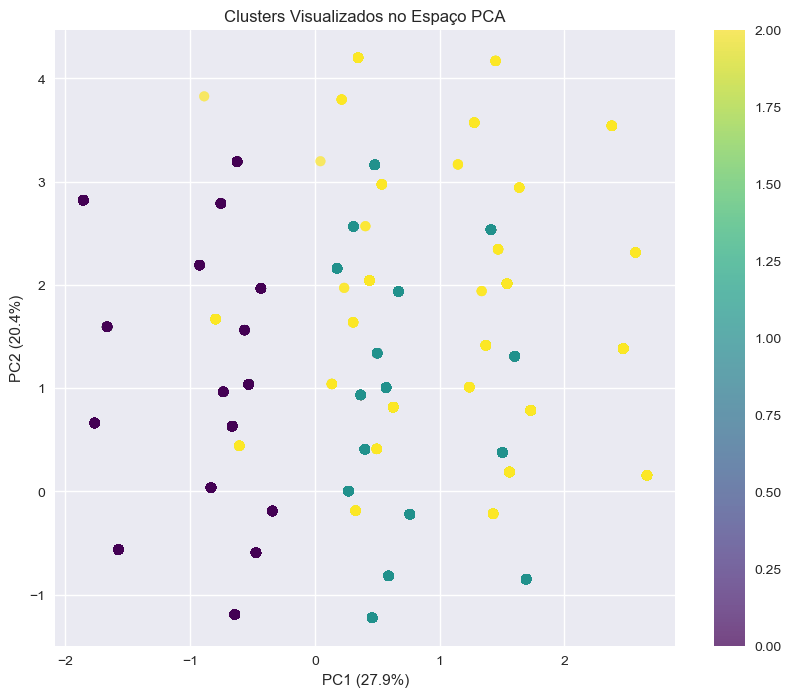

In [23]:
analise_clustering(df=df)

### Analise de correlação avançada


3.3 ANÁLISES DE CORRELAÇÃO AVANÇADAS
--------------------------------------------------
Comparação de diferentes tipos de correlação:
----------------------------------------

>>> isForcedLabour x isSexualExploit
Pearson:  r = -0.3559, p = 0.0000
Spearman: ρ = -0.3559, p = 0.0000
Kendall:  τ = -0.3559, p = 0.0000


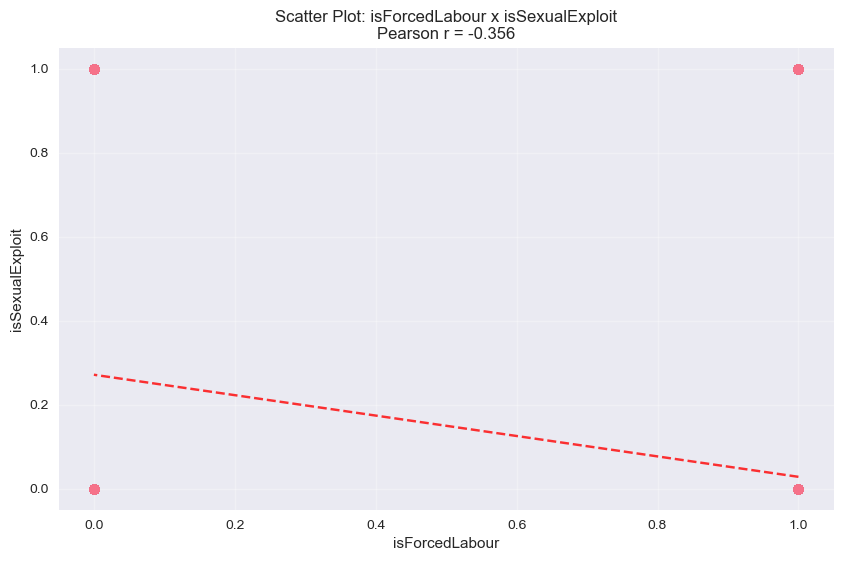


>>> isForcedLabour x IP_Exploiter
Pearson:  r = 0.2172, p = 0.0000
Spearman: ρ = 0.2172, p = 0.0000
Kendall:  τ = 0.2172, p = 0.0000


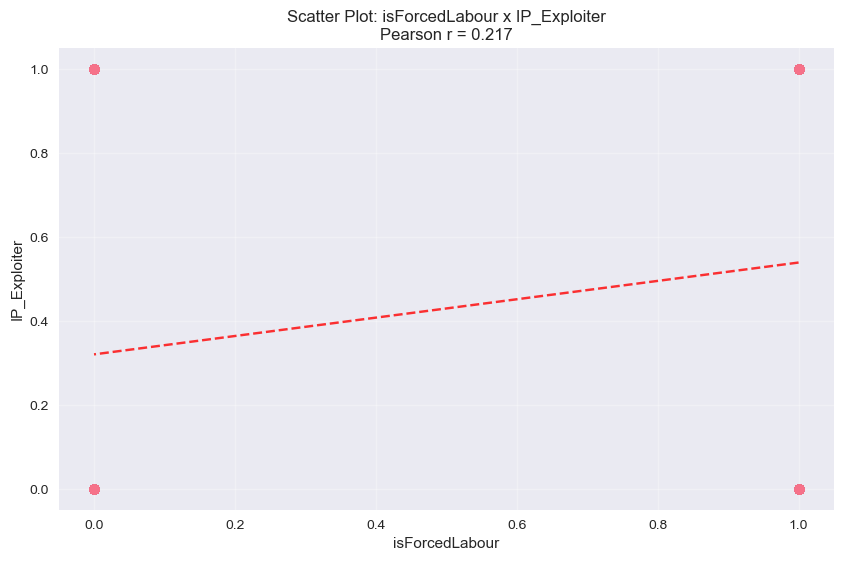


>>> isForcedLabour x IP_RecruiterBroker
Pearson:  r = 0.3423, p = 0.0000
Spearman: ρ = 0.3423, p = 0.0000
Kendall:  τ = 0.3423, p = 0.0000


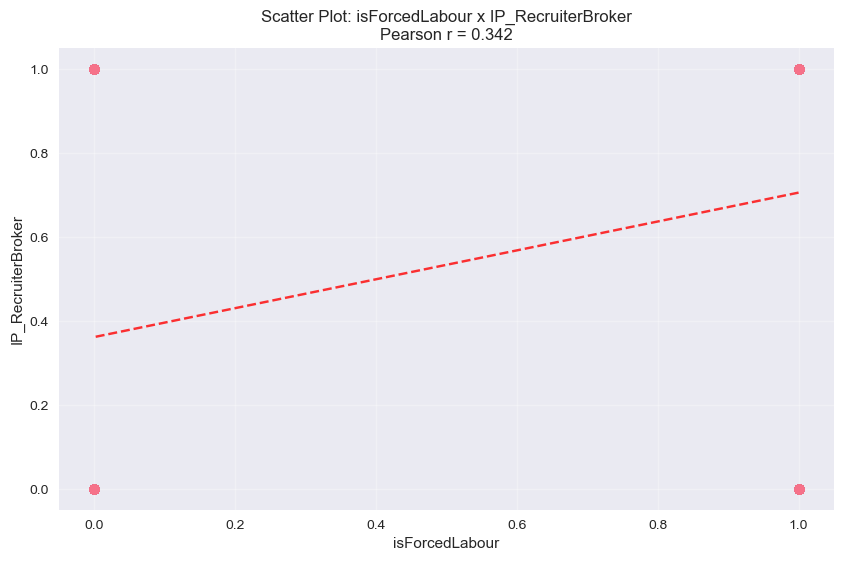


>>> isForcedLabour x IP_TransactionProcess
Pearson:  r = 0.0825, p = 0.0000
Spearman: ρ = 0.0825, p = 0.0000
Kendall:  τ = 0.0825, p = 0.0000


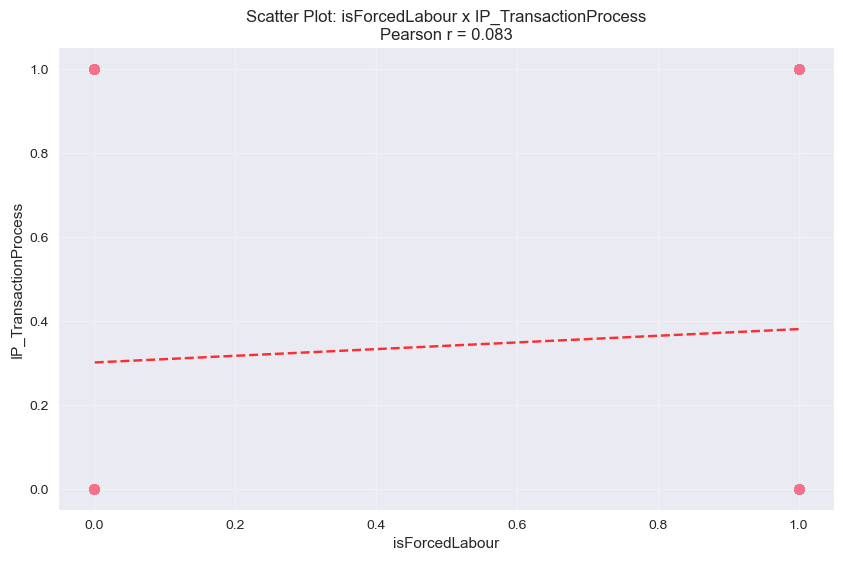


>>> isForcedLabour x IP_ControlAbuseKidnap
Pearson:  r = -0.0652, p = 0.0000
Spearman: ρ = -0.0652, p = 0.0000
Kendall:  τ = -0.0652, p = 0.0000


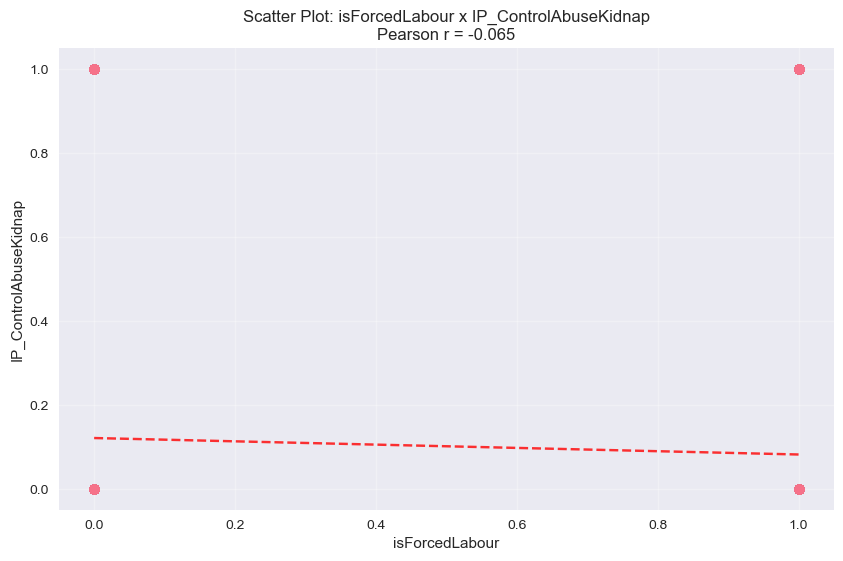


>>> isSexualExploit x IP_Exploiter
Pearson:  r = 0.0235, p = 0.0006
Spearman: ρ = 0.0235, p = 0.0006
Kendall:  τ = 0.0235, p = 0.0006


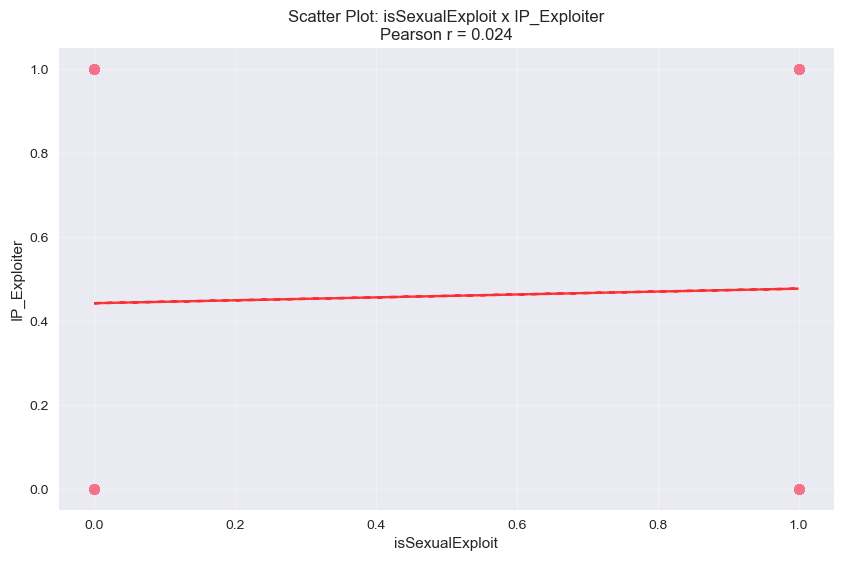


>>> isSexualExploit x IP_RecruiterBroker
Pearson:  r = -0.0297, p = 0.0000
Spearman: ρ = -0.0297, p = 0.0000
Kendall:  τ = -0.0297, p = 0.0000


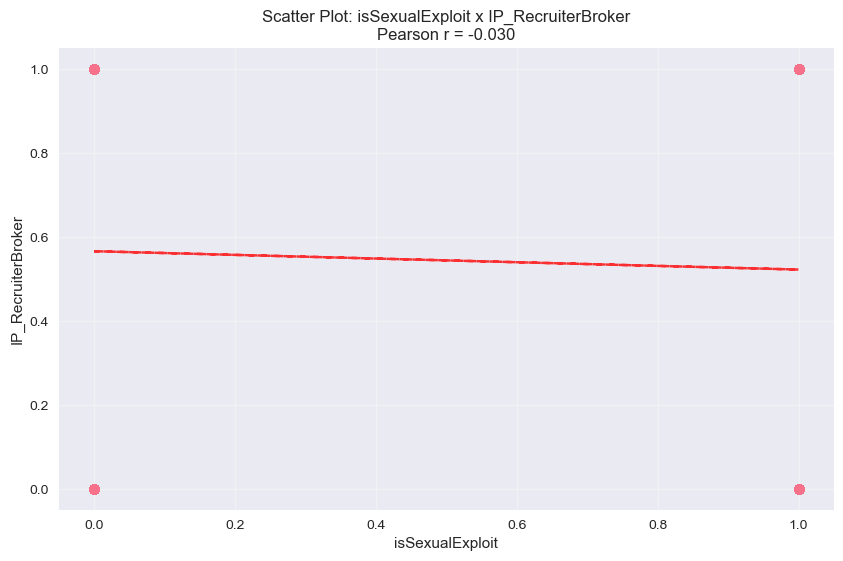


>>> isSexualExploit x IP_TransactionProcess
Pearson:  r = 0.0325, p = 0.0000
Spearman: ρ = 0.0325, p = 0.0000
Kendall:  τ = 0.0325, p = 0.0000


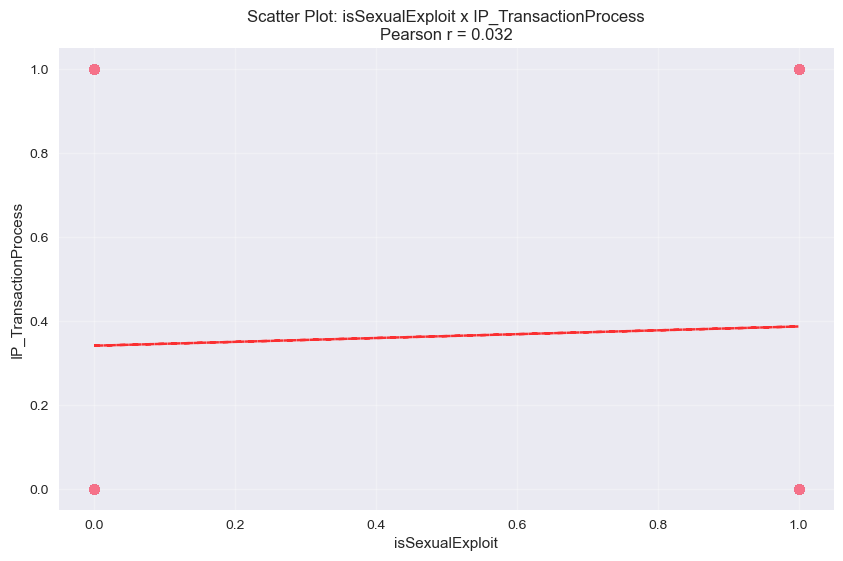


>>> isSexualExploit x IP_ControlAbuseKidnap
Pearson:  r = -0.0245, p = 0.0004
Spearman: ρ = -0.0245, p = 0.0004
Kendall:  τ = -0.0245, p = 0.0004


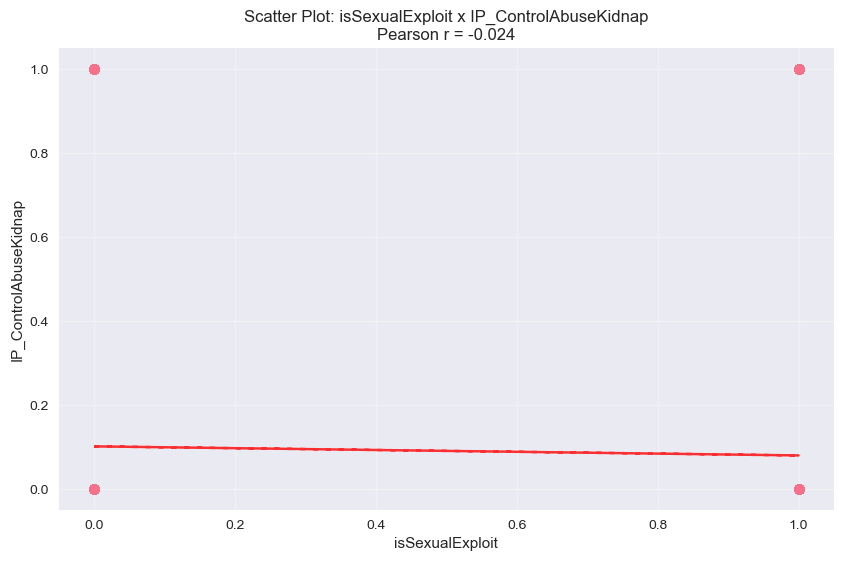


>>> IP_Exploiter x IP_RecruiterBroker
Pearson:  r = 0.3280, p = 0.0000
Spearman: ρ = 0.3280, p = 0.0000
Kendall:  τ = 0.3280, p = 0.0000


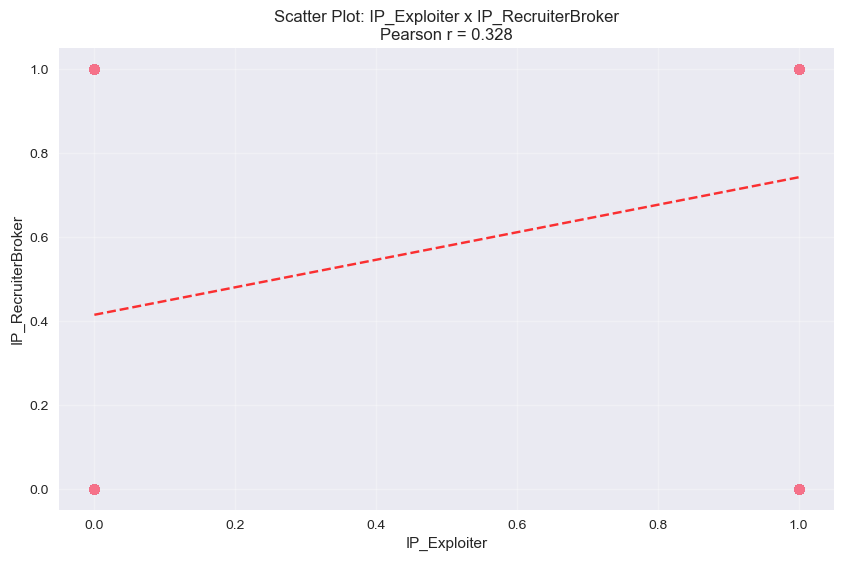


>>> IP_Exploiter x IP_TransactionProcess
Pearson:  r = 0.0524, p = 0.0000
Spearman: ρ = 0.0524, p = 0.0000
Kendall:  τ = 0.0524, p = 0.0000


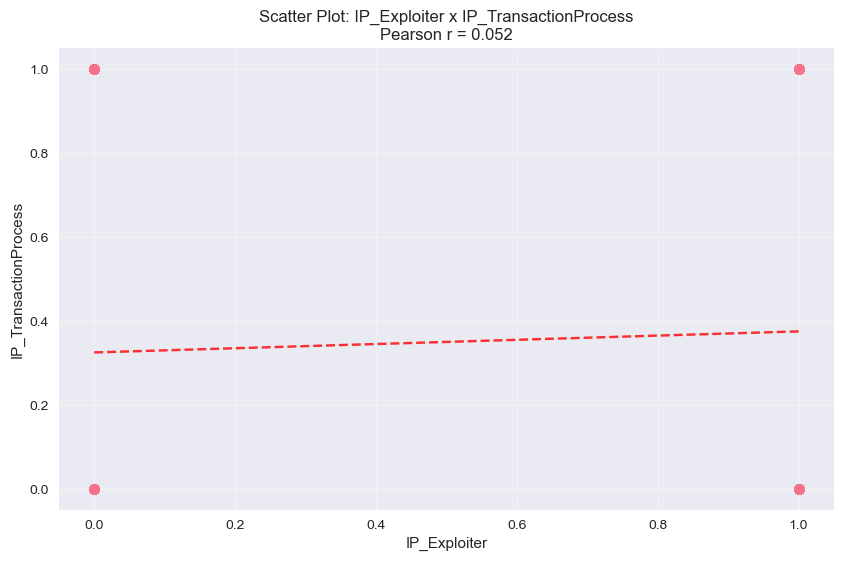


>>> IP_Exploiter x IP_ControlAbuseKidnap
Pearson:  r = 0.1033, p = 0.0000
Spearman: ρ = 0.1033, p = 0.0000
Kendall:  τ = 0.1033, p = 0.0000


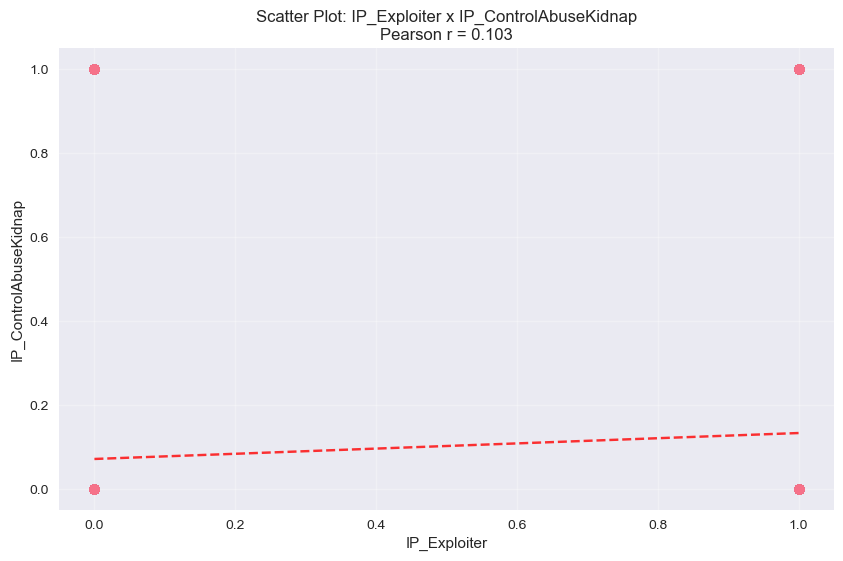


>>> IP_RecruiterBroker x IP_TransactionProcess
Pearson:  r = -0.0148, p = 0.0310
Spearman: ρ = -0.0148, p = 0.0310
Kendall:  τ = -0.0148, p = 0.0310


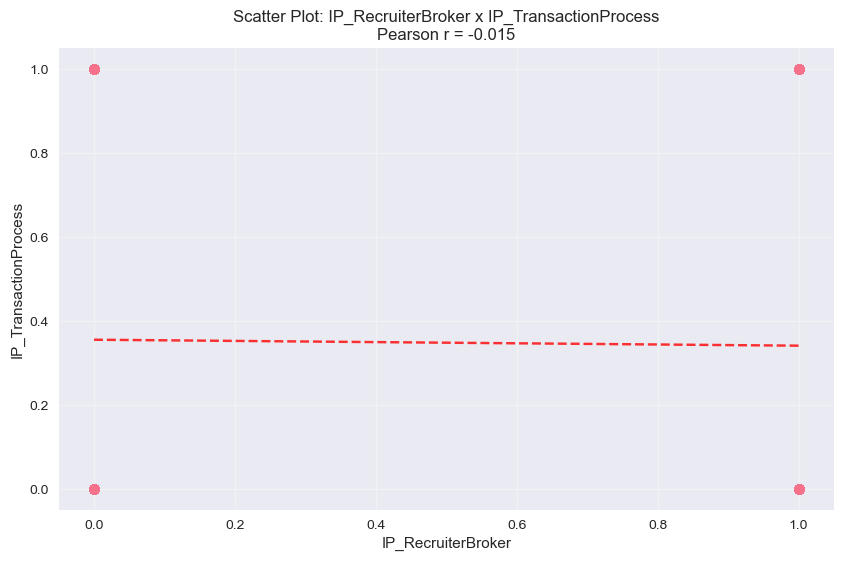


>>> IP_RecruiterBroker x IP_ControlAbuseKidnap
Pearson:  r = -0.0266, p = 0.0001
Spearman: ρ = -0.0266, p = 0.0001
Kendall:  τ = -0.0266, p = 0.0001


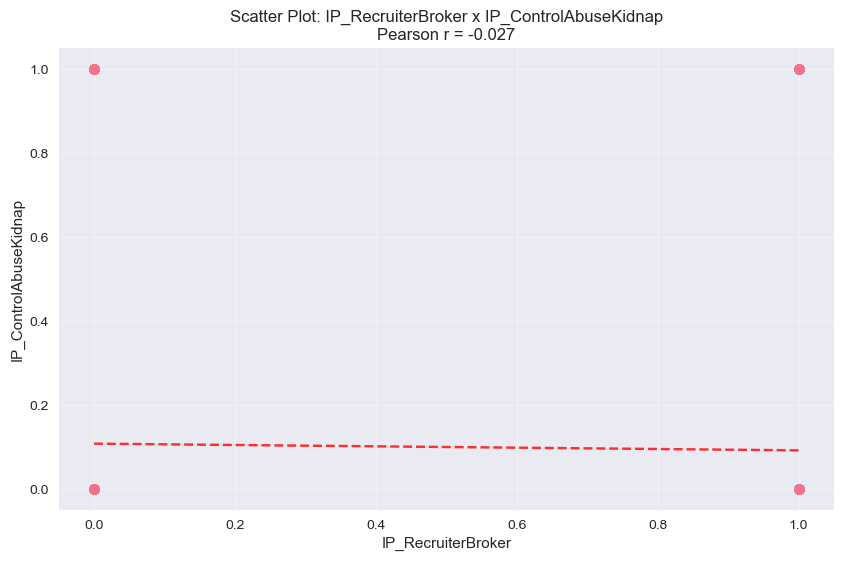


>>> IP_TransactionProcess x IP_ControlAbuseKidnap
Pearson:  r = 0.1847, p = 0.0000
Spearman: ρ = 0.1847, p = 0.0000
Kendall:  τ = 0.1847, p = 0.0000


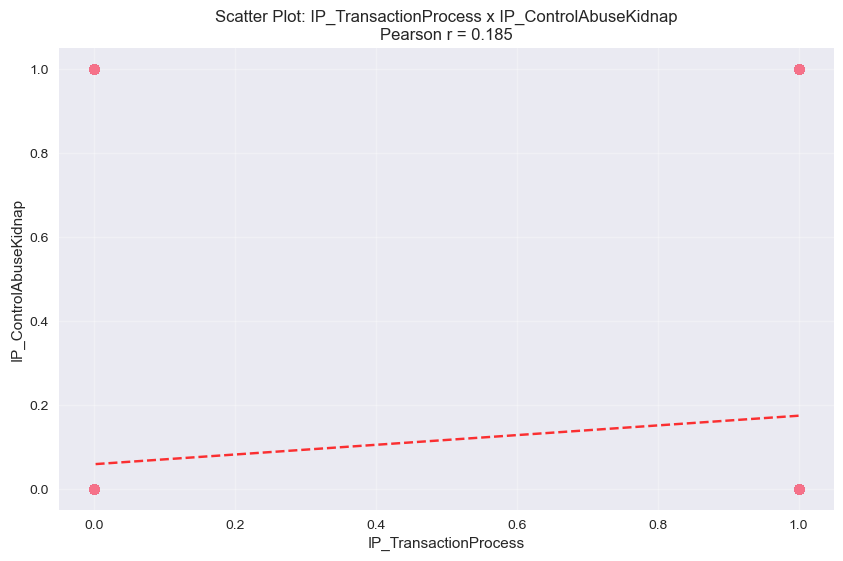

In [24]:
analise_correlacoes_avancadas(df=df)